In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
!pip install -U vnstock
from vnstock import *
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00


In [2]:
# Get Data
data = stock_historical_data(symbol='ACB',
                            start_date="2006-11-01",
                            end_date='2024-03-31', resolution='1D', type='stock', beautify=True, decor=False, source='TCBS')

data.head()

Time range is 6360 days. Looping through 18 requests


time  open  high   low  close  volume ticker
0  2006-11-21  3540  5780  4580   5010   56500    ACB
1  2006-11-22  4240  5520  5010   5190   62300    ACB
2  2006-11-23  4280  5580  5010   5330   69900    ACB
3  2006-11-24  4160  5850  5390   5650   63600    ACB
4  2006-11-27  4350  6220  5200   5650   42400    ACB

# **1. EDA**

In [3]:
data.describe()

open          high           low         close        volume
count   4341.000000   4341.000000   4341.000000   4341.000000  4.341000e+03
mean    7449.434001   7590.364202   7387.165630   7486.542502  2.363924e+06
std     5480.158470   5539.254413   5416.449332   5477.750224  3.517177e+06
min     1940.000000   2050.000000   1960.000000   2000.000000  1.400000e+03
25%     3360.000000   3410.000000   3330.000000   3360.000000  2.132000e+05
50%     4960.000000   5220.000000   5010.000000   5110.000000  8.601000e+05
75%     8670.000000   8950.000000   8680.000000   8810.000000  3.204367e+06
max    23860.000000  24320.000000  23690.000000  23940.000000  3.515600e+07

The dataset contains daily stock data for ACB, spanning from **11/01/2006 to 31/03/2024**. Each row represents a trading day and includes the following information:

* time: The observation date.
* open: The opening price of the stock on that day.
* high: The highest price the stock reached on that day.
* low: The lowest price the stock reached on that day.
* close: The closing price of the stock on that day.
* volume: The volume of shares traded on that day.

##**1.1 Overall ACB's closing price**

Let's take a look at how ACB's closing price has changed over time:

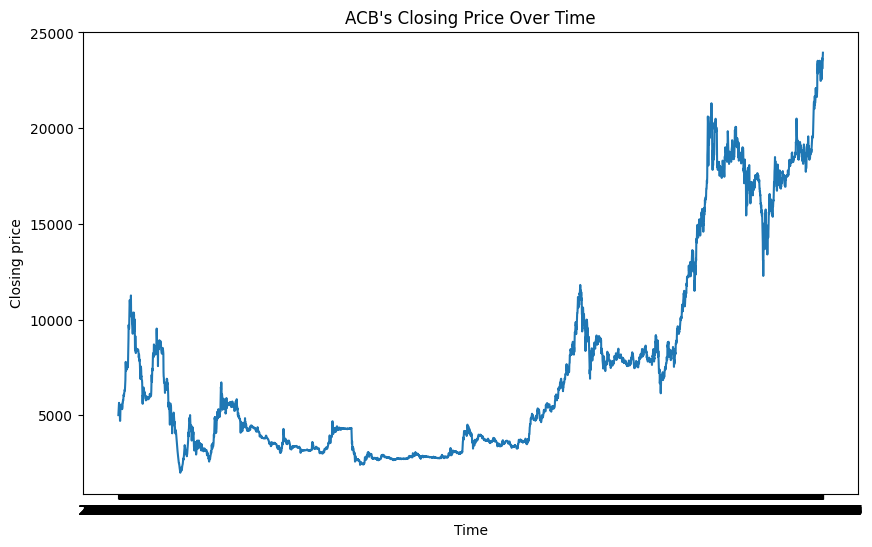

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['close'])
plt.xlabel("Time")
plt.ylabel("Closing price")
plt.title("ACB's Closing Price Over Time")
plt.show()

The chart shows a strong growth trend of ACB's closing price from 2012 to the end of 2023.

The main observable periods are:
- 2012 - 2015: Volatile period with prices fluctuating between 3000 - 5000.
-2016 - 2017: Stable period and slight growth.
- Late 2017 - 2020: Dramatic growth period, especially from late 2017 to early 2018 and mid-2020.
- 2021 - 2024: Strong volatility period with many peaks and troughs, but overall still maintaining an upward trend.

##**1.2 Closing Price Distribution Analysis**

Để hiểu phân phối của giá đóng cửa, chúng ta sẽ sử dụng biểu đồ histogram:

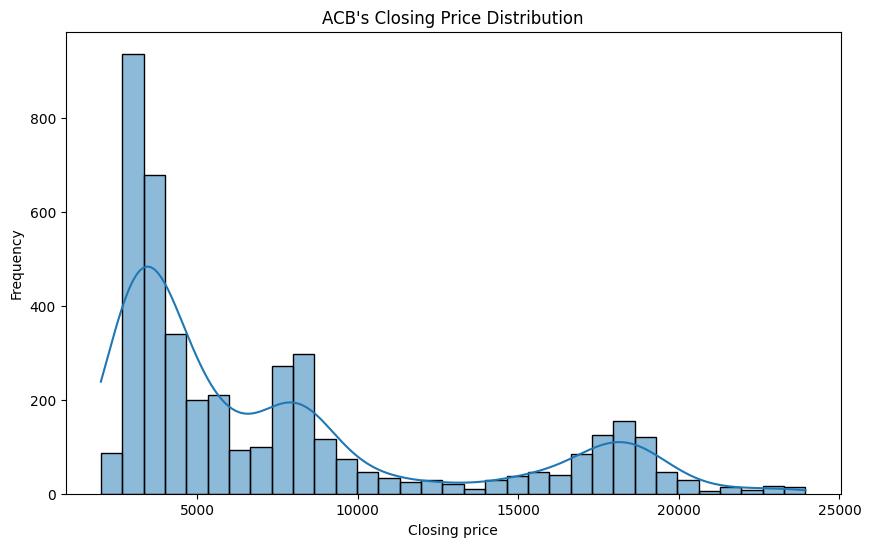

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['close'], kde=True)
plt.xlabel("Closing price")
plt.ylabel("Frequency")
plt.title("ACB's Closing Price Distribution")
plt.show()

Analyzing the above chart will help us determine whether the data is normally distributed or skewed.

The histogram shows that the closing price distribution of ACB shares is right-skewed, with most of the values ​​concentrated in the range of 4000 to 10000.
Main features:
- Most common value: Around 4000 - 5000 (this is the early stage of the data, when ACB shares are still low).
- Values ​​that appear frequently:
- Around 9000 - 10000
- Around 25000 - 30000 (this is the late stage of the data, when ACB shares have grown significantly).
- Few values: In the middle of the range of 15000 - 20000.

**Comments:**
The right-skewed distribution shows the growth of ACB shares over time.

##**1.3 Summary of closing price statistics**

We can also obtain descriptive statistics to summarize the central tendency and dispersion of closing prices:

count     4341.000000
mean      7486.542502
std       5477.750224
min       2000.000000
25%       3360.000000
50%       5110.000000
75%       8810.000000
max      23940.000000
Name: close, dtype: float64


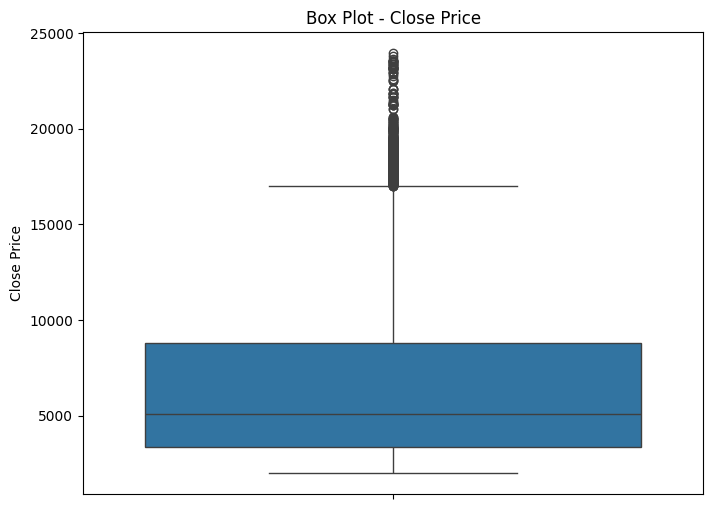

In [6]:
print(data['close'].describe())
plt.figure(figsize=(8, 6))
sns.boxplot(y=data['close'])
plt.title('Box Plot - Close Price')
plt.ylabel('Close Price')
plt.show()

The box plot shows the distribution of ACB stock closing prices and provides information about outliers.

**Observations:**

- Most of the values ​​are concentrated: Within the box, from about 8000 to 17000.
- Median: The horizontal line inside the box shows that the median is close to 10000.
- Outliers: There are some outliers above the box, shown by individual dots. This shows that there are trading days when ACB's closing price increases dramatically compared to most other days.

**Comments:**
- The box plot confirms the presence of outliers in the closing price data, consistent with the analysis from the previous histogram.

- The gap between the quartiles is quite large, indicating significant price fluctuations of ACB stock.

##**1.4 Correlation Between Variables**

To explore the relationship between different features, we will calculate the correlation matrix:

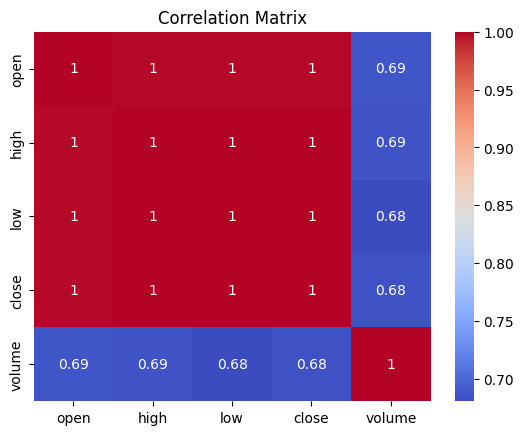

In [7]:
correlation_matrix = data[['open', 'high', 'low', 'close', 'volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows the linear relationship between variables in ACB stock data.

**Observations:**

- Very strong correlation (nearly 1): Between price variables (open, high, low, close). This shows that these values ​​tend to change together.
- Medium correlation (about 0.67 - 0.68): Between trading volume and price variables. This relationship shows that when price changes, trading volume also tends to change.

**Comments:**
- The strong correlation between price variables is understandable, because they all reflect the value of ACB stock at different times during the trading day.
- Medium correlation with trading volume shows that trading volume can be a factor affecting price, but not the only factor.

## **1.5 ACB's Transaction Volume Over Time**

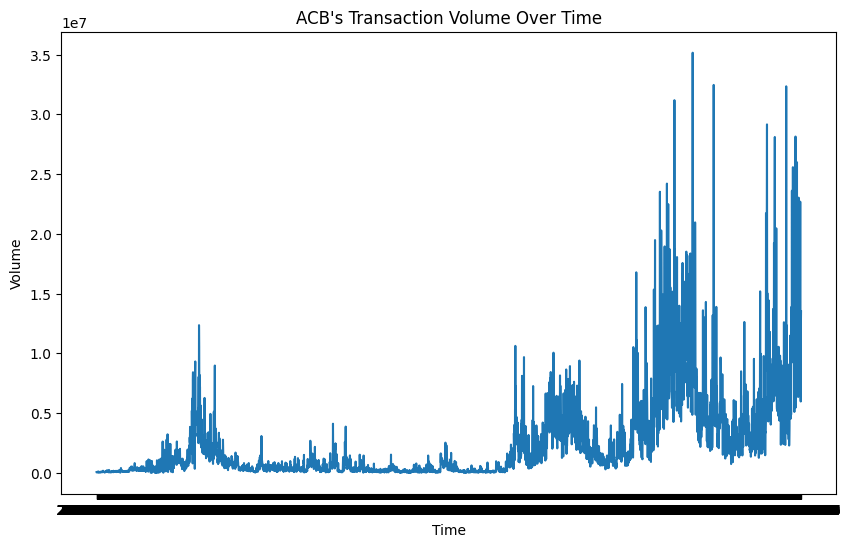

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['volume'])
plt.xlabel("Time")
plt.ylabel("Volume")
plt.title("ACB's Transaction Volume Over Time")
plt.show()

The chart shows the fluctuations in ACB stock trading volume from 2012 to early 2024.

**Observations:**
- Period 2012 - 2017: Trading volume remained low and relatively stable.
- From 2018 onwards: Trading volume fluctuated more strongly, with many peaks appearing.
- The highest peak: Located in early 2021, showing the special interest of investors at that time.

**Comments:**
- Trading volume tends to increase over time, especially from 2018 onwards, possibly due to the development of the stock market and the increasing interest in ACB stocks.

## **1.6 Relationship between closing price and trading volume**

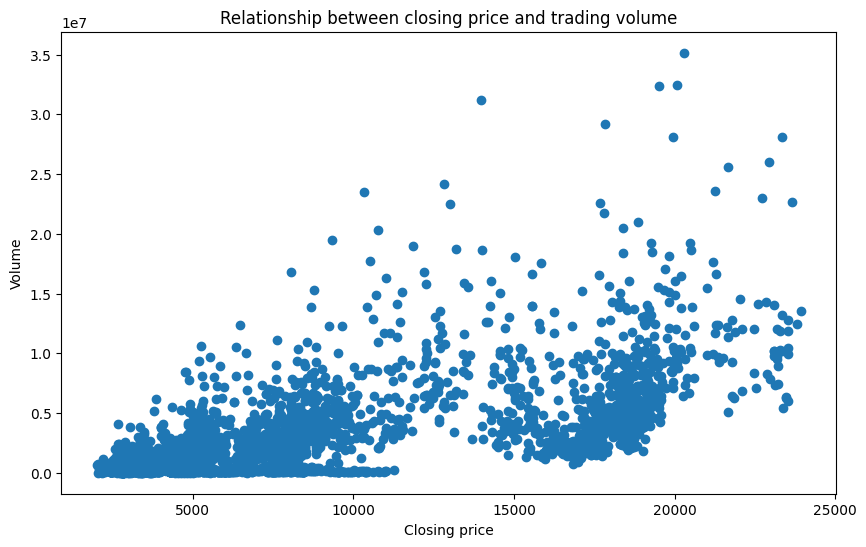

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(data['close'], data['volume'])
plt.xlabel("Closing price")
plt.ylabel("Volume")
plt.title("Relationship between closing price and trading volume")
plt.show()

The scatter plot shows the relationship between the closing price and trading volume of ACB stock.

**Observations:**
- General trend: There is a positive correlation between the two variables, meaning that when the closing price increases, the trading volume also tends to increase.
- Dispersion: The relationship is not completely linear and has a fairly large dispersion. At the same price, the trading volume can fluctuate within a wide range.
- Outliers: There are some data points that are separate from the general trend, showing trading days with unusual volume compared to the price.

**Comments:**
- The positive correlation between price and trading volume shows that investor interest increases as the stock price increases.
However, the dispersion and the presence of outliers show that trading volume is not the only factor affecting price, and there may be other factors at play.

# **2. Data Preprocessing**

## **2.1 Handling Missing Values**

We need to check for missing values ​​in the data, which can affect analysis and modeling:

In [10]:
print(data.isnull().sum())

time      0
open      0
high      0
low       0
close     0
volume    0
ticker    0
dtype: int64


The results show that the dataset does not contain missing values.

## **2.2 Handing Time Index**

In [11]:
# Handing Time Index
data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time')
data = data[~data.index.duplicated(keep='first')]  # Delete duplicates
new_data = data.copy()

In [12]:
data.head()

open  high   low  close  volume ticker
time                                              
2006-11-21  3540  5780  4580   5010   56500    ACB
2006-11-22  4240  5520  5010   5190   62300    ACB
2006-11-23  4280  5580  5010   5330   69900    ACB
2006-11-24  4160  5850  5390   5650   63600    ACB
2006-11-27  4350  6220  5200   5650   42400    ACB

## **2.3 Data verification**

In [13]:
df_closing = new_data['close']
df_close = np.log(new_data['close']) #transform data into log

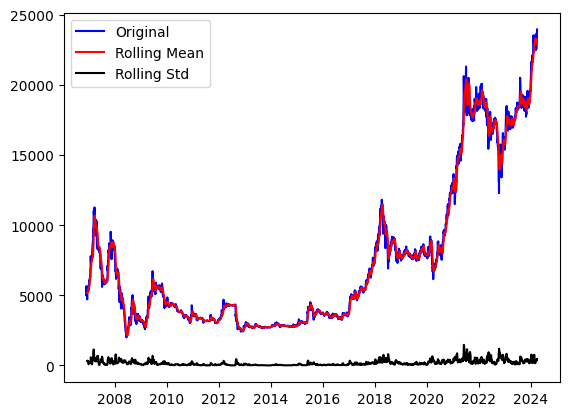

In [14]:
rolmean = df_closing.rolling(12).mean()
rolstd = df_closing.rolling(12).std()
plt.plot(df_closing, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend()
plt.show()

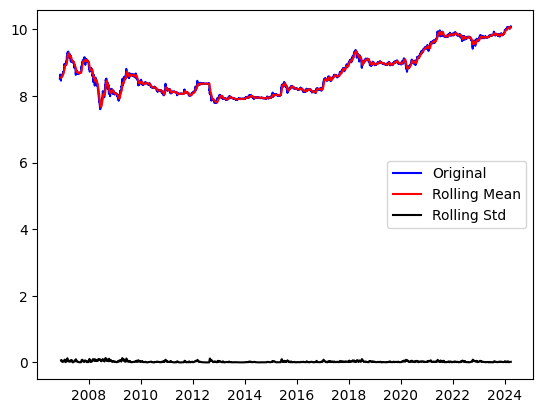

In [15]:
# Data decomposition:
rolmean = df_close.rolling(12).mean()
rolstd = df_close.rolling(12).std()
plt.plot(df_close, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend()
plt.show()

In [16]:
print(df_closing)

time
2006-11-21     5010
2006-11-22     5190
2006-11-23     5330
2006-11-24     5650
2006-11-27     5650
              ...  
2024-03-25    23100
2024-03-26    23480
2024-03-27    23520
2024-03-28    23810
2024-03-29    23940
Name: close, Length: 4324, dtype: int64


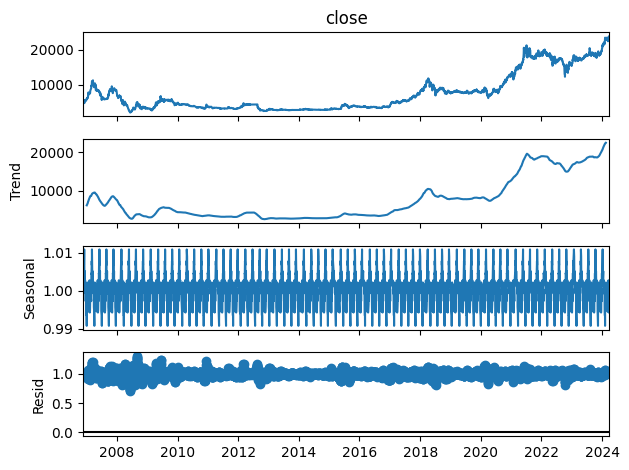

In [17]:
#Check for seasonality and trend in data:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(df_closing, model='multiplicative', period=60)
decompose_result.plot()
plt.show()

We can see that the data tends to increase over time and has a certain cyclical nature.

In [18]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot train and test data, validate data
def plot_train_test(actual ,train, test, val=None):
    plt.plot(actual, 'y',label='Actual data')
    plt.plot(train, 'b',label='Train data')
    plt.plot(test, 'r',label='Test data')
    if val is not None:
        plt.plot(val, 'g',label='Validate data')
    plt.xlabel('Date')
    plt.ylabel('Closing price')
    plt.legend()
    plt.show()

# Data series decay - plot rolling mean and standard deviation
def plot_rolling_mean_std(data):
    rolmean = data.rolling(window=12).mean()
    rolstd = data.rolling(window=12).std()
    plt.plot(data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Check the trends and cycles of the dataset
def plot_decompose(data):
    decompose_result = seasonal_decompose(data, model='multiplicative', period=30)
    decompose_result.plot()
    plt.show()

# Check the stationarity of the dataset
# ADF
def adf_test(data):
    print('Augmented Dickey-Fuller Test:')
    indices = ['Test Statistic', 'p-value', 'No. Lags Used', 'Number of Observations Used']
    test = adfuller(data, autolag='AIC')
    result = pd.Series(data=test[0:4], index=indices)
    for key, value in test[4].items():
        result[f'Critical Value ({key})'] = value
    return result

# KPSS
def kpss_test(data):
    print('KPSS Test:')
    indices = ['Test Statistic', 'p-value', 'No. Lags Used']
    test = kpss(data)
    result = pd.Series(data=test[0:3], index=indices)
    for key, value in test[3].items():
        result[f'Critical Value ({key})'] = value
    return result

#correlation test
def plot_correlation(data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    lag_plot(data, ax=axes[0])
    plot_pacf(data, ax=axes[1])
    plot_acf(data, ax=axes[2])
    plt.show()

# Plot Initial data and after differentiation
def plot_diff(data, data_diff):
    fig, ax = plt.subplots(2, sharex='all')
    ax[0].plot(data)
    ax[0].set_title('Initial data')
    ax[1].plot(data_diff)
    ax[1].set_title('After differentiation')
    plt.xticks(rotation=30, ha="right")
    plt.show()

# check stationarity
def is_stationary(data):
    result = adf_test(data)
    p_value = result['p-value']
    return p_value <= 0.05

# Function to make data stationary by differencing
def make_stationary(data):
    return data.diff().dropna()


In [19]:
# Test for stationarity of data
# ADF
print(adf_test(df_closing))

Augmented Dickey-Fuller Test:
Test Statistic                    0.717710
p-value                           0.990185
No. Lags Used                    28.000000
Number of Observations Used    4295.000000
Critical Value (1%)              -3.431873
Critical Value (5%)              -2.862213
Critical Value (10%)             -2.567128
dtype: float64


The absolute value of the statistical test value is smaller than the absolute value at the 1%, 5%, and 10% levels, so the hypothesis H0 cannot be rejected => **The time series is not stationary.**

In [20]:
# KPSS
print(kpss_test(df_closing))

KPSS Test:
Test Statistic            6.761086
p-value                   0.010000
No. Lags Used            40.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-18-7e658f35bd11>:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  test = kpss(data)


The test statistic value is greater than the value at the 1%, 5%, and 10% levels, so we can reject the hypothesis H0 => **The time series is not stationary.**

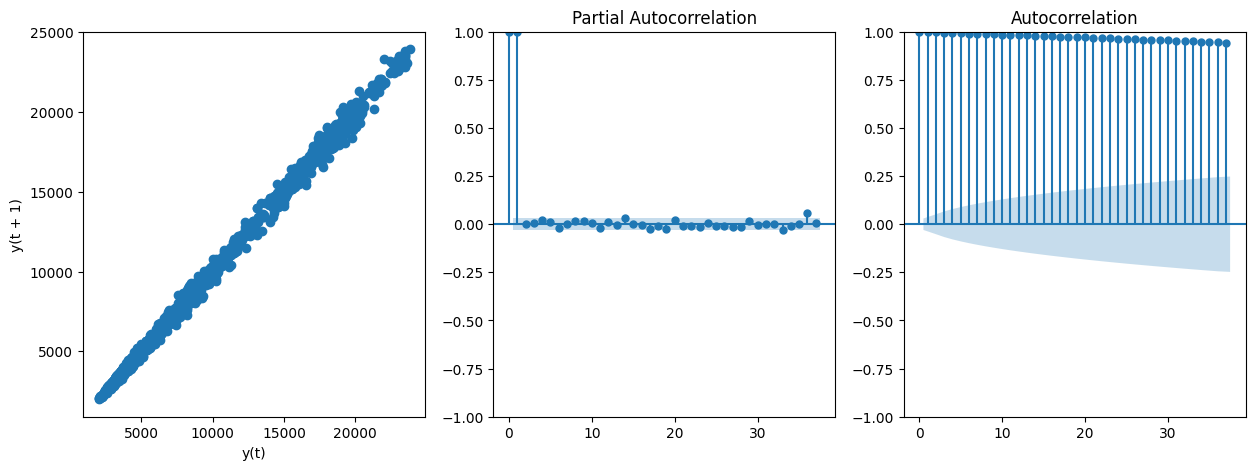

In [21]:
# Check Auto Correlation
plot_correlation(df_closing)

**Scatter Plot:** This plot shows a strong positive linear relationship between two variables, perhaps the closing prices of stocks at two different points in time. The x-axis is labeled as ( y(t) ) and the y-axis is ( y(t+1) ), both ranging from 5000 to 25000, indicating that today's closing price has a large impact on tomorrow's price. <br><br>
**Partial Autocorrelation Graph (PACF):** This plot has the x-axis representing lags from 0 to about 35 and the y-axis from -1.00 to +1.00. The blue points are distributed near the zero line, showing low partial correlations for different lags, indicating that there is no significant relationship between the stock closing values ​​and previous values ​​after removing the influence of more recent closing values.<br><br>
**Autocorrelation Graph (ACF):** This graph shows significant autocorrelation at different lags, indicating that the stock's closing price has a strong correlation with its past values, which may indicate non-randomness in the data and the potential for seasonal or trend patterns.

In [22]:
print(new_data)

             open   high    low  close    volume ticker
time                                                   
2006-11-21   3540   5780   4580   5010     56500    ACB
2006-11-22   4240   5520   5010   5190     62300    ACB
2006-11-23   4280   5580   5010   5330     69900    ACB
2006-11-24   4160   5850   5390   5650     63600    ACB
2006-11-27   4350   6220   5200   5650     42400    ACB
...           ...    ...    ...    ...       ...    ...
2024-03-25  23560  23560  23100  23100  10196791    ACB
2024-03-26  23180  23480  22970  23480   6287467    ACB
2024-03-27  23480  23560  23180  23520   5962845    ACB
2024-03-28  23770  24020  23690  23810  12429800    ACB
2024-03-29  23860  24070  23650  23940  13496333    ACB

[4324 rows x 6 columns]


# **3. Building AR, ARIMA models**

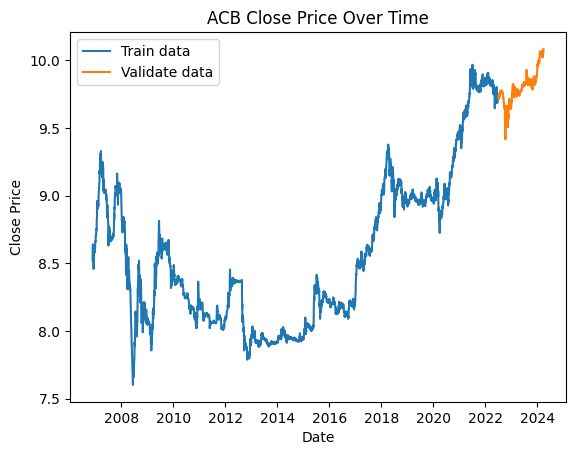

In [23]:
# Split data
df_close = np.log(new_data['close'])
df_train_test, df_val = df_close[:int(len(df_close) * 0.9)], df_close[int(len(df_close) * 0.9):]
plt.plot(df_train_test, label='Train data')
plt.plot(df_val, label='Validate data')
plt.title('ACB Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## **Split data in traditional way**

Simple Time Split: Train=3501, Test=390


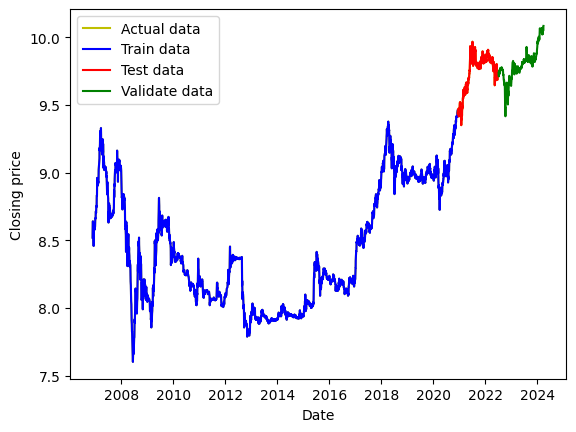

In [24]:
# Split data into train and test
# Case 1: Split data in traditional way
train_size = int(len(df_train_test) * 0.9)
train_simple, test_simple = df_train_test[:train_size], df_train_test[train_size:]
# Print the sizes of each split for verification
print(f"Simple Time Split: Train={len(train_simple)}, Test={len(test_simple)}")

# Plot train and test data
plot_train_test(df_train_test, train_simple, test_simple, df_val)


### **AR model**

In [25]:
# AR model
models = ar_select_order(train_simple, maxlag=30)
print('The lag order selected is: ', models.ar_lags)
model = AutoReg(train_simple, lags=1, old_names=False)
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The lag order selected is:  [1, 2]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  close   No. Observations:                 3501
Model:                     AutoReg(1)   Log Likelihood                8474.482
Method:               Conditional MLE   S.D. of innovations              0.021
Date:                Wed, 10 Jul 2024   AIC                         -16942.965
Time:                        09:28:13   BIC                         -16924.483
Sample:                             1   HQIC                        -16936.369
                                 3501                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.007      0.563      0.573      -0.010       0.018
close.L1       0.9996      0.001   1187.728      0.000       0.998       1.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0004           +0.0000j            1.0004            0.0000
-----------------------------------------------------------------------------
"""

In [26]:
fc_ar = model_fit.forecast(len(test_simple)+len(df_val))
fc_ar_test = model_fit.forecast(len(test_simple))
fc_ar_val = model_fit.forecast(len(df_val))
fc_ar_values = fc_ar
fc_ar_values_test = fc_ar_test
fc_ar_values_val = fc_ar_val
fc_ar_values.index = (test_simple+df_val).index
fc_ar_values_test.index = test_simple.index
fc_ar_values_val.index = df_val.index

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will

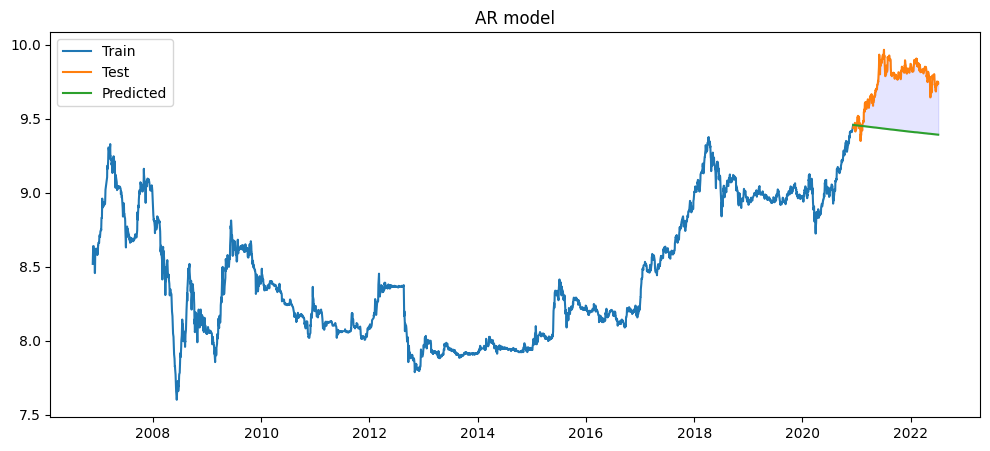

In [27]:
plt.figure(figsize=(12,5))
plt.plot(train_simple, label='Train')
plt.plot(test_simple, label='Test')
plt.plot(fc_ar_values_test, label='Predicted')
plt.fill_between(fc_ar_values_test.index, fc_ar_values_test, test_simple, color='b', alpha=.10)
plt.legend(loc='best')
plt.title('AR model')
plt.show()

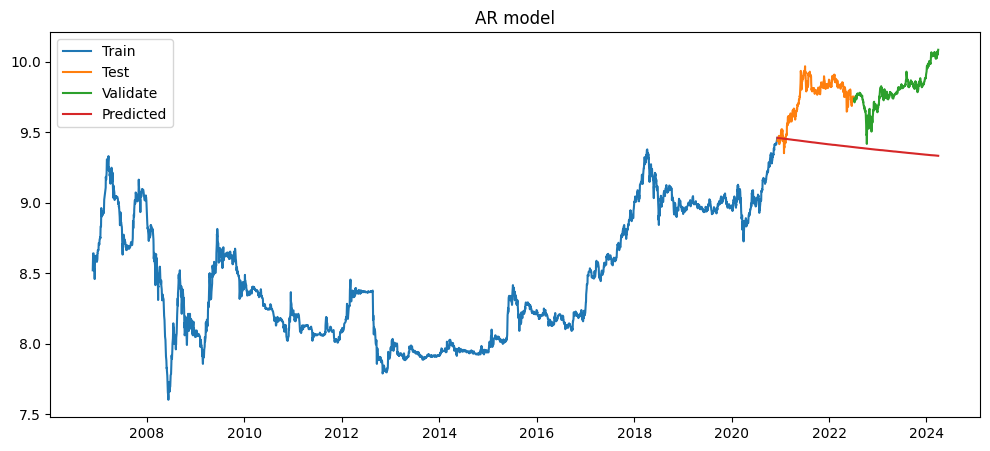

In [28]:
plt.figure(figsize=(12,5))
plt.plot(train_simple, label='Train')
plt.plot(test_simple, label='Test')
plt.plot(df_val, label='Validate')
plt.plot(fc_ar_values, label='Predicted')
plt.fill_between(fc_ar_values.index, fc_ar_values, test_simple + df_val, color='b', alpha=.10)
plt.legend(loc='best')
plt.title('AR model')
plt.show()

In [29]:
rmse = np.sqrt(mean_squared_error(test_simple, fc_ar_values_test))
print('Test RMSE: %.3f' % rmse)

# MAPE
abs_error = np.abs(test_simple - fc_ar_values_test)
mape = np.round(np.mean(abs_error/test_simple),3)
print('Test MAPE: %.3f' % mape)

# MAE
mae = np.mean(np.abs(fc_ar_values_test - test_simple))
print('Test MAE: %.3f' % mae)

# Verify results against validation set
rmse_val = np.sqrt(mean_squared_error(df_val, fc_ar_values_val))
abs_error_val = np.abs(df_val - fc_ar_values_val)
mape_val = np.round(np.mean(abs_error_val/df_val),3)
mae_val = np.mean(np.abs(fc_ar_values_val - df_val))

# Save results
results = pd.DataFrame(columns=['Model', 'RMSE', 'MAPE', 'MAE', 'RMSE_val', 'MAPE_val', 'MAE_val'])
tempResultsDf = pd.DataFrame({'Model':['Auto Regressive (AR)'], 'RMSE': [rmse], 'MAPE': [mape], 'MAE': [mae], 'RMSE_val': [rmse_val], 'MAPE_val': [mape_val], 'MAE_val': [mae_val]})
results = pd.concat([results, tempResultsDf])
print(results)
# model_fit.save('./Auto Regressive (AR).pkl')

Test RMSE: 0.357
Test MAPE: 0.033
Test MAE: 0.327
                  Model      RMSE   MAPE       MAE  RMSE_val  MAPE_val  \
0  Auto Regressive (AR)  0.356813  0.033  0.326974  0.400663     0.038   

    MAE_val  
0  0.376015  


### **ARIMA model**

In [30]:
# Stationarity test for Train dataset
print(adf_test(train_simple))
print('----------------------------------------')
print(kpss_test(train_simple))

Augmented Dickey-Fuller Test:
Test Statistic                   -1.409814
p-value                           0.577562
No. Lags Used                    20.000000
Number of Observations Used    3480.000000
Critical Value (1%)              -3.432230
Critical Value (5%)              -2.862371
Critical Value (10%)             -2.567212
dtype: float64
----------------------------------------
KPSS Test:
Test Statistic            2.834634
p-value                   0.010000
No. Lags Used            37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-18-7e658f35bd11>:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  test = kpss(data)


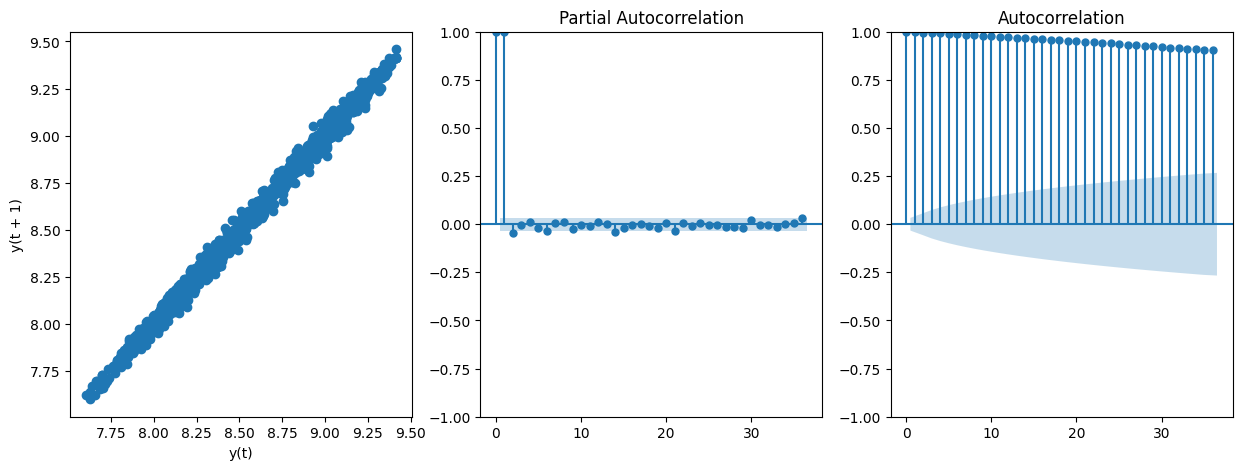

In [31]:
# Correlation test
plot_correlation(train_simple)

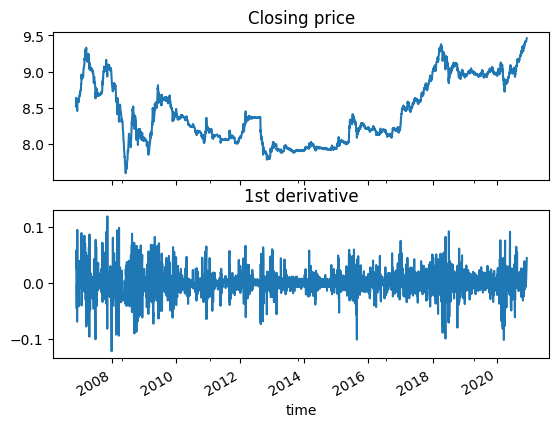

In [32]:
# Convert data --> stop sequence
def convert_stationary(data):
    data_diff = data.diff(1).dropna()
    return data_diff
train_simple_diff = convert_stationary(train_simple)

fix, ax =plt.subplots(2, sharex="all")
train_simple.plot(ax=ax[0], title ="Closing price")
train_simple_diff.plot(ax=ax[1], title = "1st derivative")
plt.show()


In [33]:
# Retest based on ADF and KPSS
print(adf_test(train_simple_diff))
print('----------------------------------------')
print(kpss_test(train_simple_diff))

Augmented Dickey-Fuller Test:
Test Statistic                -1.106288e+01
p-value                        4.760542e-20
No. Lags Used                  1.900000e+01
Number of Observations Used    3.480000e+03
Critical Value (1%)           -3.432230e+00
Critical Value (5%)           -2.862371e+00
Critical Value (10%)          -2.567212e+00
dtype: float64
----------------------------------------
KPSS Test:
Test Statistic            0.227289
p-value                   0.100000
No. Lags Used            13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-18-7e658f35bd11>:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test = kpss(data)


- Data has stopped

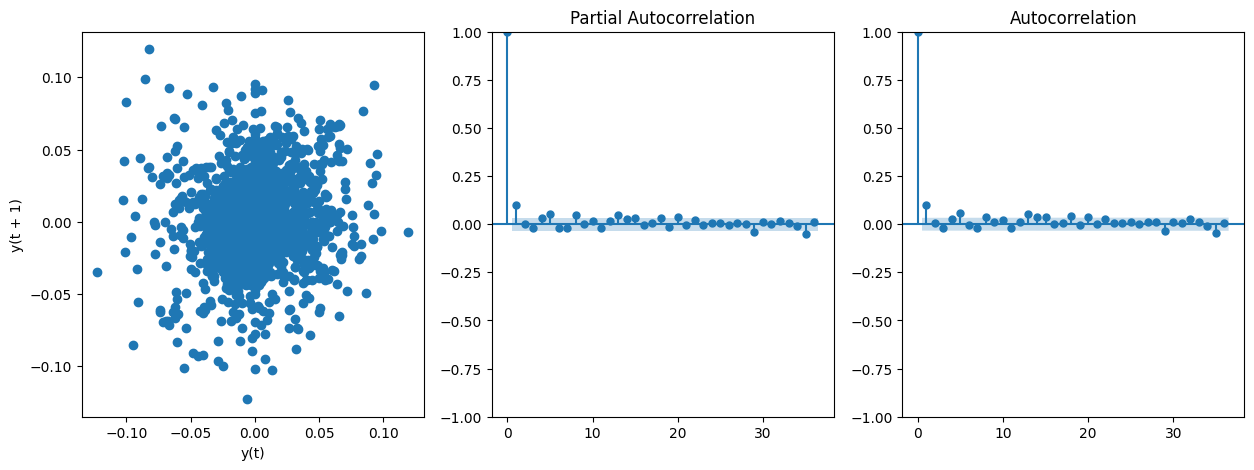

In [34]:
plot_correlation(train_simple_diff)

Based on the two PACF and ACF charts, we can determine that the parameter "p" can be 1 or 2 and the parameter "q" can be 1 or 2.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16965.790, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16944.688, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16976.239, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16975.853, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16946.142, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16974.244, Time=3.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16974.234, Time=3.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16972.238, Time=2.98 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16977.782, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16975.786, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-16975.770, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-16977.387, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16973.781, Time=0.75 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 17.353 sec

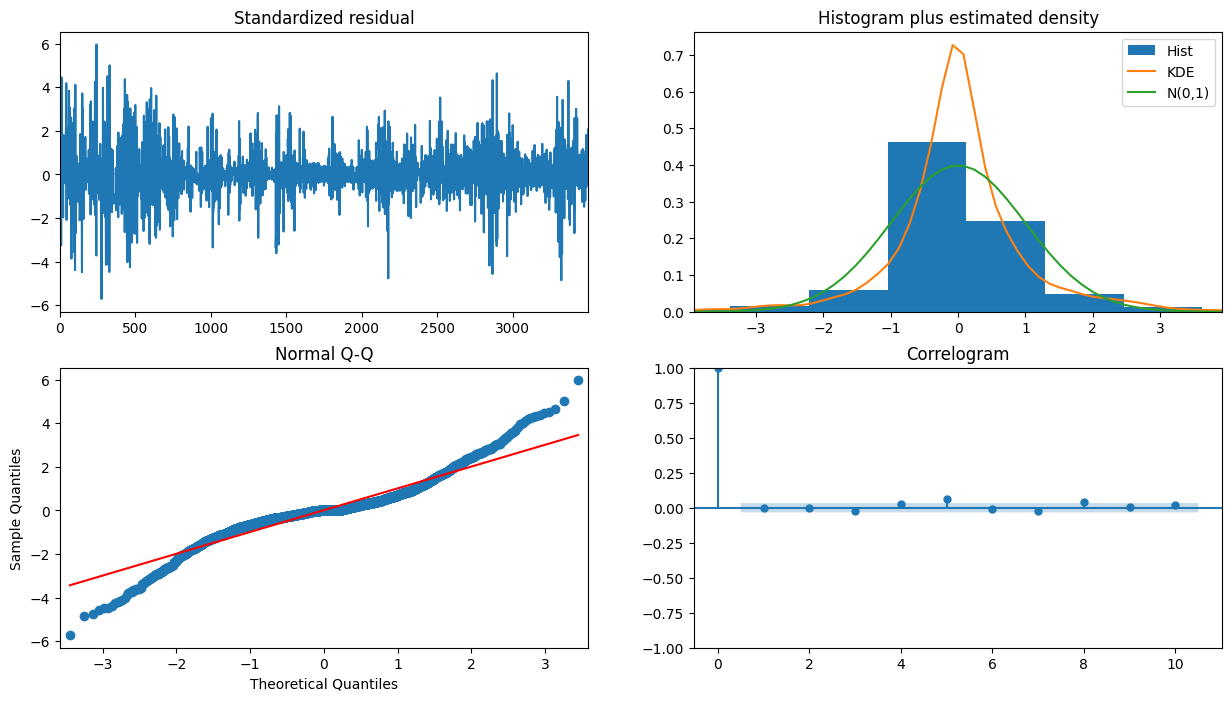

In [35]:
stepwise_fit = auto_arima(train_simple, trace=True, suppress_warnings=True)
print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

Mô hình ARIMA tốt nhất trong trường hợp này được lựa chọn là **ARIMA(1,1,0)**

In [36]:
print (stepwise_fit.order)
print (stepwise_fit.seasonal_order)

(1, 1, 0)
(0, 0, 0, 0)


In [37]:
model = ARIMA(train_simple, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order)
fitted = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


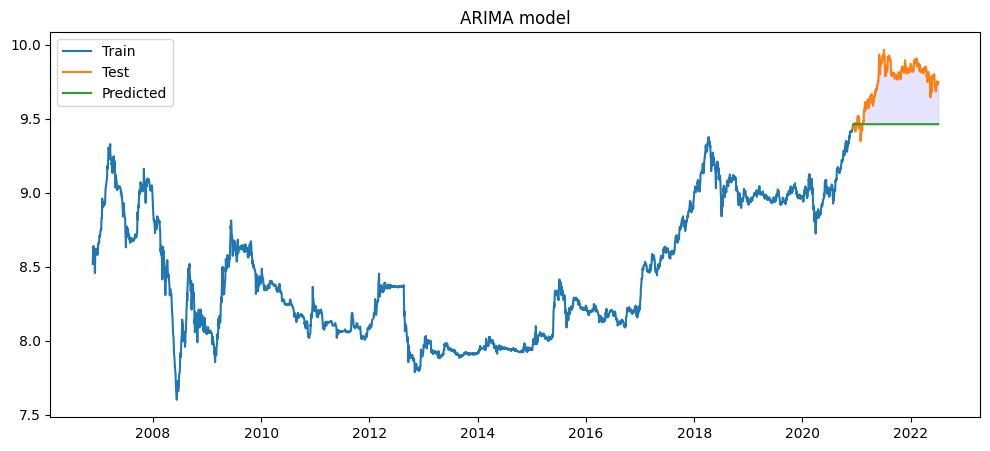

In [38]:
fc_arima = fitted.forecast(len(test_simple)+len(df_val))
fc_arima_test = fitted.forecast(len(test_simple))
fc_arima_val = fitted.forecast(len(df_val))
fc_values_arima = fc_arima
fc_values_arima_test = fc_arima_test
fc_values_arima_val = fc_arima_val
fc_values_arima.index = (test_simple+df_val).index
fc_values_arima_test.index = test_simple.index
fc_values_arima_val.index = df_val.index

# Plot test data
plt.figure(figsize=(12,5))
plt.plot(train_simple, label='Train')
plt.plot(test_simple, label='Test')
plt.plot(fc_values_arima_test, label='Predicted')
plt.fill_between(fc_values_arima_test.index, fc_values_arima_test, test_simple, color='b', alpha=.10)
plt.legend(loc='best')
plt.title('ARIMA model')
plt.show()

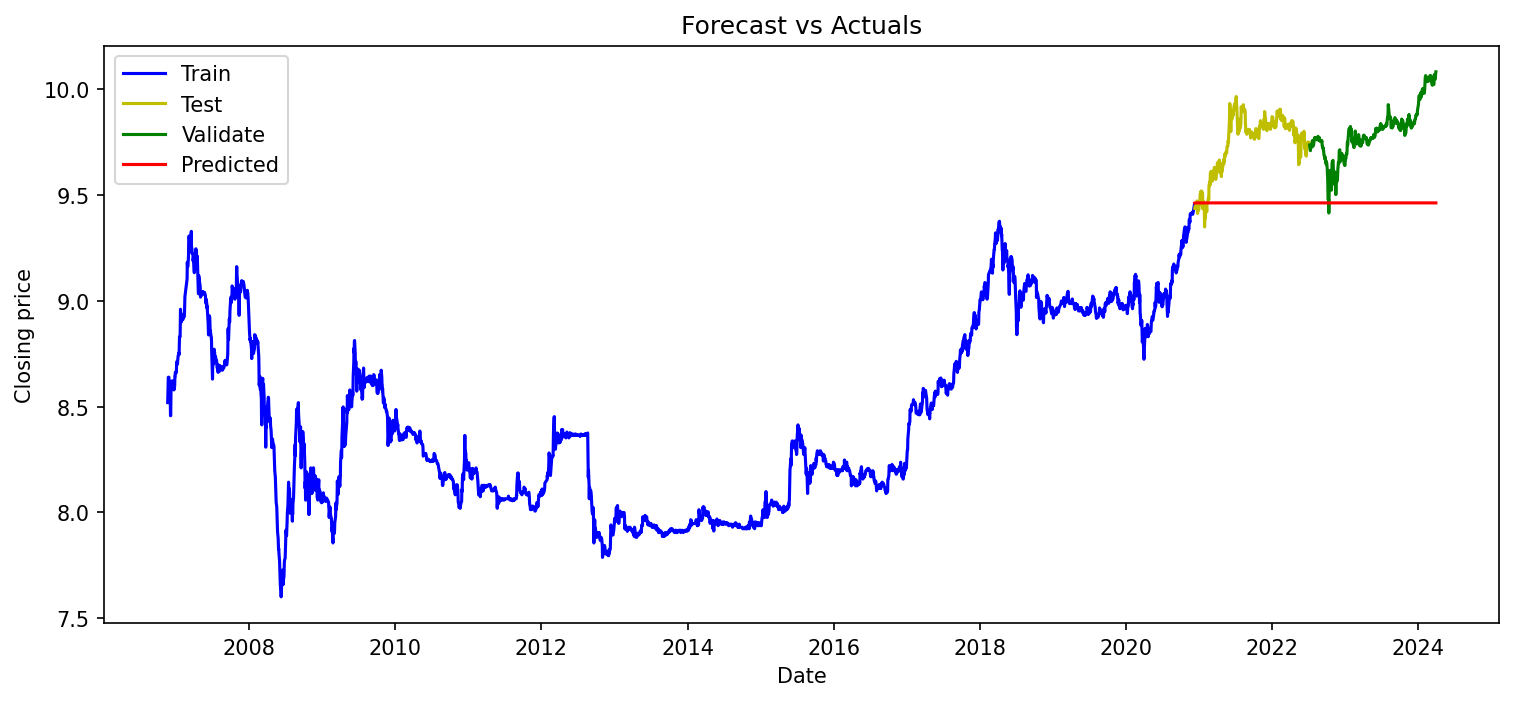

In [39]:
# Plot forecast
plt.figure(figsize=(12, 5), dpi=150)
plt.plot(train_simple, 'b', label='Train')
plt.plot(test_simple, 'y', label='Test')
plt.plot(df_val, 'g', label='Validate')
plt.plot(fc_values_arima, 'r', label='Predicted')
plt.fill_between(fc_values_arima.index, fc_values_arima, test_simple + df_val, color='b', alpha=.10)
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.legend()
plt.show()


In [40]:
rmse = np.sqrt(mean_squared_error(test_simple, fc_values_arima_test))
print('Test RMSE: %.3f' % rmse)

# MAPE
abs_error = np.abs(test_simple - fc_values_arima_test)
mape = np.round(np.mean(abs_error/test_simple),3)
print('Test MAPE: %.3f' % mape)

# MAE
mae = np.mean(np.abs(fc_values_arima_test - test_simple))
print('Test MAE: %.3f' % mae)

# Verify results against validation set
rmse_val = np.sqrt(mean_squared_error(df_val, fc_values_arima_val))
abs_error_val = np.abs(df_val - fc_values_arima_val)
mape_val = np.round(np.mean(abs_error_val/df_val),3)
mae_val = np.mean(np.abs(fc_values_arima_val - df_val))

# Save result
tempResultsDf = pd.DataFrame({'Model':['ARIMA - {} {}'.format(stepwise_fit.order, stepwise_fit.seasonal_order)], 'RMSE': [rmse], 'MAPE': [mape], 'MAE': [mae], 'RMSE_val': [rmse_val], 'MAPE_val': [mape_val], 'MAE_val': [mae_val]})
results = pd.concat([results, tempResultsDf])
print(results)
model_fit.save(f'./ARIMA - {stepwise_fit.order} {stepwise_fit.seasonal_order}.pkl')

Test RMSE: 0.316
Test MAPE: 0.029
Test MAE: 0.289
                            Model      RMSE   MAPE       MAE  RMSE_val  \
0            Auto Regressive (AR)  0.356813  0.033  0.326974  0.400663   
0  ARIMA - (1, 1, 0) (0, 0, 0, 0)  0.316249  0.029  0.289267  0.354676   

   MAPE_val   MAE_val  
0     0.038  0.376015  
0     0.034  0.333641  


## **Split the data using split-multiple cross-validation**

In [41]:
# Multi-partition cross-validation data split function
def mulTsCrossValidation(num, n_splits):
    split_position_lst = []
    for i in range(1, n_splits + 1):
        train_size = i * num // (n_splits + 1) + num % (n_splits + 1)
        test_size = num // (n_splits + 1)
        start = 0
        split = train_size
        end = train_size + test_size
        if end > num:
            end = num
        split_position_lst.append((start, split, end))
    split_position_df = pd.DataFrame(split_position_lst, columns=['start', 'split', 'end'])
    return split_position_df


split_position_df = mulTsCrossValidation(len(df_train_test), 3)
table = split_position_df
table.insert(0, 'No.', range(1, 1 + len(table)))
print(table)

   No.  start  split   end
0    1      0    975  1947
1    2      0   1948  2920
2    3      0   2921  3891


### **AR model**

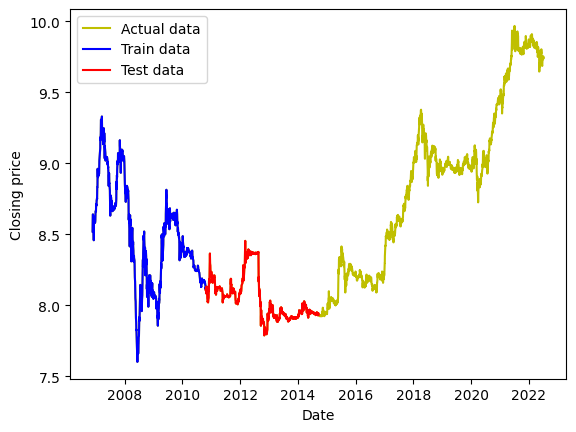

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

The lag order selected is:  [1, 2]
                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                  975
Model:                     AutoReg(2)   Log Likelihood                2052.120
Method:               Conditional MLE   S.D. of innovations              0.029
Date:                Wed, 10 Jul 2024   AIC                          -4096.239
Time:                        09:28:36   BIC                          -4076.718
Sample:                             2   HQIC                         -4088.810
                                  975                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0305      0.022      1.366      0.172      -0.013       0.074
close.L1       1.1716      0.032     37.148      0.000       1.110       1.233
close.L2      -0.

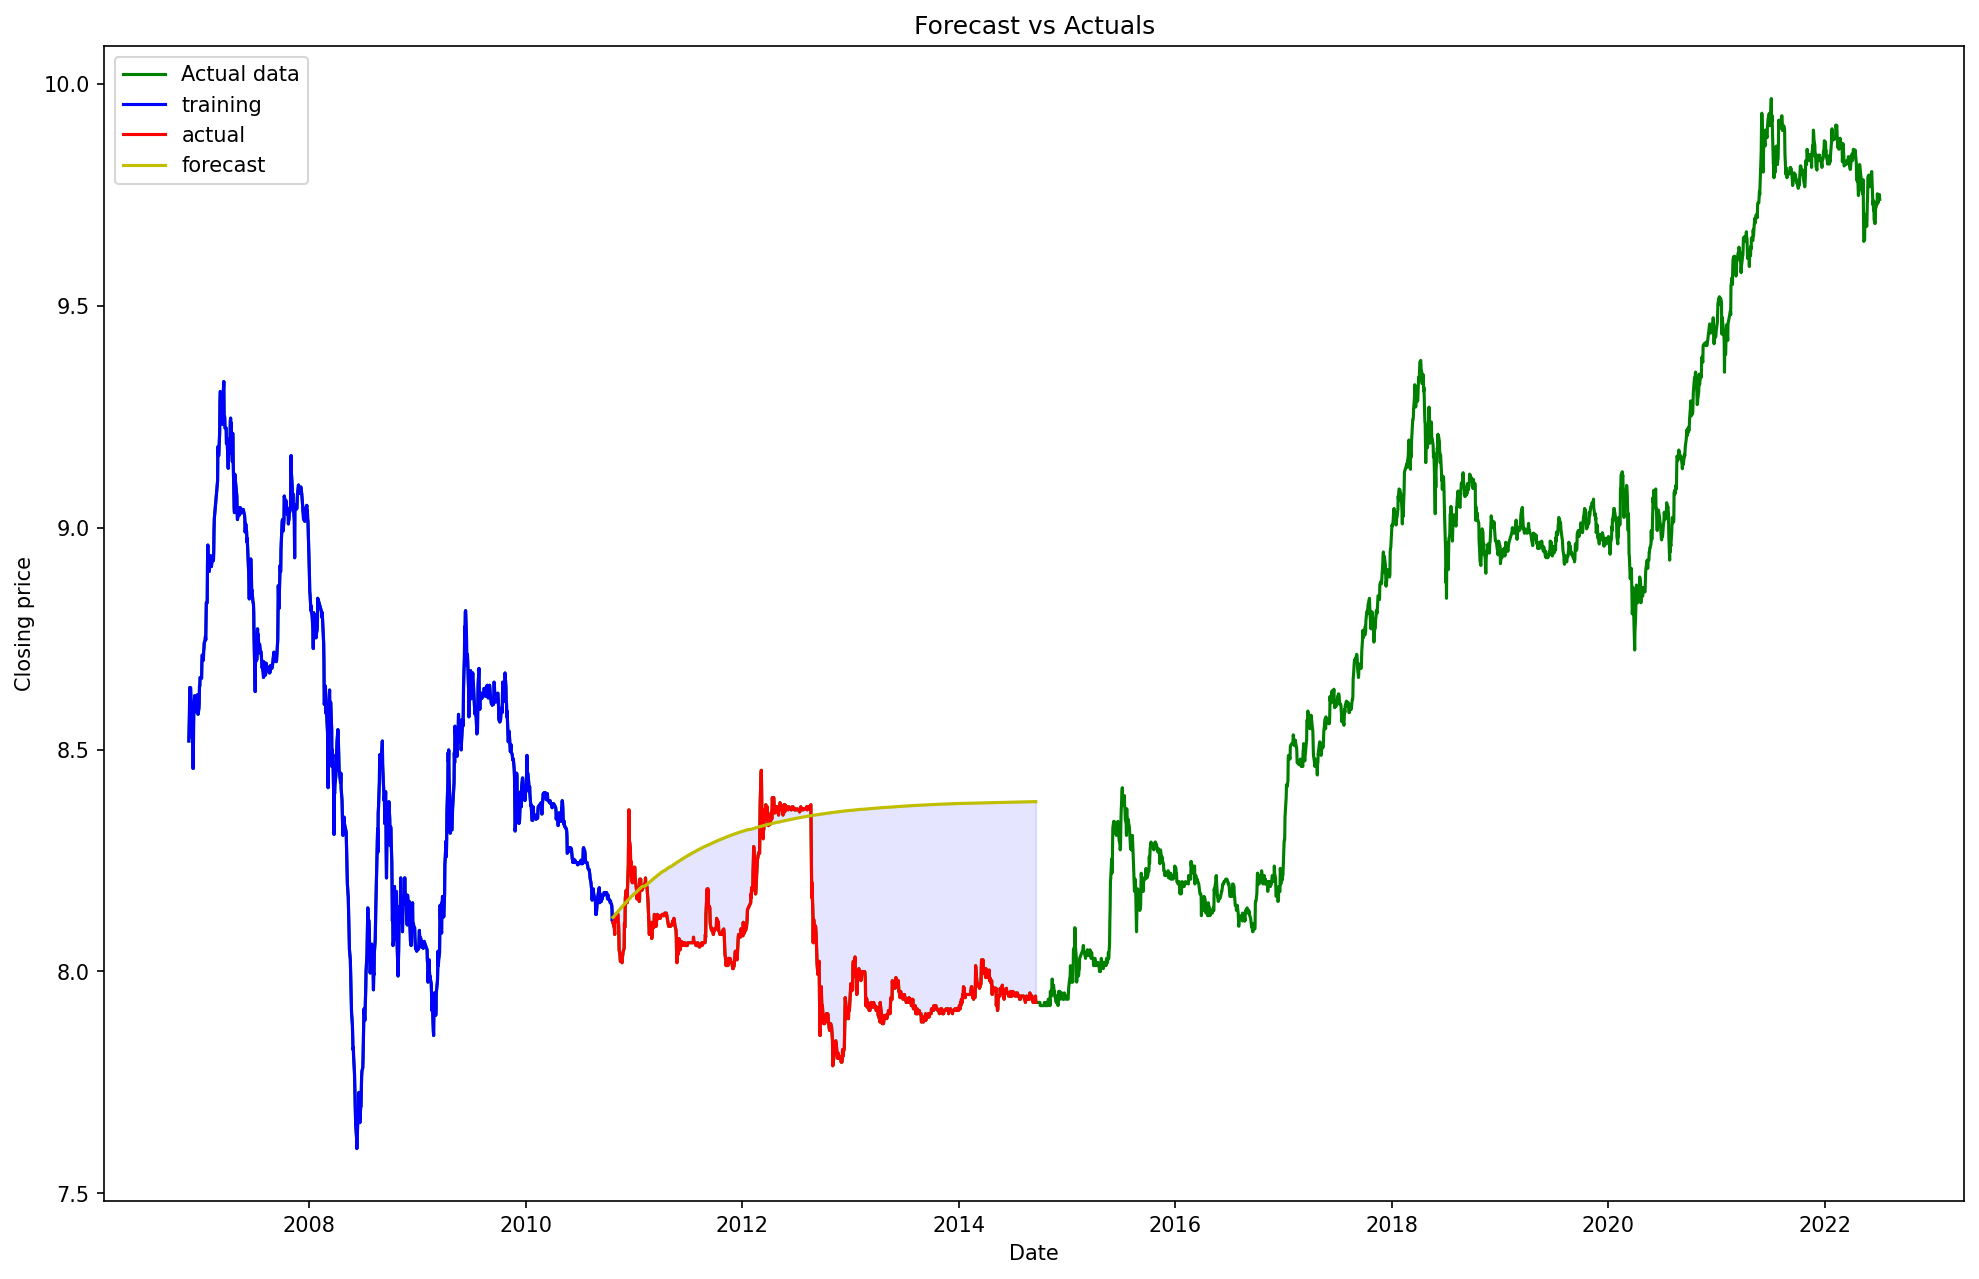

Evaluate:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


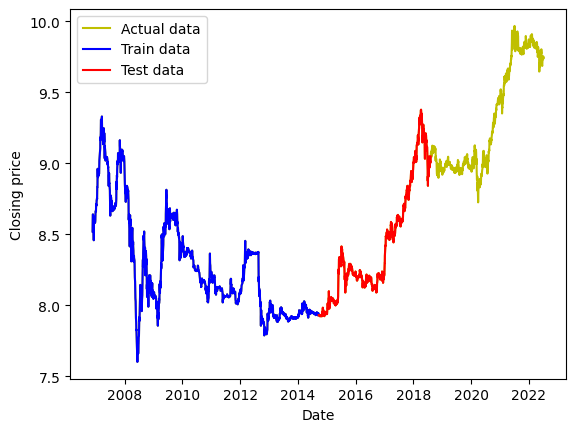

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

The lag order selected is:  [1, 2]
                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                 1948
Model:                     AutoReg(2)   Log Likelihood                4556.823
Method:               Conditional MLE   S.D. of innovations              0.023
Date:                Wed, 10 Jul 2024   AIC                          -9105.647
Time:                        09:28:37   BIC                          -9083.353
Sample:                             2   HQIC                         -9097.450
                                 1948                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0210      0.012      1.697      0.090      -0.003       0.045
close.L1       1.1685      0.022     52.348      0.000       1.125       1.212
close.L2      -0.

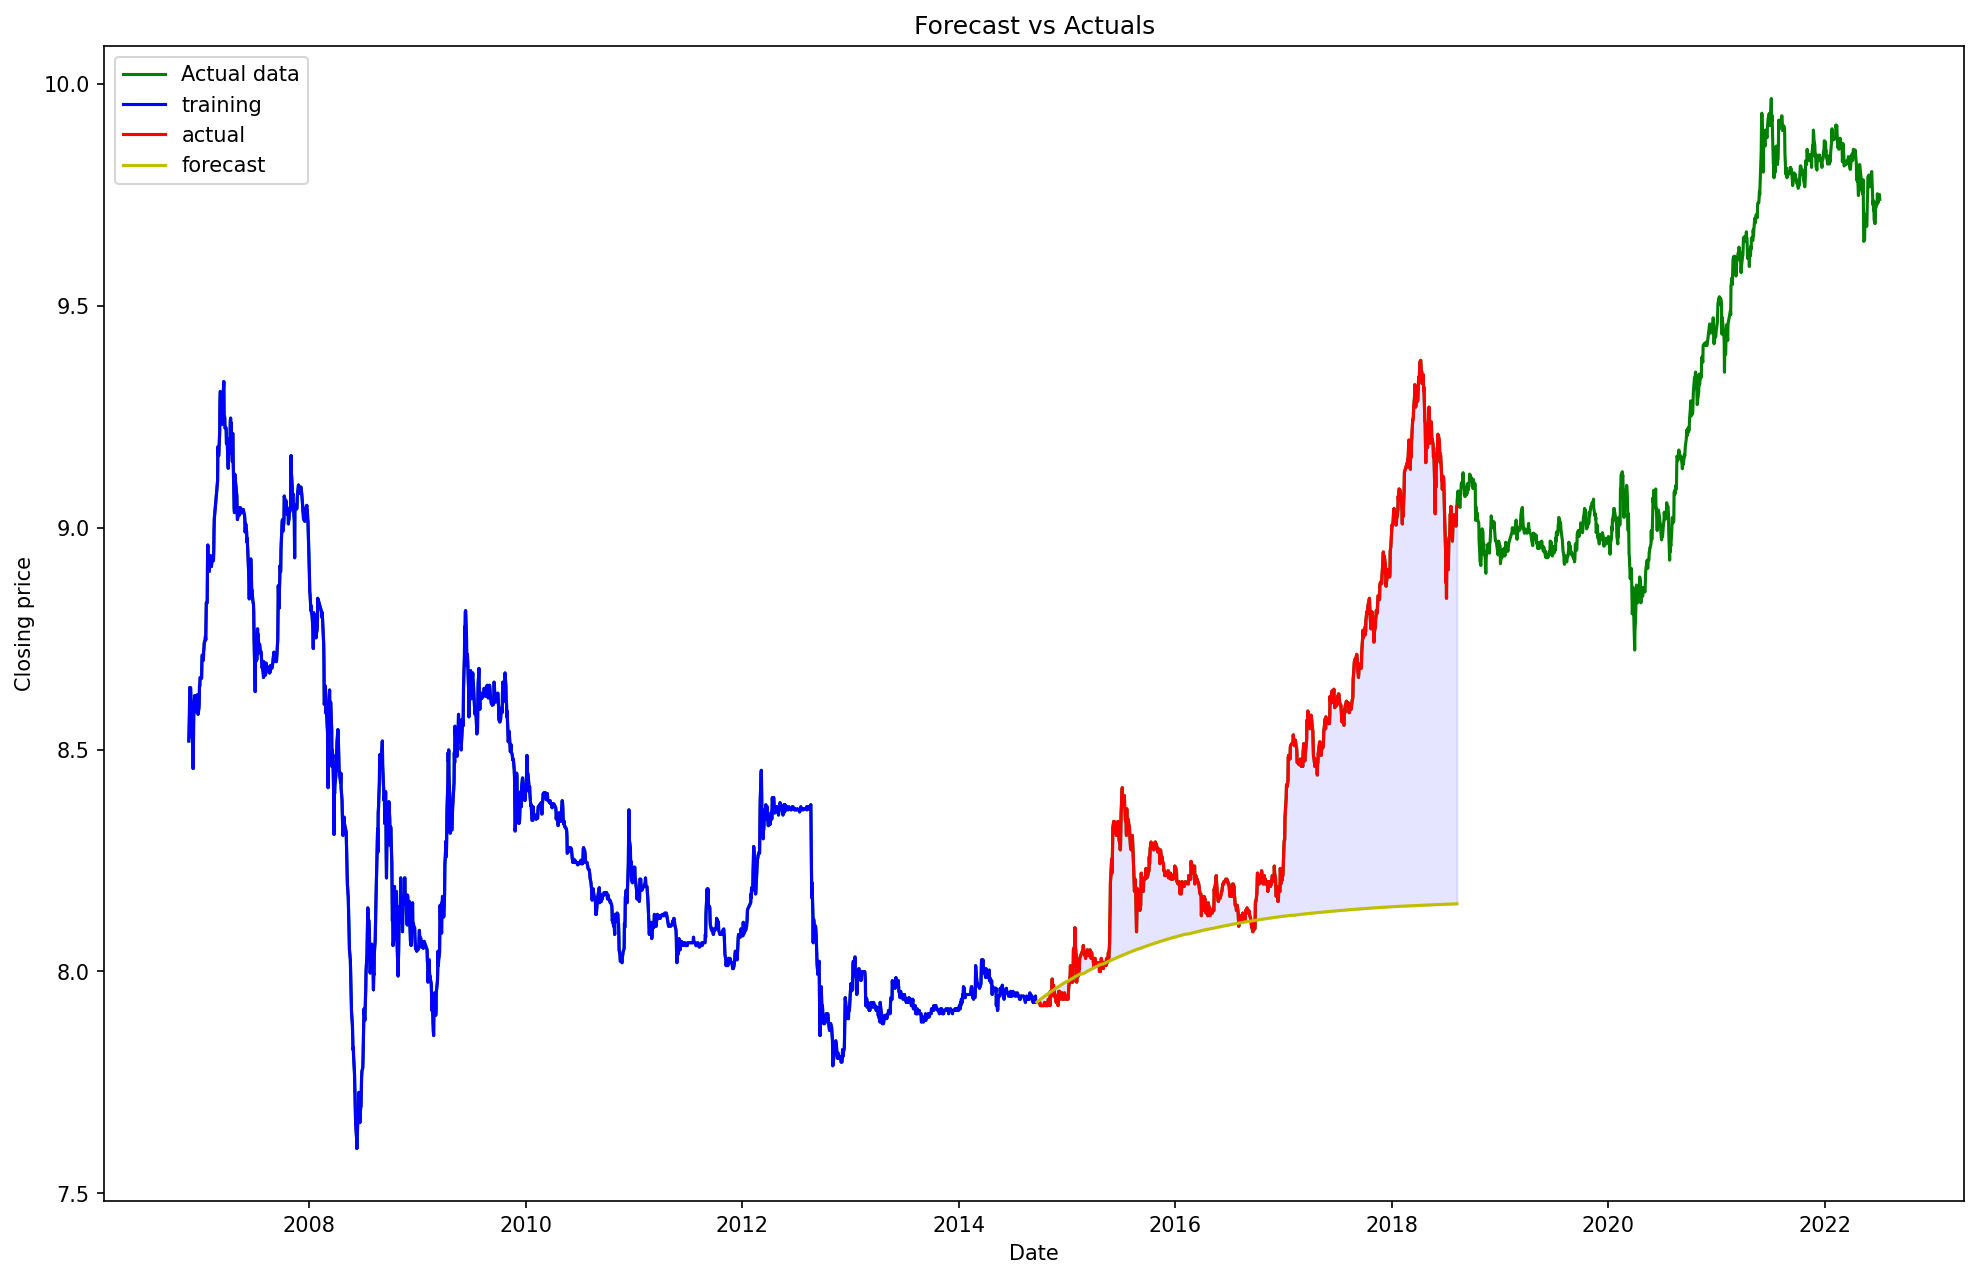

Evaluate:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


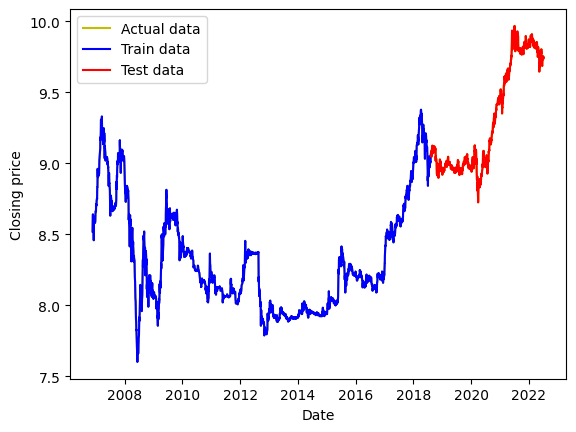

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

The lag order selected is:  [1, 2]
                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                 2921
Model:                     AutoReg(2)   Log Likelihood                7013.895
Method:               Conditional MLE   S.D. of innovations              0.022
Date:                Wed, 10 Jul 2024   AIC                         -14019.789
Time:                        09:28:40   BIC                         -13995.873
Sample:                             2   HQIC                        -14011.175
                                 2921                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.009      1.326      0.185      -0.006       0.030
close.L1       1.1197      0.018     60.968      0.000       1.084       1.156
close.L2      -0.

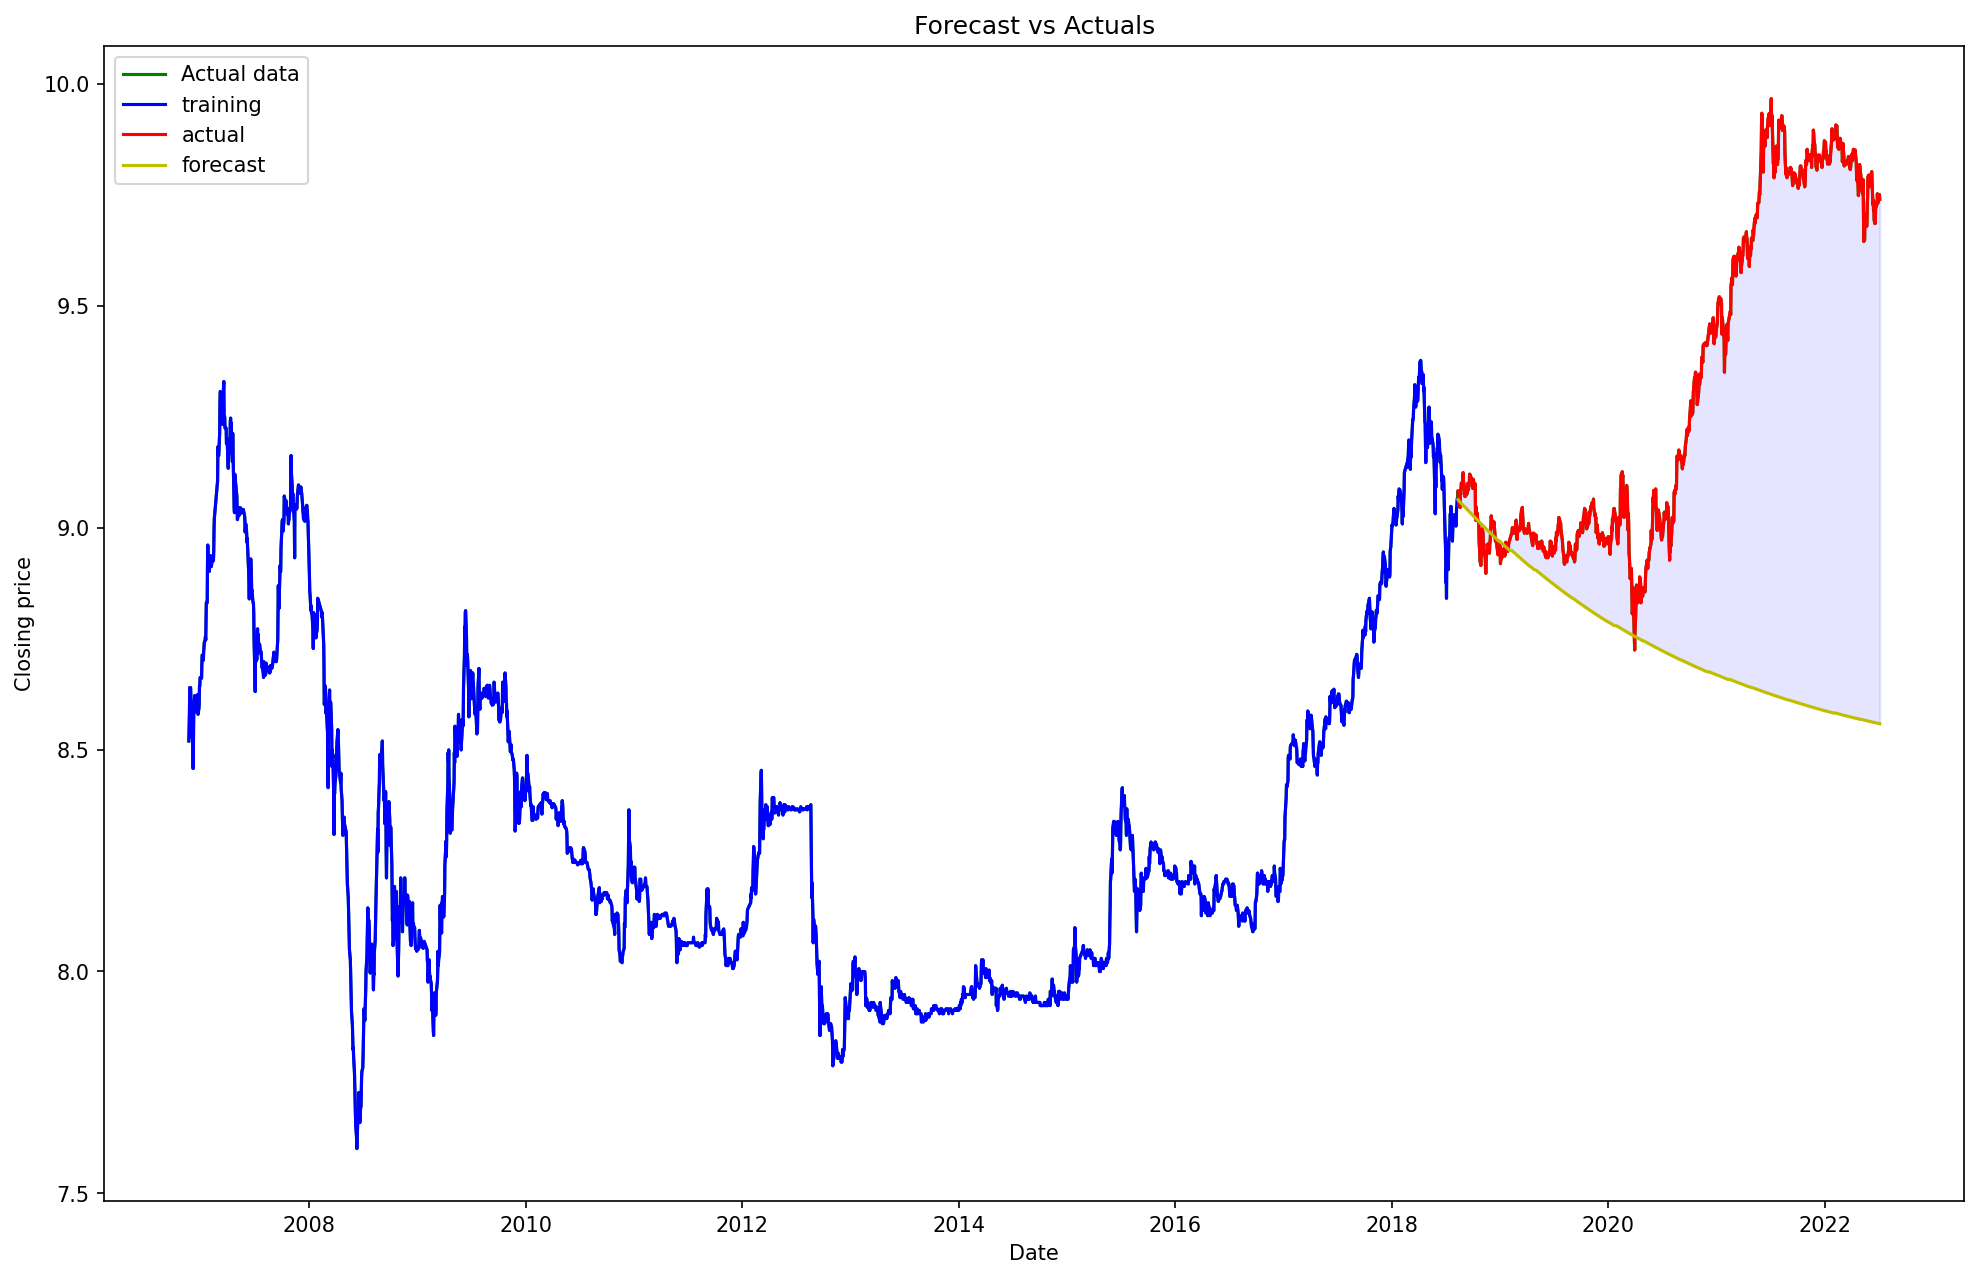

Evaluate:
                            Model      RMSE   MAPE       MAE  RMSE_val  \
0            Auto Regressive (AR)  0.356813  0.033  0.326974  0.400663   
0  ARIMA - (1, 1, 0) (0, 0, 0, 0)  0.316249  0.029  0.289267  0.354676   
0                             NaN  0.336725  0.036  0.286910  1.531255   
0                             NaN  0.479433  0.038  0.335309  1.763741   
0                             NaN  0.756680  0.059  0.571791  0.935535   

   MAPE_val   MAE_val                       Method  
0     0.038  0.376015                          NaN  
0     0.034  0.333641                          NaN  
0     0.156  1.528865  Auto Regressive (AR) 0-1947  
0     0.180  1.761504  Auto Regressive (AR) 0-2920  
0     0.093  0.913276  Auto Regressive (AR) 0-3891  


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [42]:
for i in range(len(split_position_df)):
    start = split_position_df.iloc[i]['start']
    split = split_position_df.iloc[i]['split']
    end = split_position_df.iloc[i]['end']

    # Split dataset
    train_split = df_train_test[start:split]
    test_split = df_train_test[split:end]
    plot_train_test(df_train_test, train_split, test_split)

    # AR model
    models = ar_select_order(train_split, maxlag=30)
    print('The lag order selected is: ', models.ar_lags)
    model = AutoReg(train_split, lags=models.ar_lags, old_names=False)
    model_fit = model.fit()
    print(model_fit.summary())

    # Forecast
    fc = model_fit.forecast(len(test_split))
    fc_values = fc
    fc_values.index = test_split.index

    # Draw plot forecast Actuals data, WindowSlide data, train data, test data, forecast data
    plt.figure(figsize=(16, 10), dpi=150)
    plt.plot(df_train_test, 'g', label='Actual data')
    plt.plot(train_split, 'b', label='training')
    plt.plot(test_split, 'r', label='actual')
    plt.plot(fc_values, 'y', label='forecast')
    plt.fill_between(fc_values.index, fc_values, test_split, color='b', alpha=.10)
    plt.title('Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Closing price')
    plt.legend()
    plt.show()

    # Verify results against test set
    print('Evaluate:')

    rmse = np.sqrt(mean_squared_error(test_split, fc_values))
    abs_error = np.abs(test_split - fc_values)
    mape = np.round(np.mean(abs_error / test_split), 3)
    mae = np.mean(np.abs(fc_values - test_split))

    fc_val = model_fit.forecast(len(df_val))
    fc_values_val = fc_val
    fc_values_val.index = df_val.index

    rmse_val = np.sqrt(mean_squared_error(df_val, fc_values_val))
    abs_error_val = np.abs(df_val - fc_values_val)
    mape_val = np.round(np.mean(abs_error_val / df_val), 3)
    mae_val = np.mean(np.abs(fc_values_val - df_val))

    # Save results into DataFrame
    tempResultsDf = pd.DataFrame({'Method':[f'Auto Regressive (AR) {start}-{end}'], 'RMSE': [rmse], 'MAPE': [mape], 'MAE': [mae], 'RMSE_val': [rmse_val], 'MAPE_val': [mape_val], 'MAE_val': [mae_val]})
    results = pd.concat([results, tempResultsDf])

    # model_fit.save(f'./Auto Regressive (AR) {start}-{end}.pkl')

print(results)

### **ARIMA Model**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4109.185, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4072.421, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4100.079, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4102.926, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4074.237, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4098.928, Time=0.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4100.067, Time=0.94 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4113.881, Time=2.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4099.388, Time=1.92 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-4104.337, Time=4.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-4113.703, Time=2.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4112.704, Time=2.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-4106.112, Time=2.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-4111.861, Time=3.57 sec
 ARIMA(3,1,2)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  975
Model:                 ARIMA(3, 1, 3)   Log Likelihood                2065.082
Date:                Wed, 10 Jul 2024   AIC                          -4116.165
Time:                        09:29:24   BIC                          -4081.995
Sample:                             0   HQIC                         -4103.161
                                - 975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9083      0.148      6.153      0.000       0.619       1.198
ar.L2         -0.9852      0.068    -14.433      0.000      -1.119      -0.851
ar.L3          0.5337      0.118      4.522      0.0

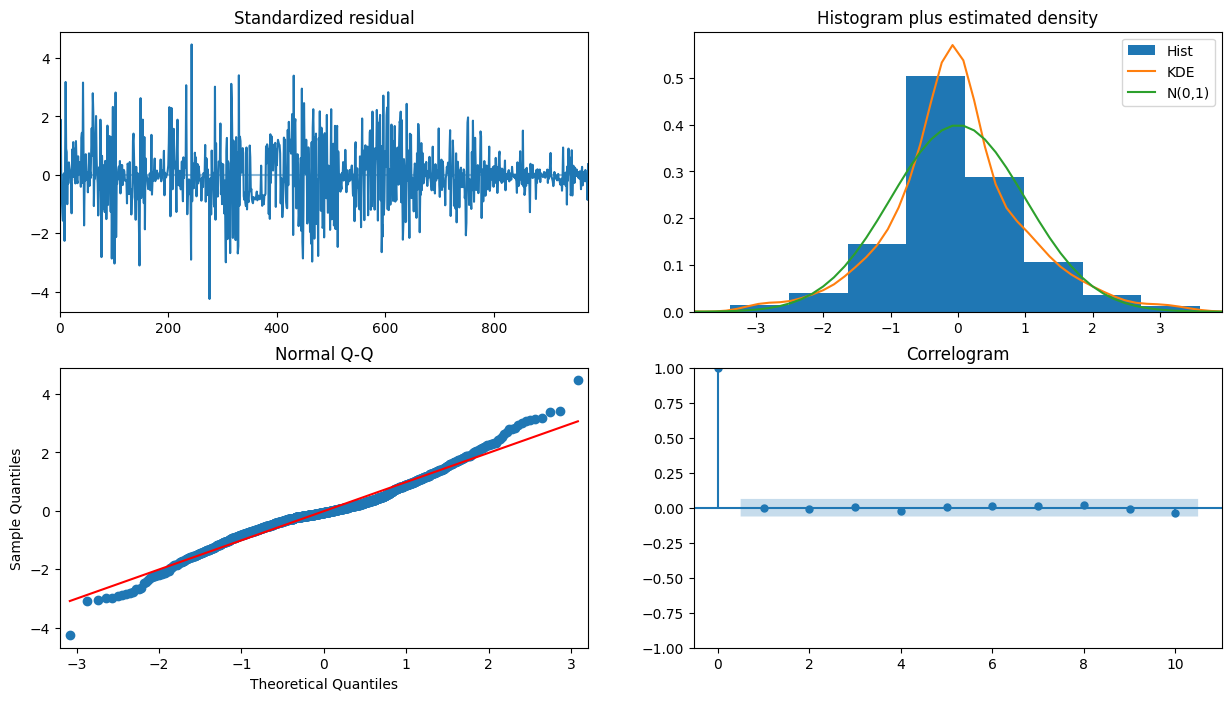

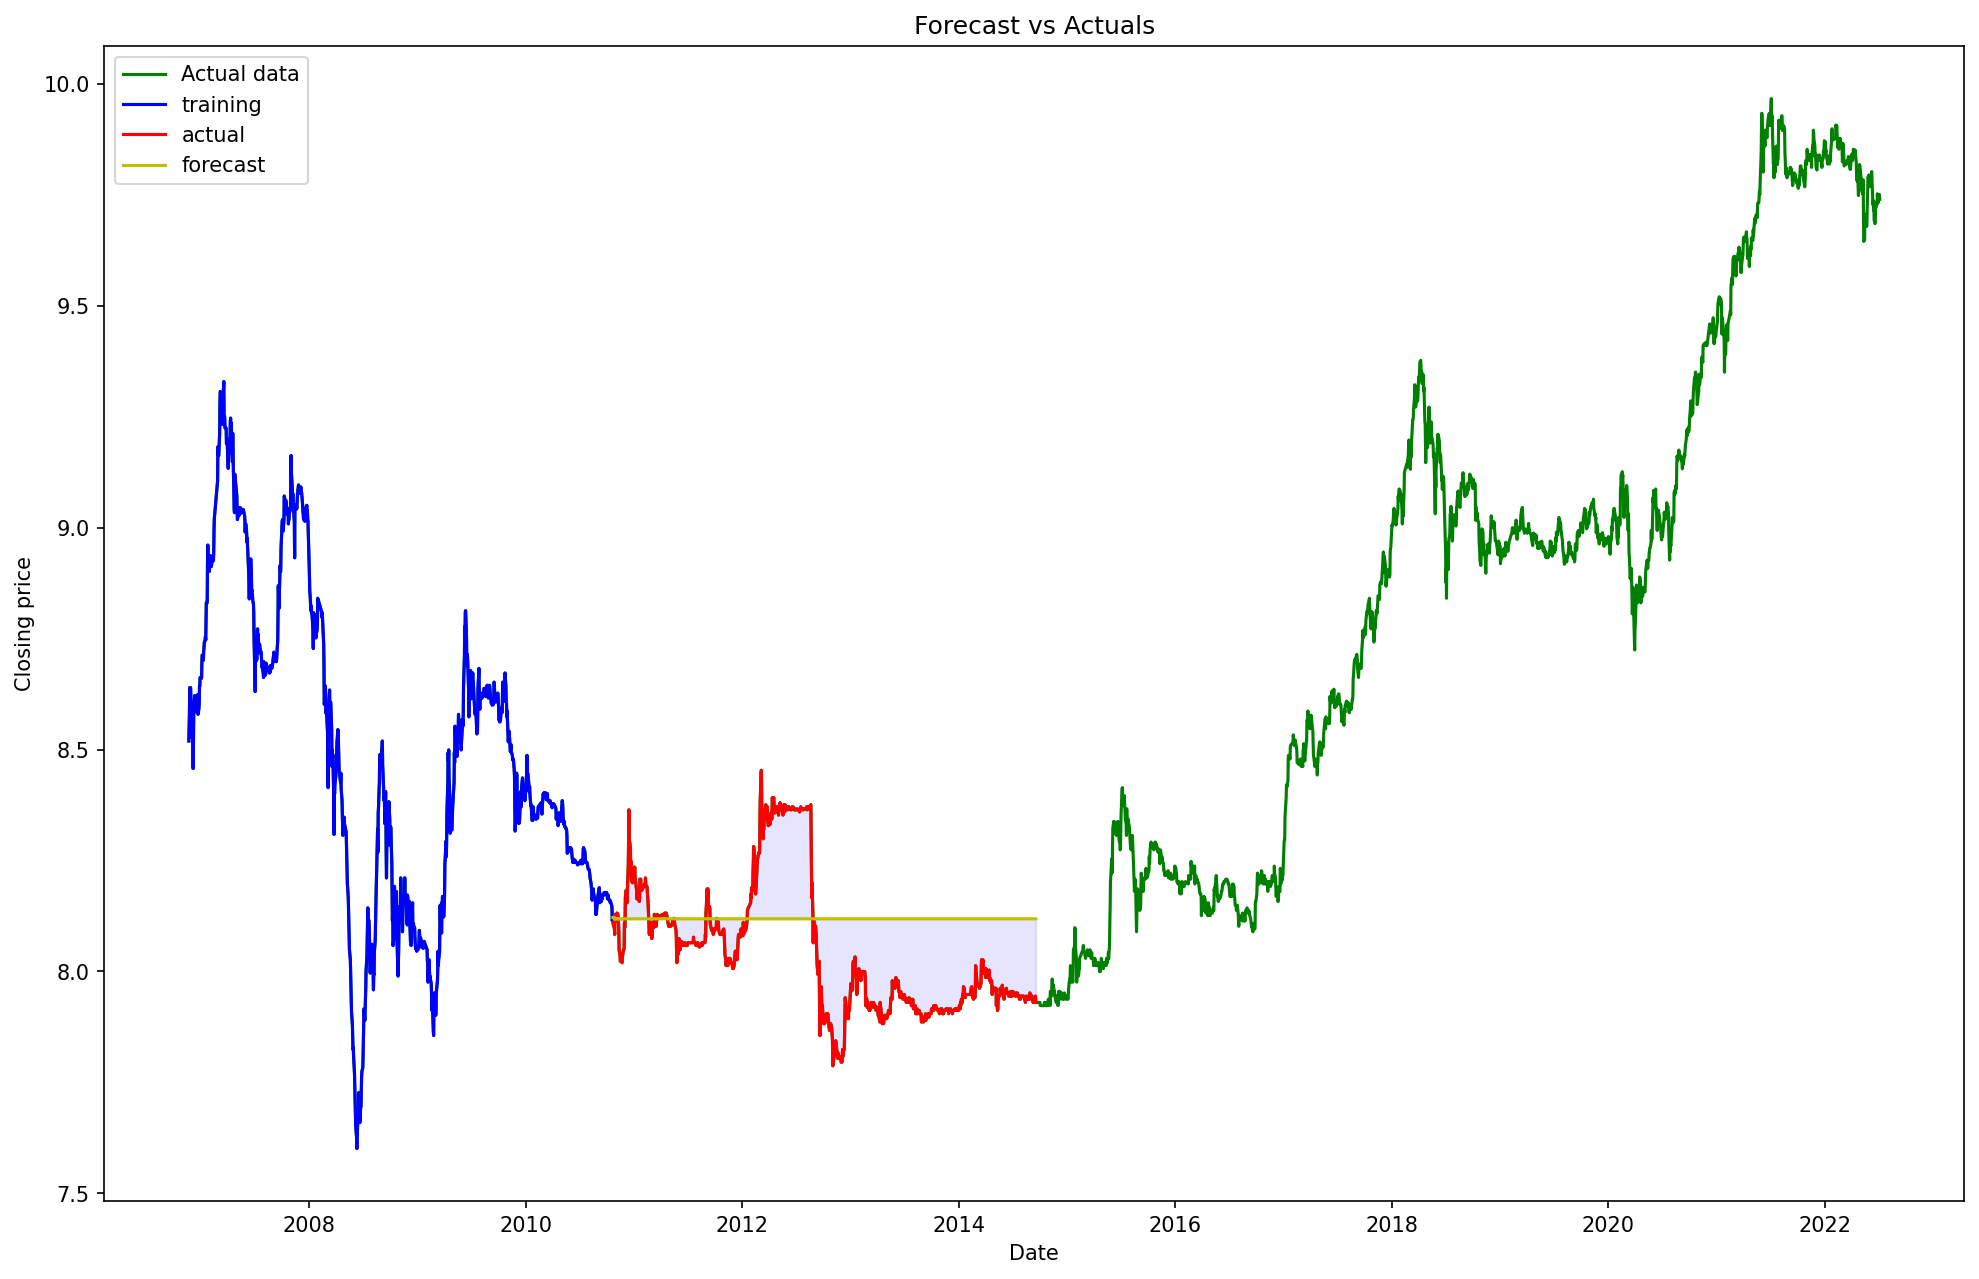

Evaluate:
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9109.003, Time=2.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9053.154, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9108.070, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9113.858, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9054.835, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9112.792, Time=1.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9113.048, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9109.966, Time=2.93 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-9115.537, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-9114.303, Time=0.90 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-9114.806, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-9109.849, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-9111.746, Time=0.72 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 12.815 seconds
                               SARIMAX Results     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1948
Model:                 ARIMA(0, 1, 1)   Log Likelihood                4559.768
Date:                Wed, 10 Jul 2024   AIC                          -9115.537
Time:                        09:29:39   BIC                          -9104.389
Sample:                             0   HQIC                         -9111.438
                               - 1948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1789      0.014     12.677      0.000       0.151       0.207
sigma2         0.0005   1.01e-05     53.432      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


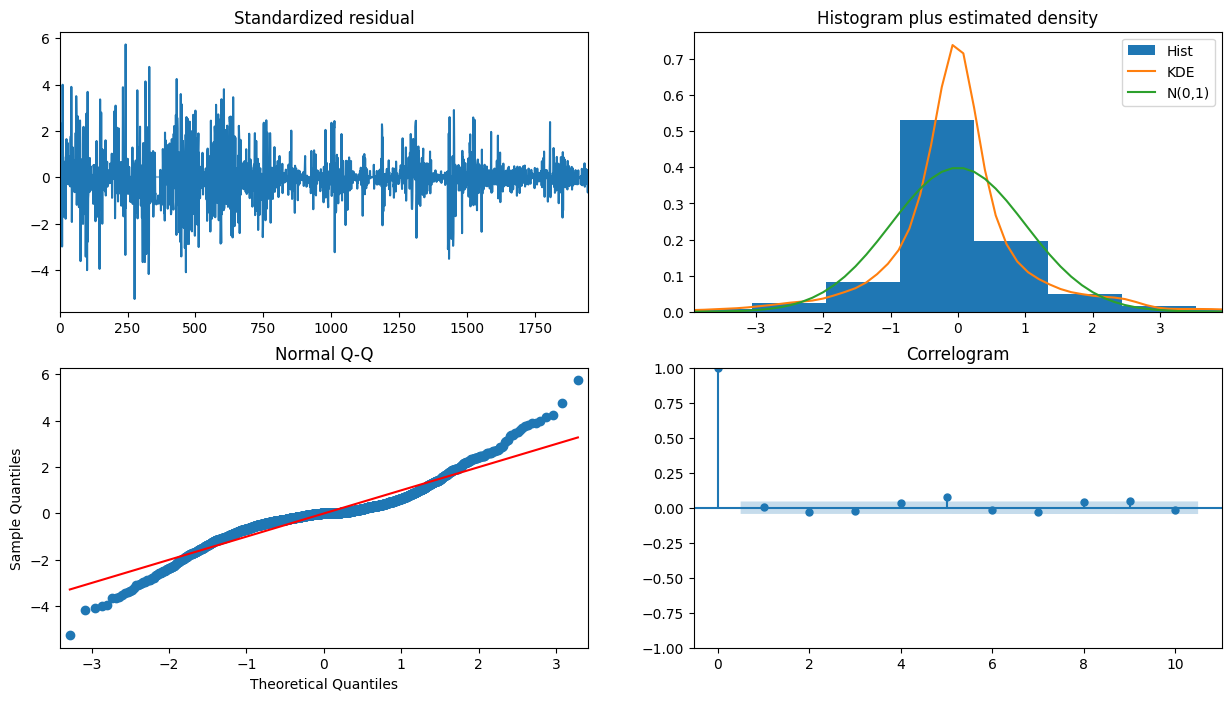

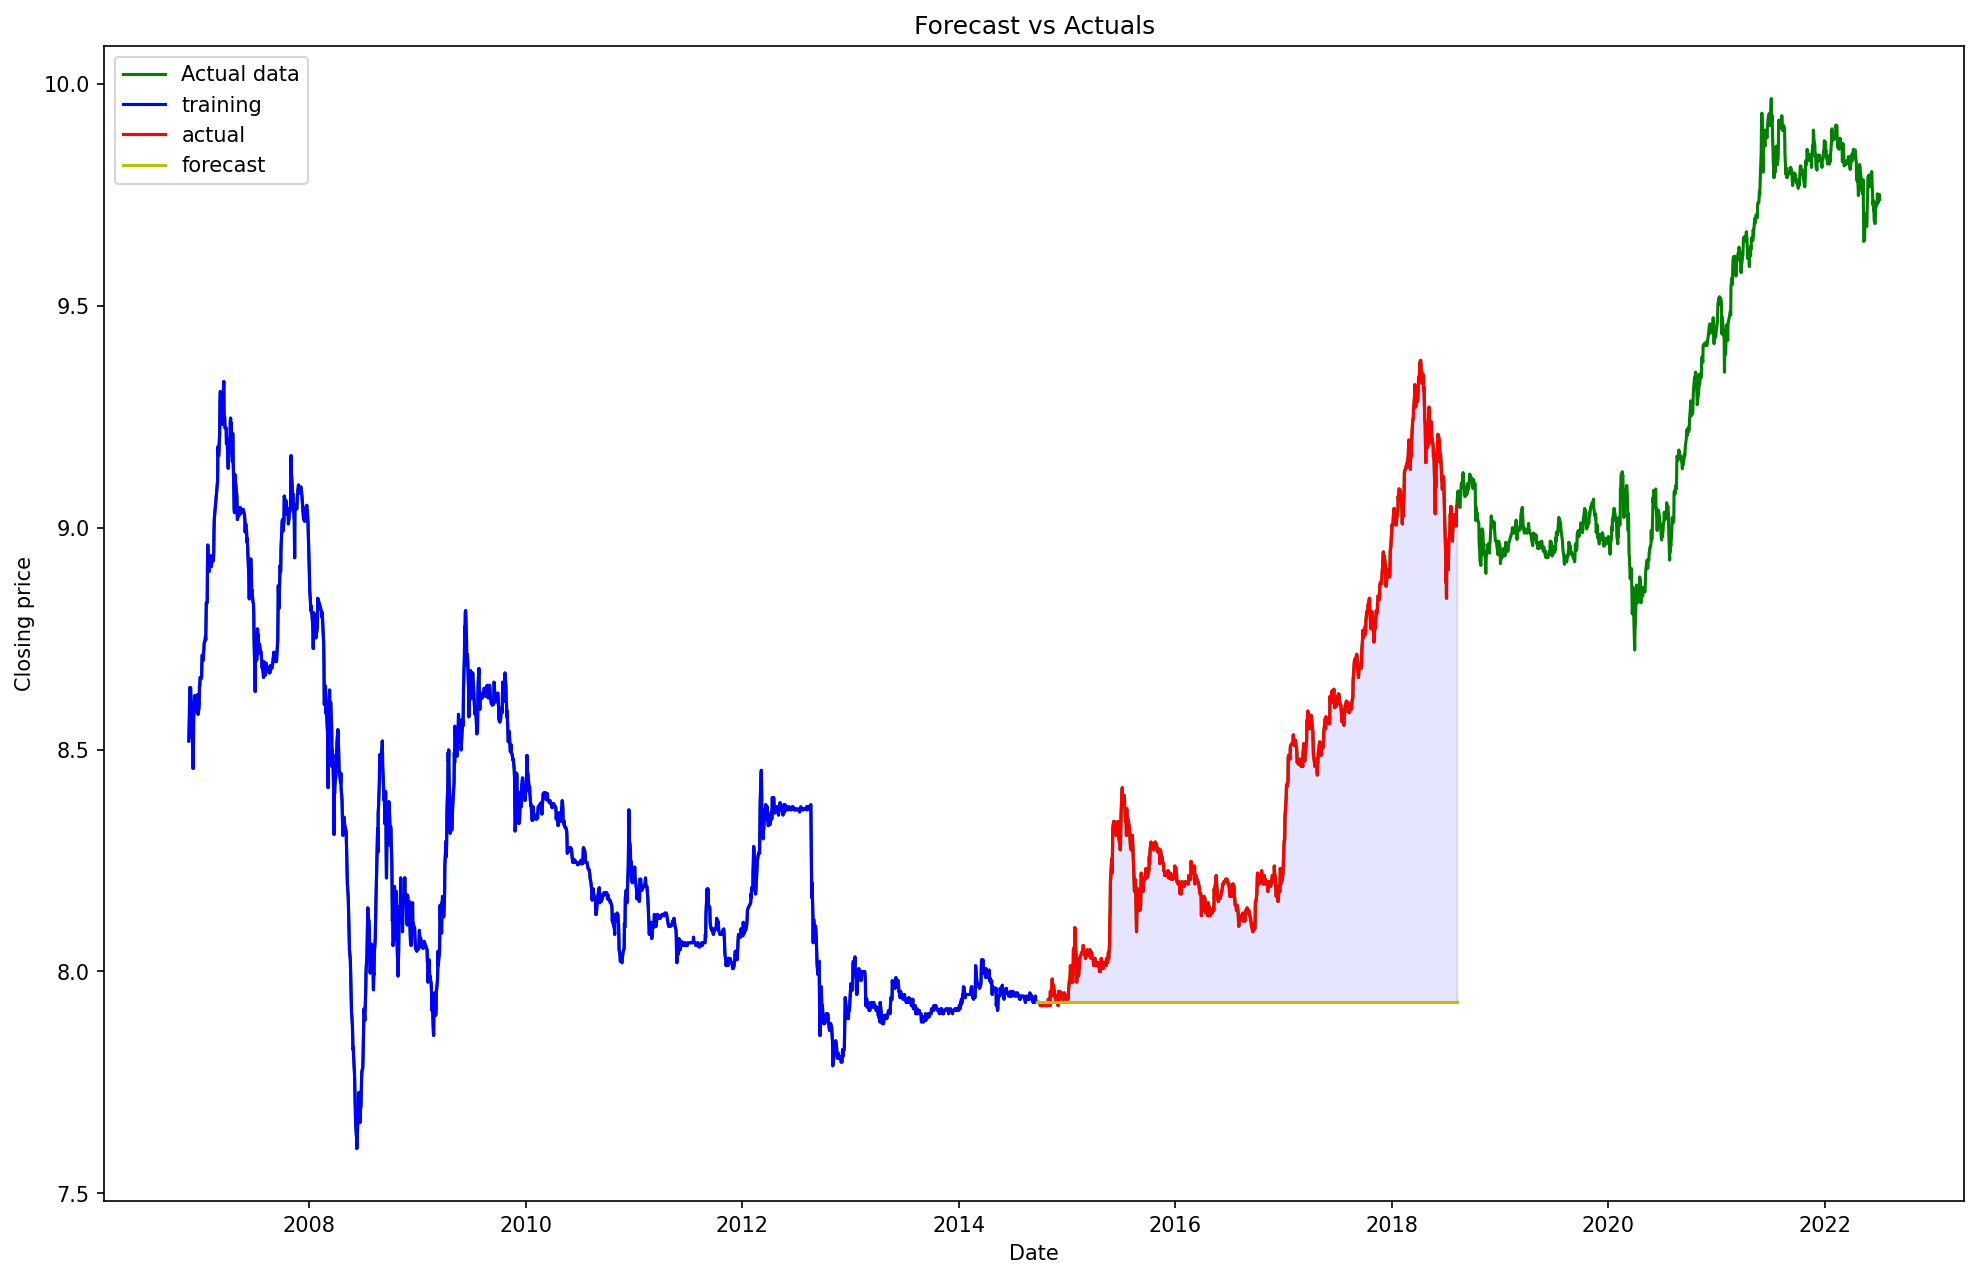

Evaluate:
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14018.229, Time=4.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13982.817, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14023.328, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14023.708, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13984.609, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14021.742, Time=1.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14021.823, Time=2.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14020.091, Time=3.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14025.536, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14023.568, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-14023.610, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-14025.161, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-14021.685, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 14.742 seconds
                               SARIMAX

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2921
Model:                 ARIMA(0, 1, 1)   Log Likelihood                7014.768
Date:                Wed, 10 Jul 2024   AIC                         -14025.536
Time:                        09:29:56   BIC                         -14013.577
Sample:                             0   HQIC                        -14021.228
                               - 2921                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1203      0.011     10.841      0.000       0.099       0.142
sigma2         0.0005   7.13e-06     67.286      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


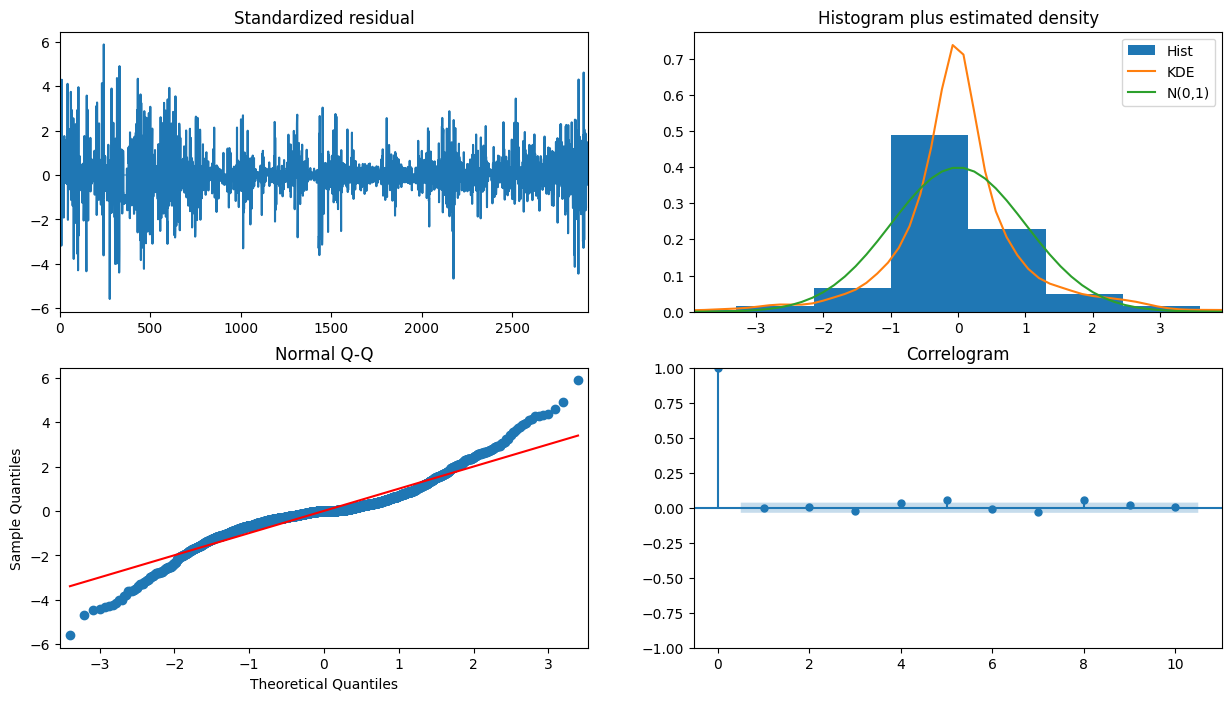

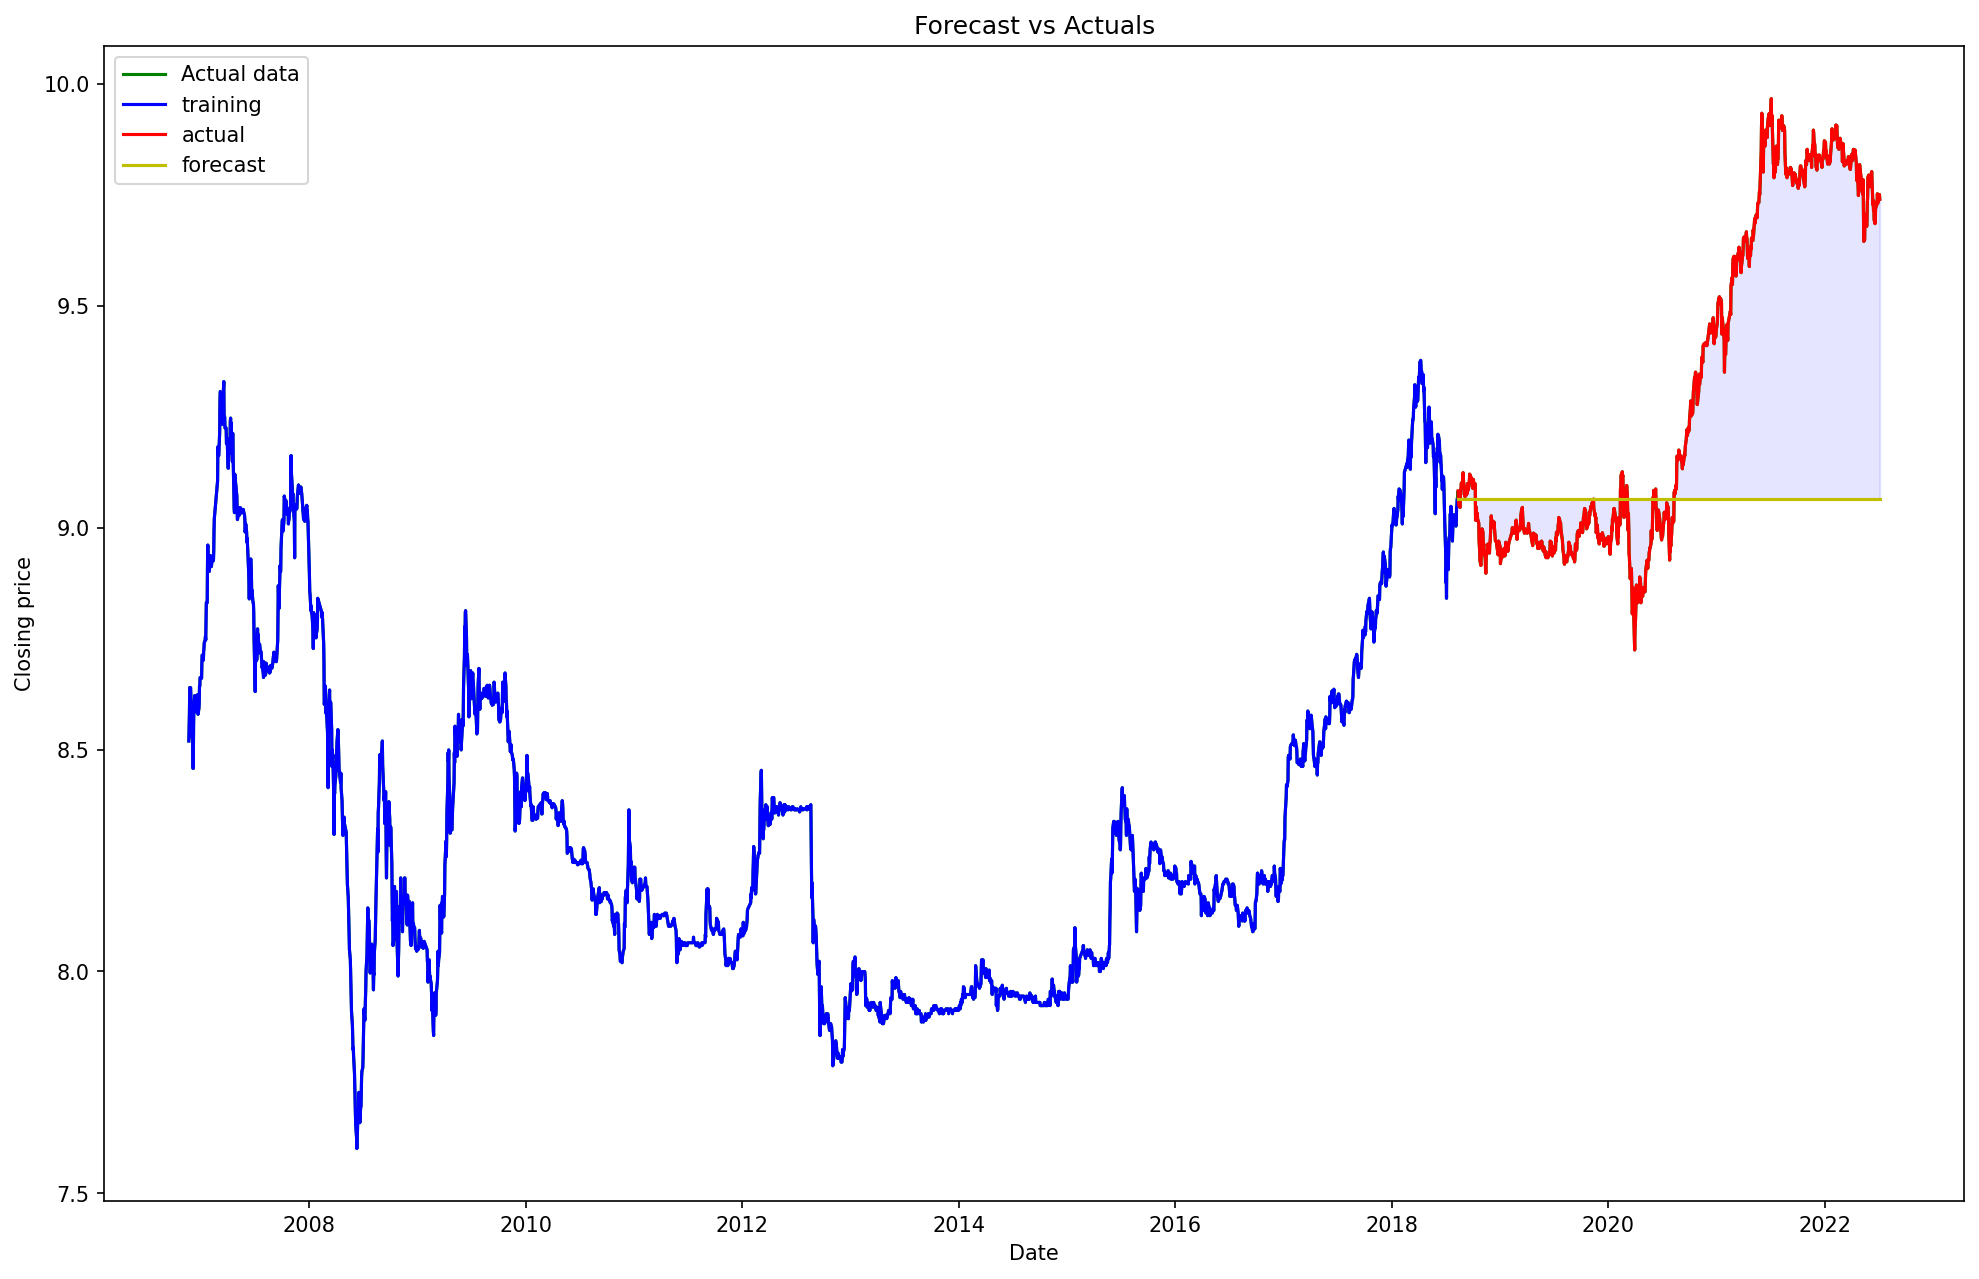

Evaluate:
                            Model      RMSE   MAPE       MAE  RMSE_val  \
0            Auto Regressive (AR)  0.356813  0.033  0.326974  0.400663   
0  ARIMA - (1, 1, 0) (0, 0, 0, 0)  0.316249  0.029  0.289267  0.354676   
0                             NaN  0.336725  0.036  0.286910  1.531255   
0                             NaN  0.479433  0.038  0.335309  1.763741   
0                             NaN  0.756680  0.059  0.571791  0.935535   
0                             NaN  0.168930  0.018  0.146936  1.682785   
0                             NaN  0.626633  0.056  0.491884  1.870242   
0                             NaN  0.453204  0.035  0.335485  0.743379   

   MAPE_val   MAE_val                                 Method  
0     0.038  0.376015                                    NaN  
0     0.034  0.333641                                    NaN  
0     0.156  1.528865            Auto Regressive (AR) 0-1947  
0     0.180  1.761504            Auto Regressive (AR) 0-2920  
0     0.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [43]:
# Create DataFrame to save results

for i in range(len(split_position_df)):
    start = split_position_df.iloc[i]['start']
    split = split_position_df.iloc[i]['split']
    end = split_position_df.iloc[i]['end']

    train_split = df_train_test[start:split]
    test_split = df_train_test[split:end]

    # P, D, Q
    stepwise_fit = auto_arima(train_split, trace=True, suppress_warnings=True)
    print(stepwise_fit.summary())
    stepwise_fit.plot_diagnostics(figsize=(15, 8))
    order = stepwise_fit.order
    seasonal_order = stepwise_fit.seasonal_order

    model = ARIMA(train_split, order=order, seasonal_order=seasonal_order)
    fitted = model.fit()
    print(fitted.summary())

    # Forecast
    fc = fitted.forecast(len(test_split))
    fc_values = fc
    fc_values.index = test_split.index

    # Draw forecast Actuals data, WindowSlide data, train data, test data, forecast data
    plt.figure(figsize=(16, 10), dpi=150)
    plt.plot(df_train_test, 'g', label='Actual data')
    plt.plot(train_split, 'b', label='training')
    plt.plot(test_split, 'r', label='actual')
    plt.plot(fc_values, 'y', label='forecast')
    plt.fill_between(fc_values.index, fc_values, test_split, color='b', alpha=.10)
    plt.title('Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Closing price')
    plt.legend()
    plt.show()

    # Verify results against test set
    print('Evaluate:')
    rmse = np.sqrt(mean_squared_error(test_split, fc_values))
    abs_error = np.abs(test_split - fc_values)
    mape = np.round(np.mean(abs_error / test_split), 3)
    mae = np.mean(np.abs(fc_values - test_split))

    fc_val = fitted.forecast(len(df_val))
    fc_values_val = fc_val
    fc_values_val.index = df_val.index

    rmse_val = np.sqrt(mean_squared_error(df_val, fc_values_val))
    abs_error_val = np.abs(df_val - fc_values_val)
    mape_val = np.round(np.mean(abs_error_val / df_val), 3)
    mae_val = np.mean(np.abs(fc_values_val - df_val))

    # Save result into DataFrame
    tempResultsDf = pd.DataFrame({'Method':[f'ARIMA - {order} {seasonal_order} {start}-{end}'], 'RMSE': [rmse], 'MAPE': [mape], 'MAE': [mae], 'RMSE_val': [rmse_val], 'MAPE_val': [mape_val], 'MAE_val': [mae_val]})
    results = pd.concat([results, tempResultsDf])
    # fitted.save(f'./ARIMA - {order} {seasonal_order} {start}-{end}.pkl')

print(results)

## **Split the data using sliding window cross validation**

In [44]:
# Sliding window cross validation data split function
def slideWindowTsCrossValidation(num, n_splits):
    kfold_size = num // n_splits

    split_position_lst = []
    for i in range(n_splits):
        start = i * kfold_size
        end = start + kfold_size
        split = int(0.8 * (end - start)) + start
        split_position_lst.append((start, split, end))

    split_position_df = pd.DataFrame(split_position_lst, columns=['start', 'split', 'end'])
    return split_position_df
split_position_df = slideWindowTsCrossValidation(len(df_train_test), 3)
table = split_position_df
table.insert(0, 'No.', range(1, 1 + len(table)))
print(table)

   No.  start  split   end
0    1      0   1037  1297
1    2   1297   2334  2594
2    3   2594   3631  3891


### **AR Model**

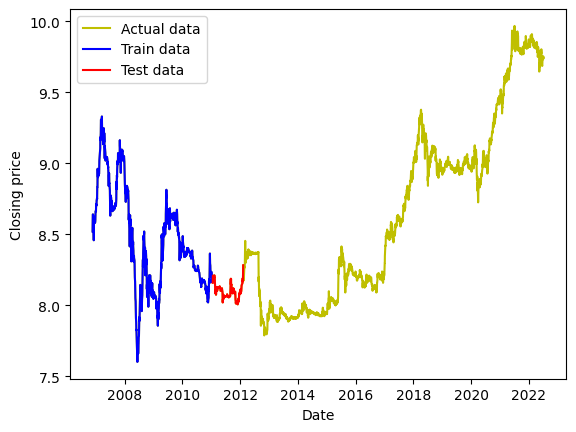

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

The lag order selected is:  [1, 2]
                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                 1037
Model:                     AutoReg(2)   Log Likelihood                2194.907
Method:               Conditional MLE   S.D. of innovations              0.029
Date:                Wed, 10 Jul 2024   AIC                          -4381.813
Time:                        09:29:57   BIC                          -4362.045
Sample:                             2   HQIC                         -4374.313
                                 1037                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0313      0.021      1.465      0.143      -0.011       0.073
close.L1       1.1729      0.031     38.362      0.000       1.113       1.233
close.L2      -0.

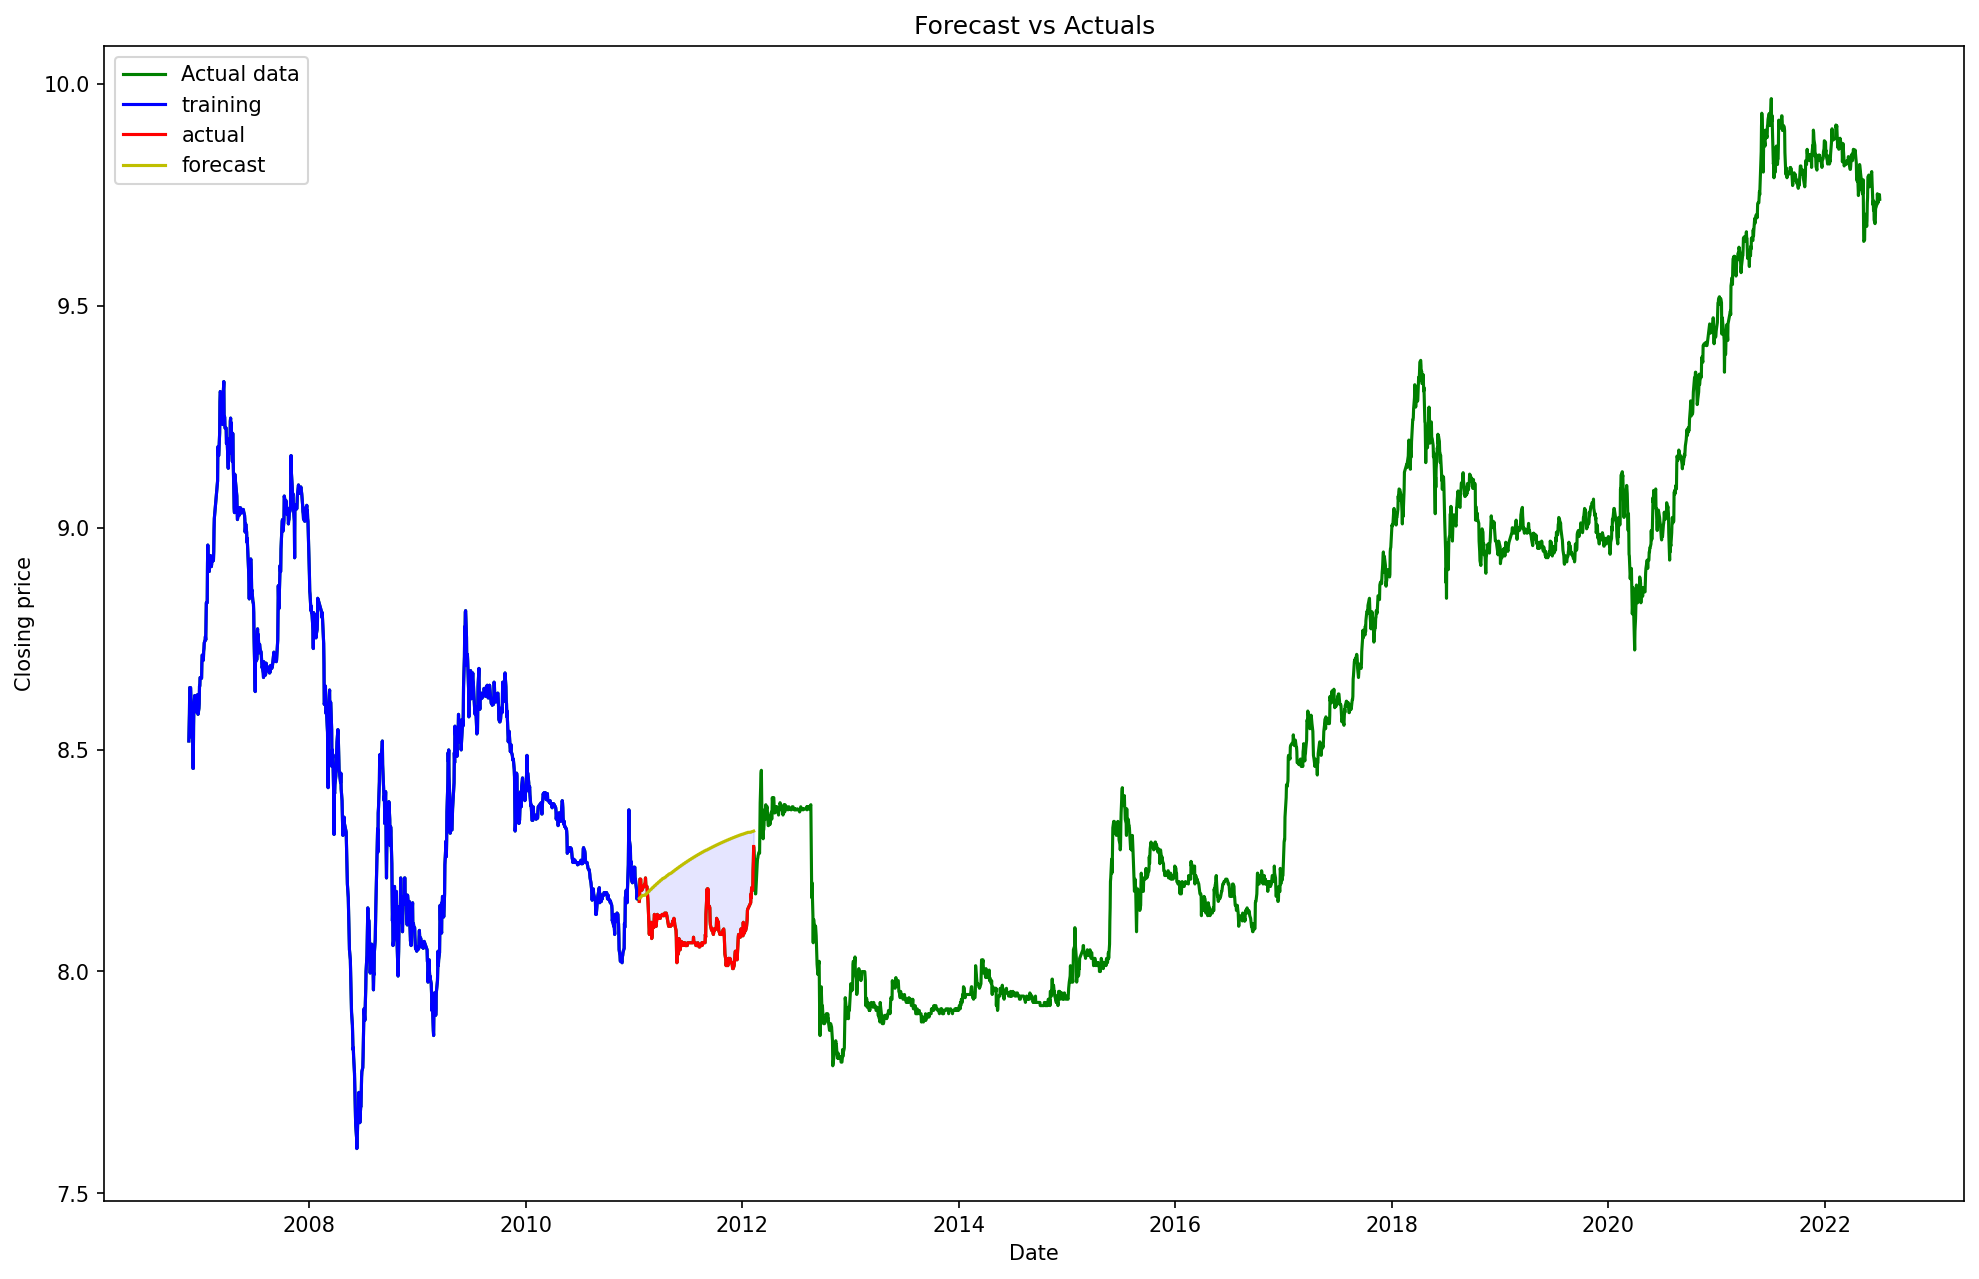

Evaluate:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


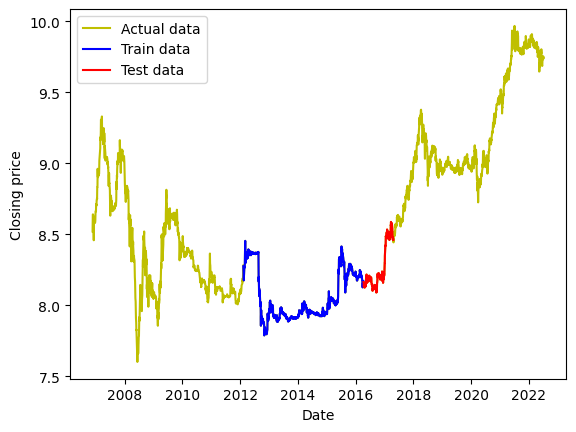

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

The lag order selected is:  [1]
                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                 1037
Model:                     AutoReg(1)   Log Likelihood                2852.002
Method:               Conditional MLE   S.D. of innovations              0.015
Date:                Wed, 10 Jul 2024   AIC                          -5698.005
Time:                        09:29:58   BIC                          -5683.175
Sample:                             1   HQIC                         -5692.378
                                 1037                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0369      0.022      1.640      0.101      -0.007       0.081
close.L1       0.9954      0.003    357.026      0.000       0.990       1.001
                    

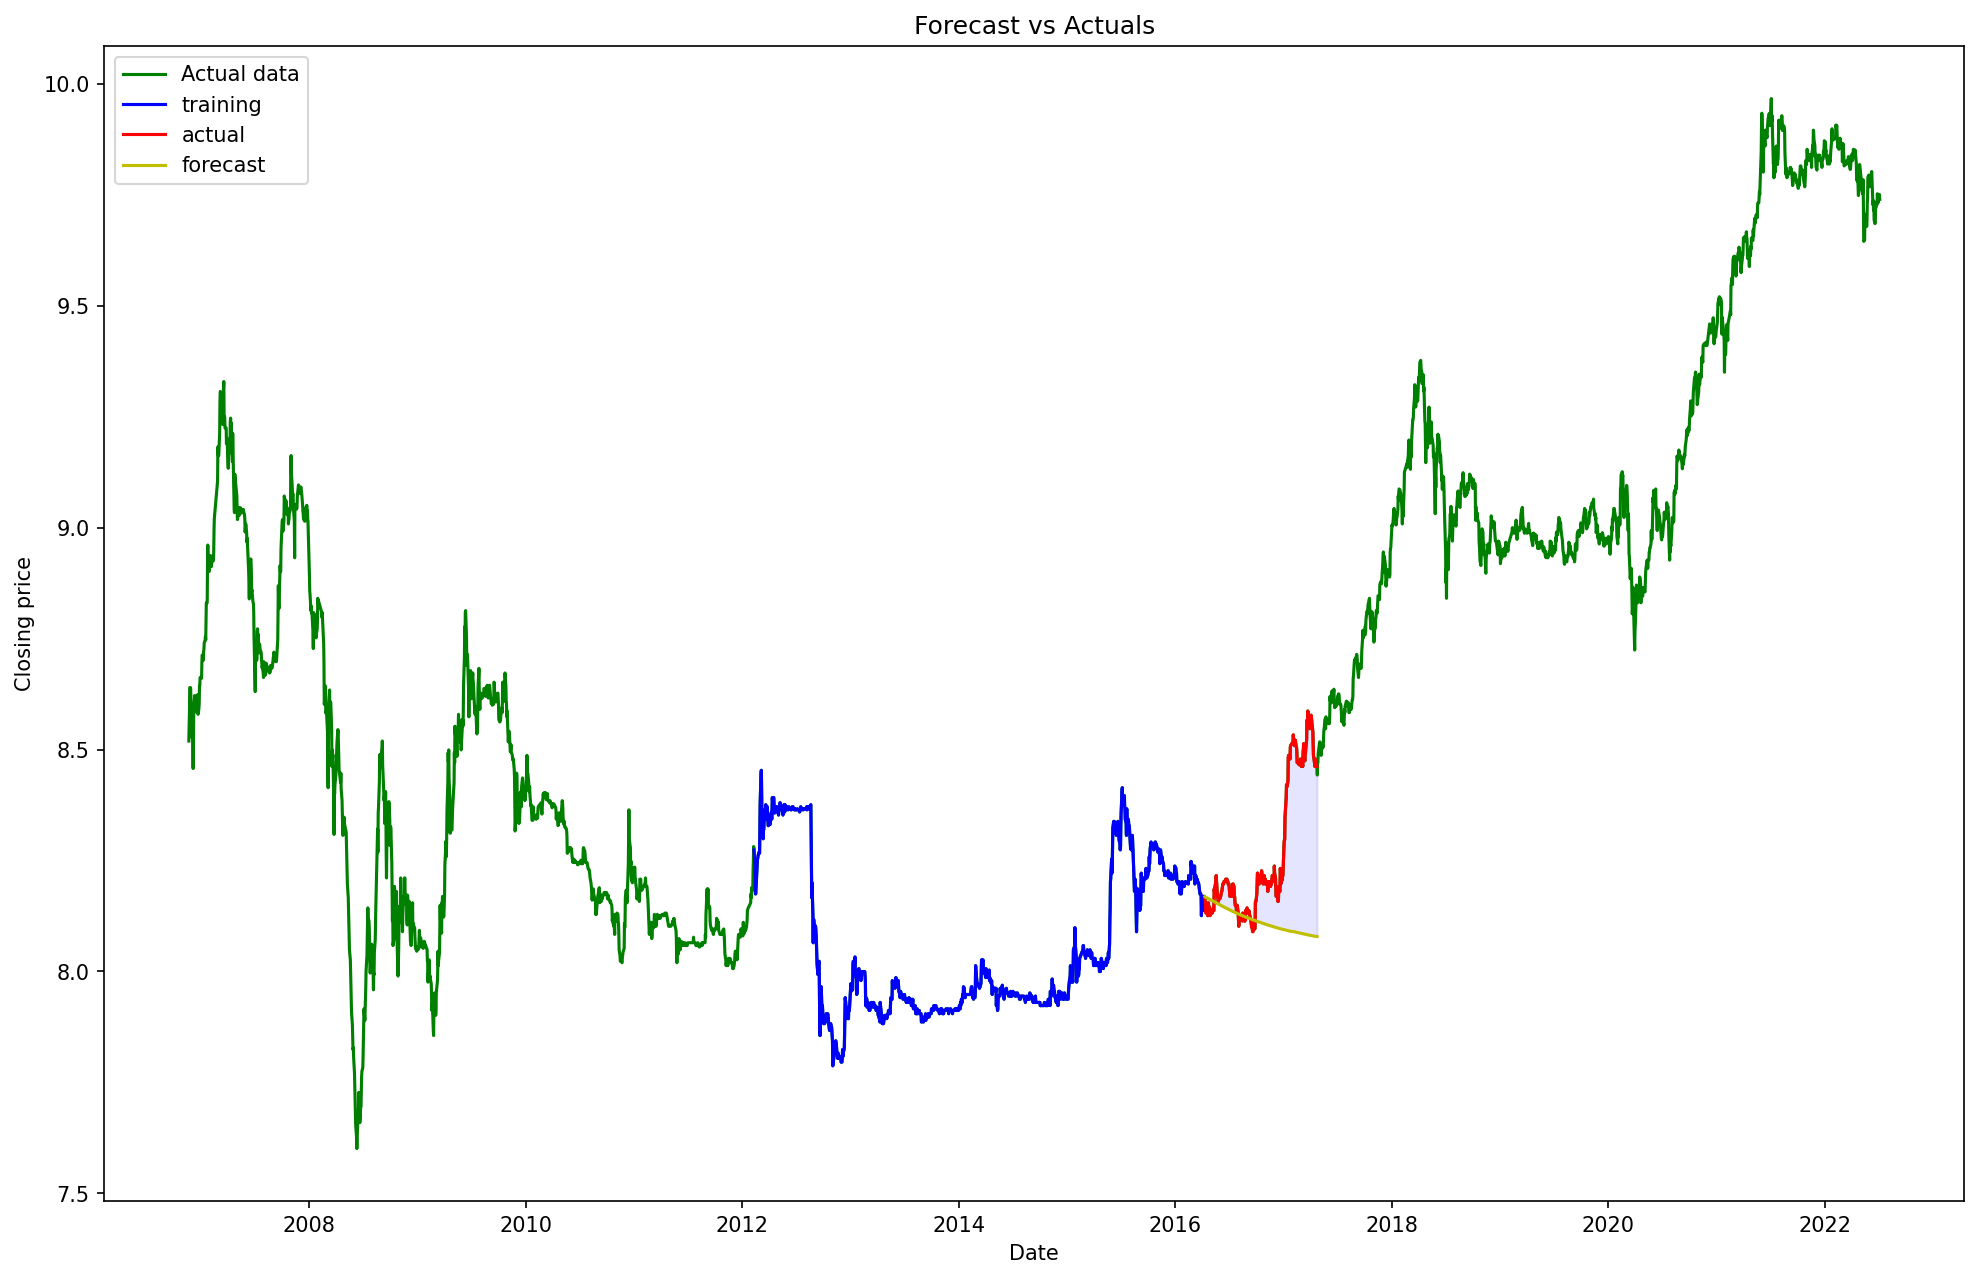

Evaluate:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


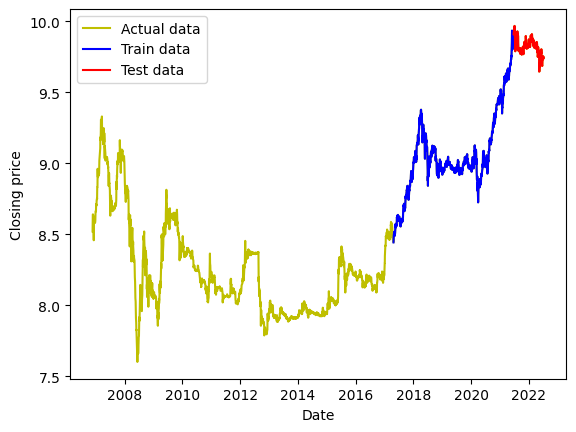

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

The lag order selected is:  [1, 2, 3]
                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                 1037
Model:                     AutoReg(3)   Log Likelihood                2564.615
Method:               Conditional MLE   S.D. of innovations              0.020
Date:                Wed, 10 Jul 2024   AIC                          -5119.231
Time:                        09:29:59   BIC                          -5094.525
Sample:                             3   HQIC                         -5109.856
                                 1037                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.021      0.289      0.772      -0.035       0.047
close.L1       0.9297      0.031     30.055      0.000       0.869       0.990
close.L2      

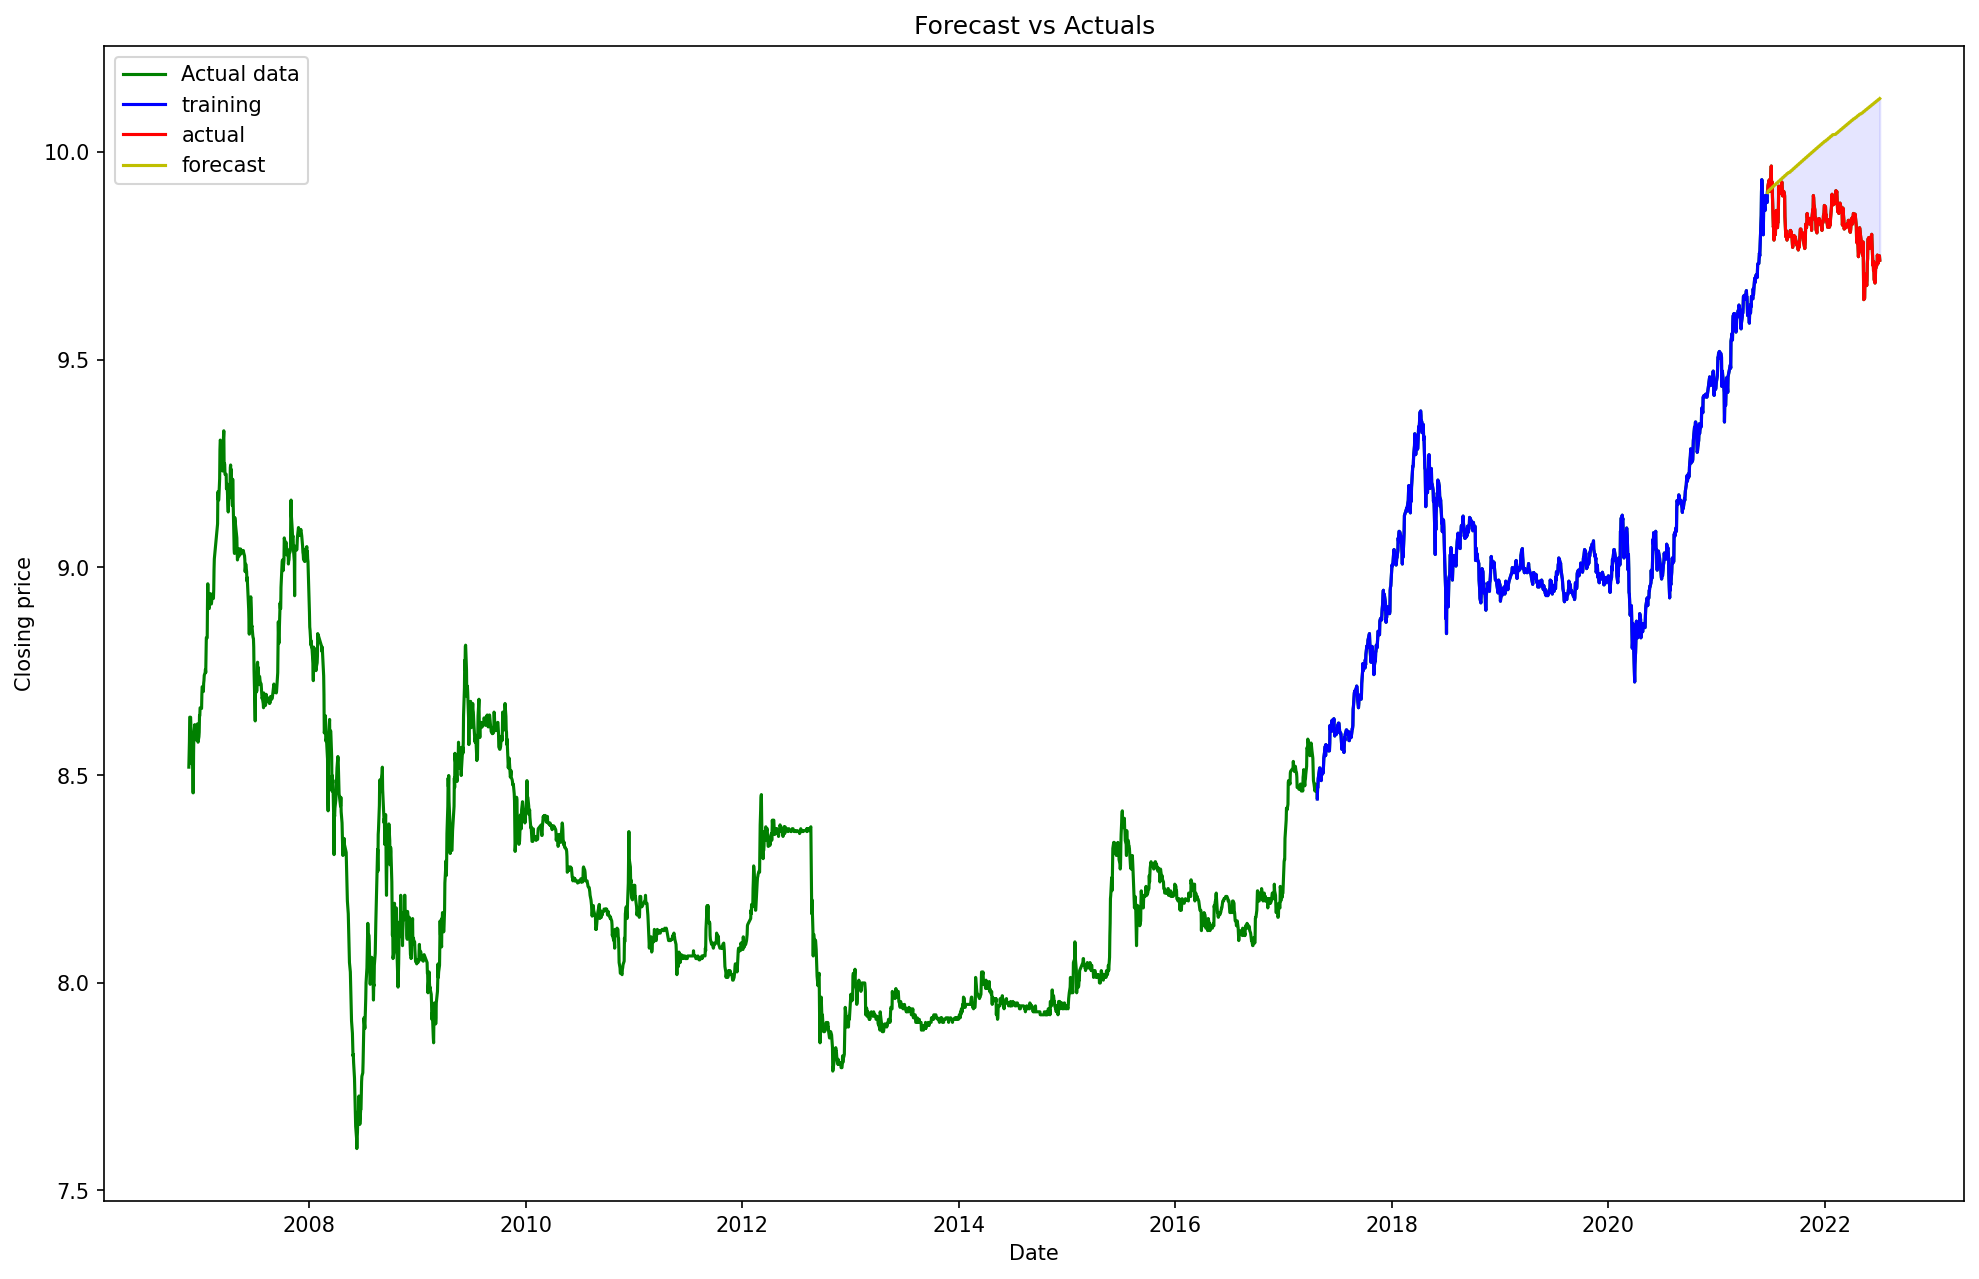

Evaluate:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [45]:
for i in range(len(split_position_df)):

    start = split_position_df.iloc[i]['start']
    split = split_position_df.iloc[i]['split']
    end = split_position_df.iloc[i]['end']

    # Split dataset
    train_split = df_train_test[start:split]
    test_split = df_train_test[split:end]

    # Plot train and test data
    plot_train_test(df_train_test, train_split, test_split)

    # AR model
    models = ar_select_order(train_split, maxlag=30)
    print('The lag order selected is: ', models.ar_lags)
    model = AutoReg(train_split, lags=models.ar_lags, old_names=False)
    model_fit = model.fit()
    print(model_fit.summary())

    # Forecast
    fc = model_fit.forecast(len(test_split))
    fc_values = fc
    fc_values.index = test_split.index

    # Draw chart Actuals data, WindowSlide data, train data, test data, forecast data
    plt.figure(figsize=(16, 10), dpi=150)
    plt.plot(df_train_test, 'g', label='Actual data')
    plt.plot(train_split, 'b', label='training')
    plt.plot(test_split, 'r', label='actual')
    plt.plot(fc_values, 'y', label='forecast')
    plt.fill_between(fc_values.index, fc_values, test_split, color='b', alpha=.10)
    plt.title('Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Closing price')
    plt.legend()
    plt.show()

     # Verify results against test set
    print('Evaluate:')

    rmse = np.sqrt(mean_squared_error(test_split, fc_values))
    abs_error = np.abs(test_split - fc_values)
    mape = np.round(np.mean(abs_error / test_split), 3)
    mae = np.mean(np.abs(fc_values - test_split))

    fc_val = model_fit.forecast(len(df_val))
    fc_values_val = fc_val
    fc_values_val.index = df_val.index

    rmse_val = np.sqrt(mean_squared_error(df_val, fc_values_val))
    abs_error_val = np.abs(df_val - fc_values_val)
    mape_val = np.round(np.mean(abs_error_val / df_val), 3)
    mae_val = np.mean(np.abs(fc_values_val - df_val))

    # Save result into DataFrame
    tempResultsDf = pd.DataFrame({'Method':[f'Auto Regressive (AR) {start}-{end}'], 'RMSE': [rmse], 'MAPE': [mape], 'MAE': [mae], 'RMSE_val': [rmse_val], 'MAPE_val': [mape_val], 'MAE_val': [mae_val]})
    results = pd.concat([results, tempResultsDf])

    # model_fit.save(f'./Auto Regressive (AR) {start}-{end}.pkl')


# print(results)


### **ARIMA Model**

time
2006-11-21    8.519191
2006-11-22    8.554489
2006-11-23    8.581107
2006-11-24    8.639411
2006-11-27    8.639411
                ...   
2011-01-12    8.166216
2011-01-13    8.171882
2011-01-14    8.171882
2011-01-17    8.180321
2011-01-18    8.166216
Name: close, Length: 1037, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4382.681, Time=2.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4355.270, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4385.370, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4388.226, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4357.132, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4386.422, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4386.509, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4384.397, Time=1.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4390.127, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4388.077, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1037
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2197.063
Date:                Wed, 10 Jul 2024   AIC                          -4390.127
Time:                        09:30:09   BIC                          -4380.241
Sample:                             0   HQIC                         -4386.376
                               - 1037                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1885      0.023      8.095      0.000       0.143       0.234
sigma2         0.0008   2.68e-05     31.389      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


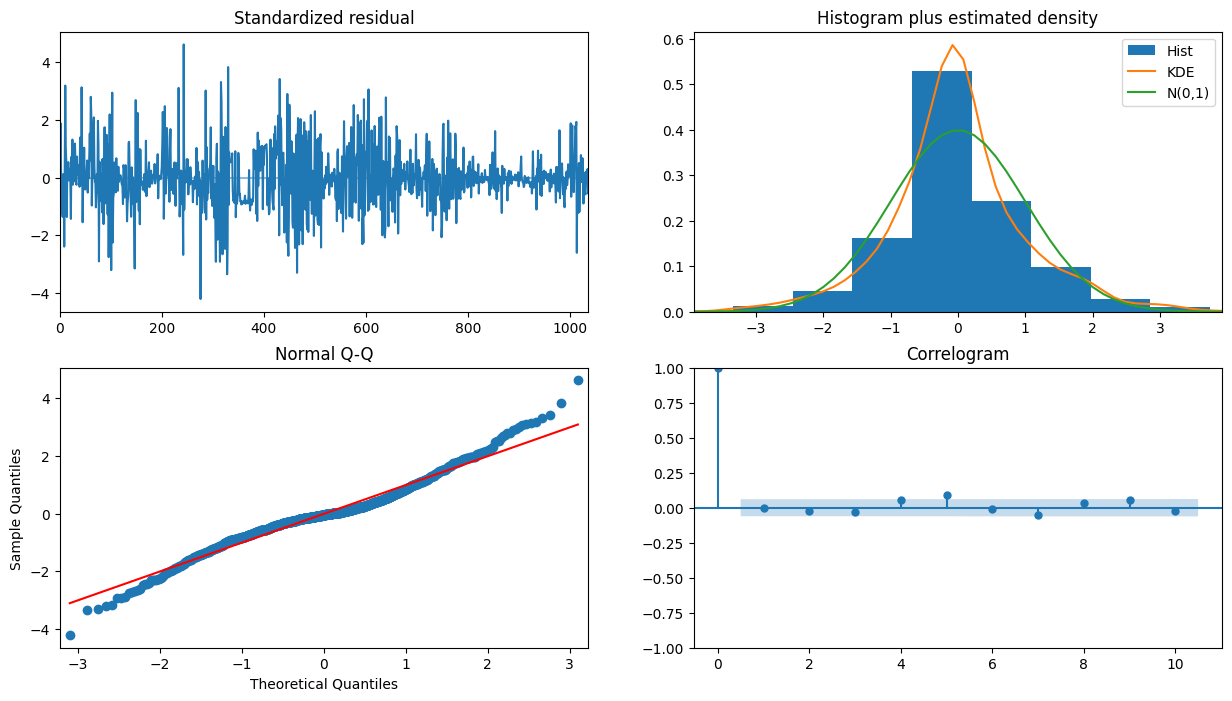

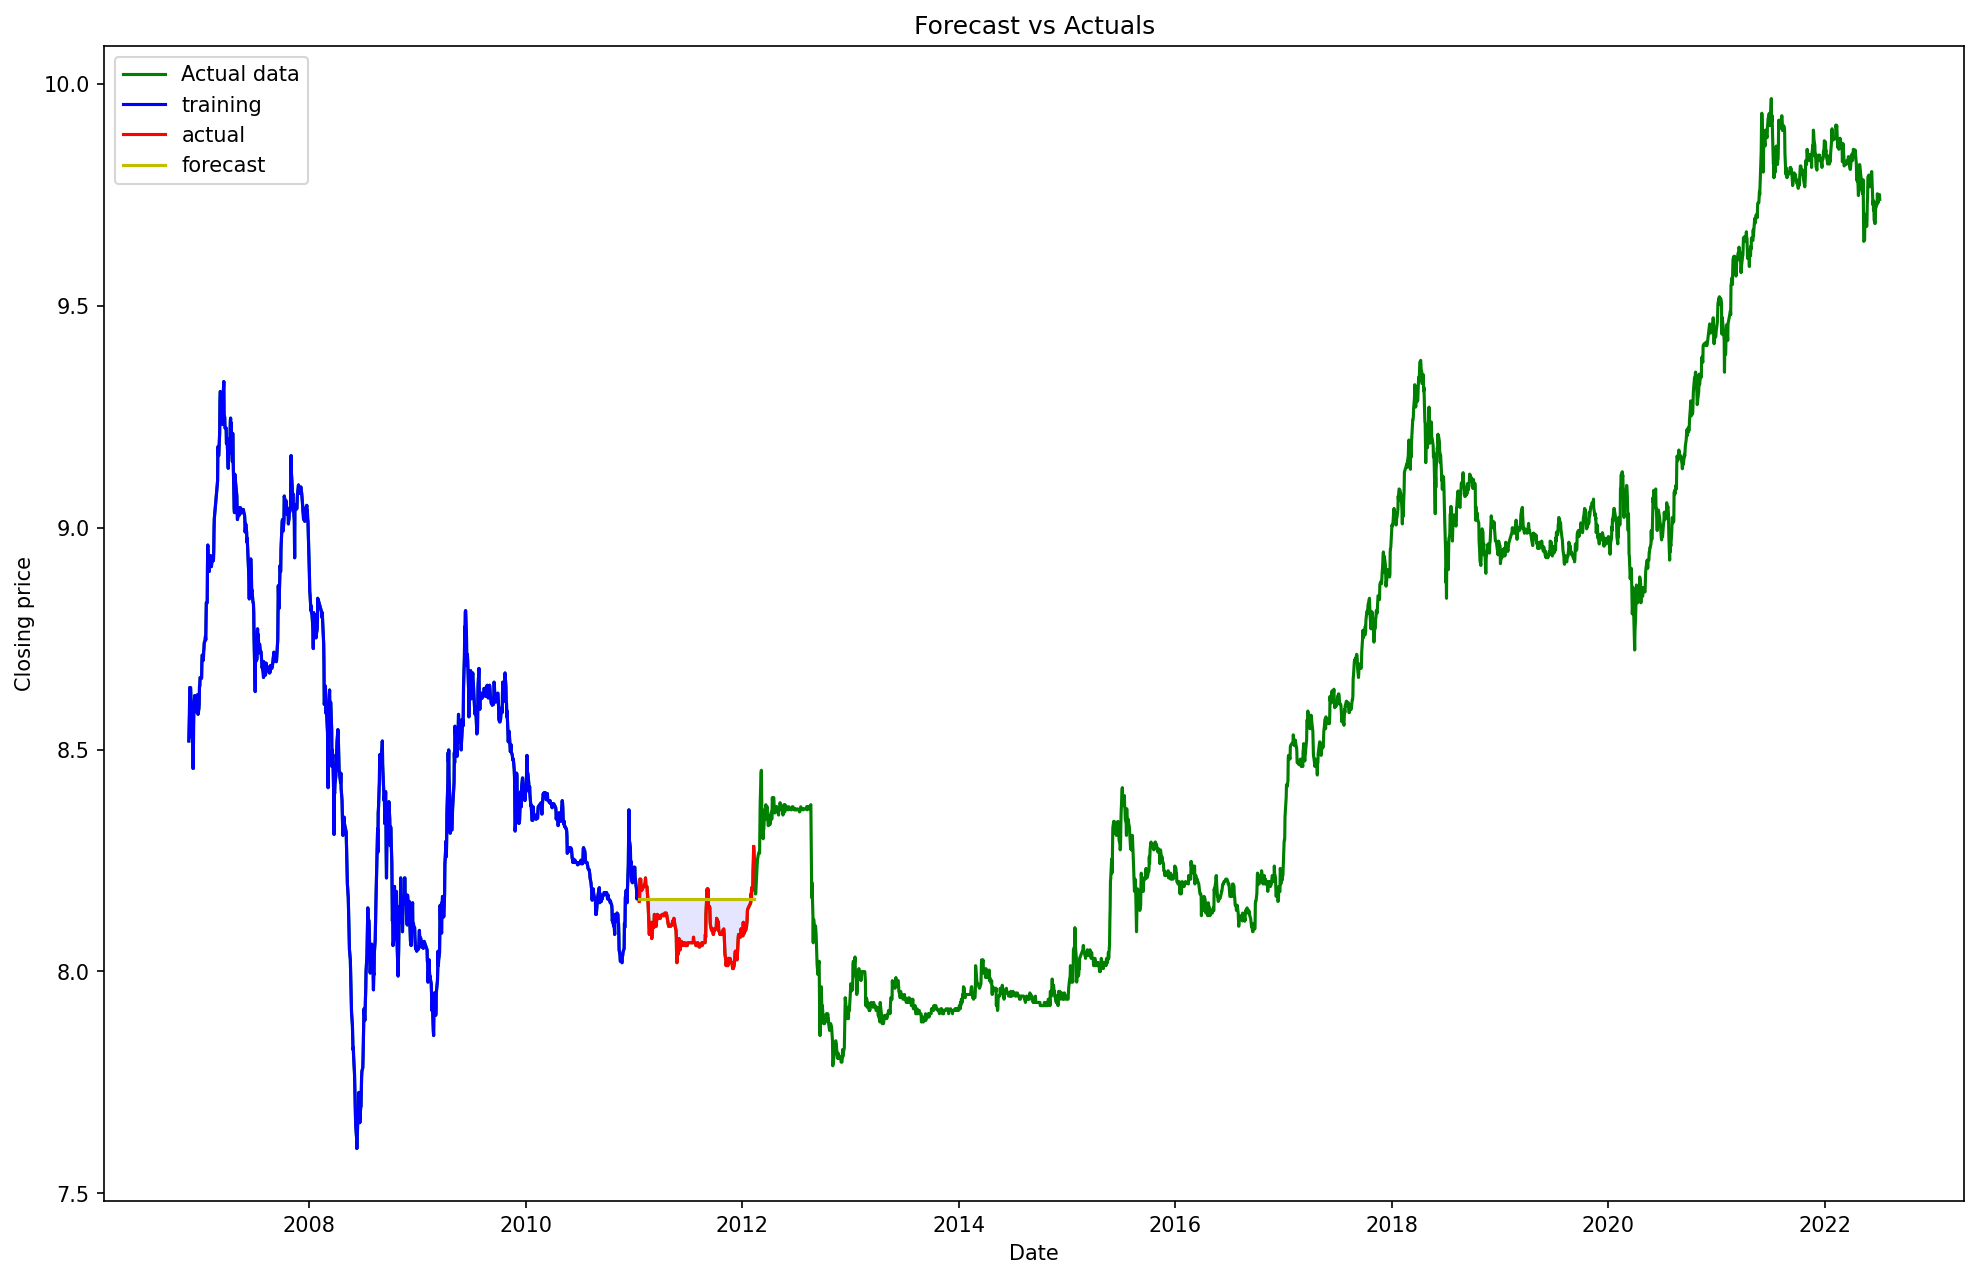

Evaluate:
time
2011-01-19    8.163251
2011-01-20    8.163251
2011-01-21    8.163251
2011-01-24    8.163251
2011-01-25    8.163251
                ...   
2012-02-03    8.163251
2012-02-06    8.163251
2012-02-07    8.163251
2012-02-08    8.163251
2012-02-09    8.163251
Name: predicted_mean, Length: 260, dtype: float64
time
2012-02-10    8.273847
2012-02-13    8.240121
2012-02-14    8.202482
2012-02-15    8.174703
2012-02-16    8.174703
                ...   
2016-04-04    8.157657
2016-04-05    8.143227
2016-04-06    8.137396
2016-04-07    8.154788
2016-04-08    8.169053
Name: close, Length: 1037, dtype: float64
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5698.814, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5697.303, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5704.867, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5705.092, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5699.259, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5703.114, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5703.128, Time=0.88 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5701.064, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5706.964, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5705.001, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5704.952, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5706.829, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5703.024, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.049 seconds
                               SARIMAX Results      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1037
Model:                 ARIMA(0, 1, 1)   Log Likelihood                2855.482
Date:                Wed, 10 Jul 2024   AIC                          -5706.964
Time:                        09:30:15   BIC                          -5697.077
Sample:                             0   HQIC                         -5703.213
                               - 1037                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0888      0.016      5.642      0.000       0.058       0.120
sigma2         0.0002   4.98e-06     47.434      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.07   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


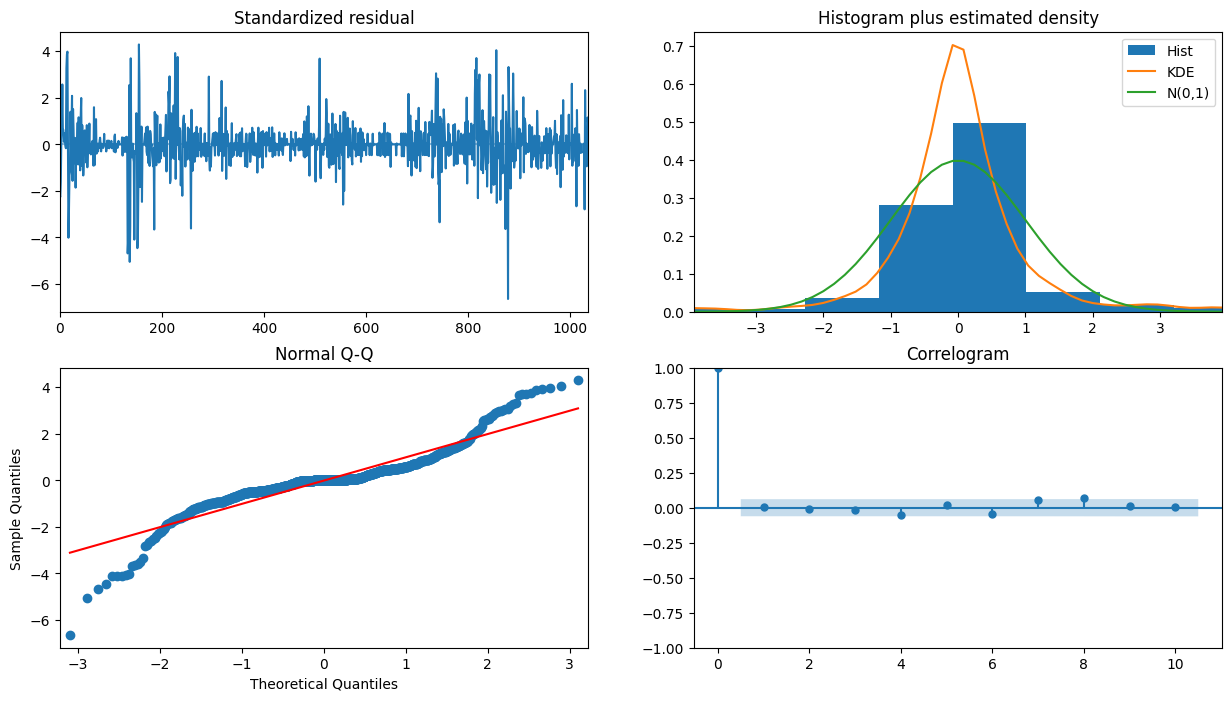

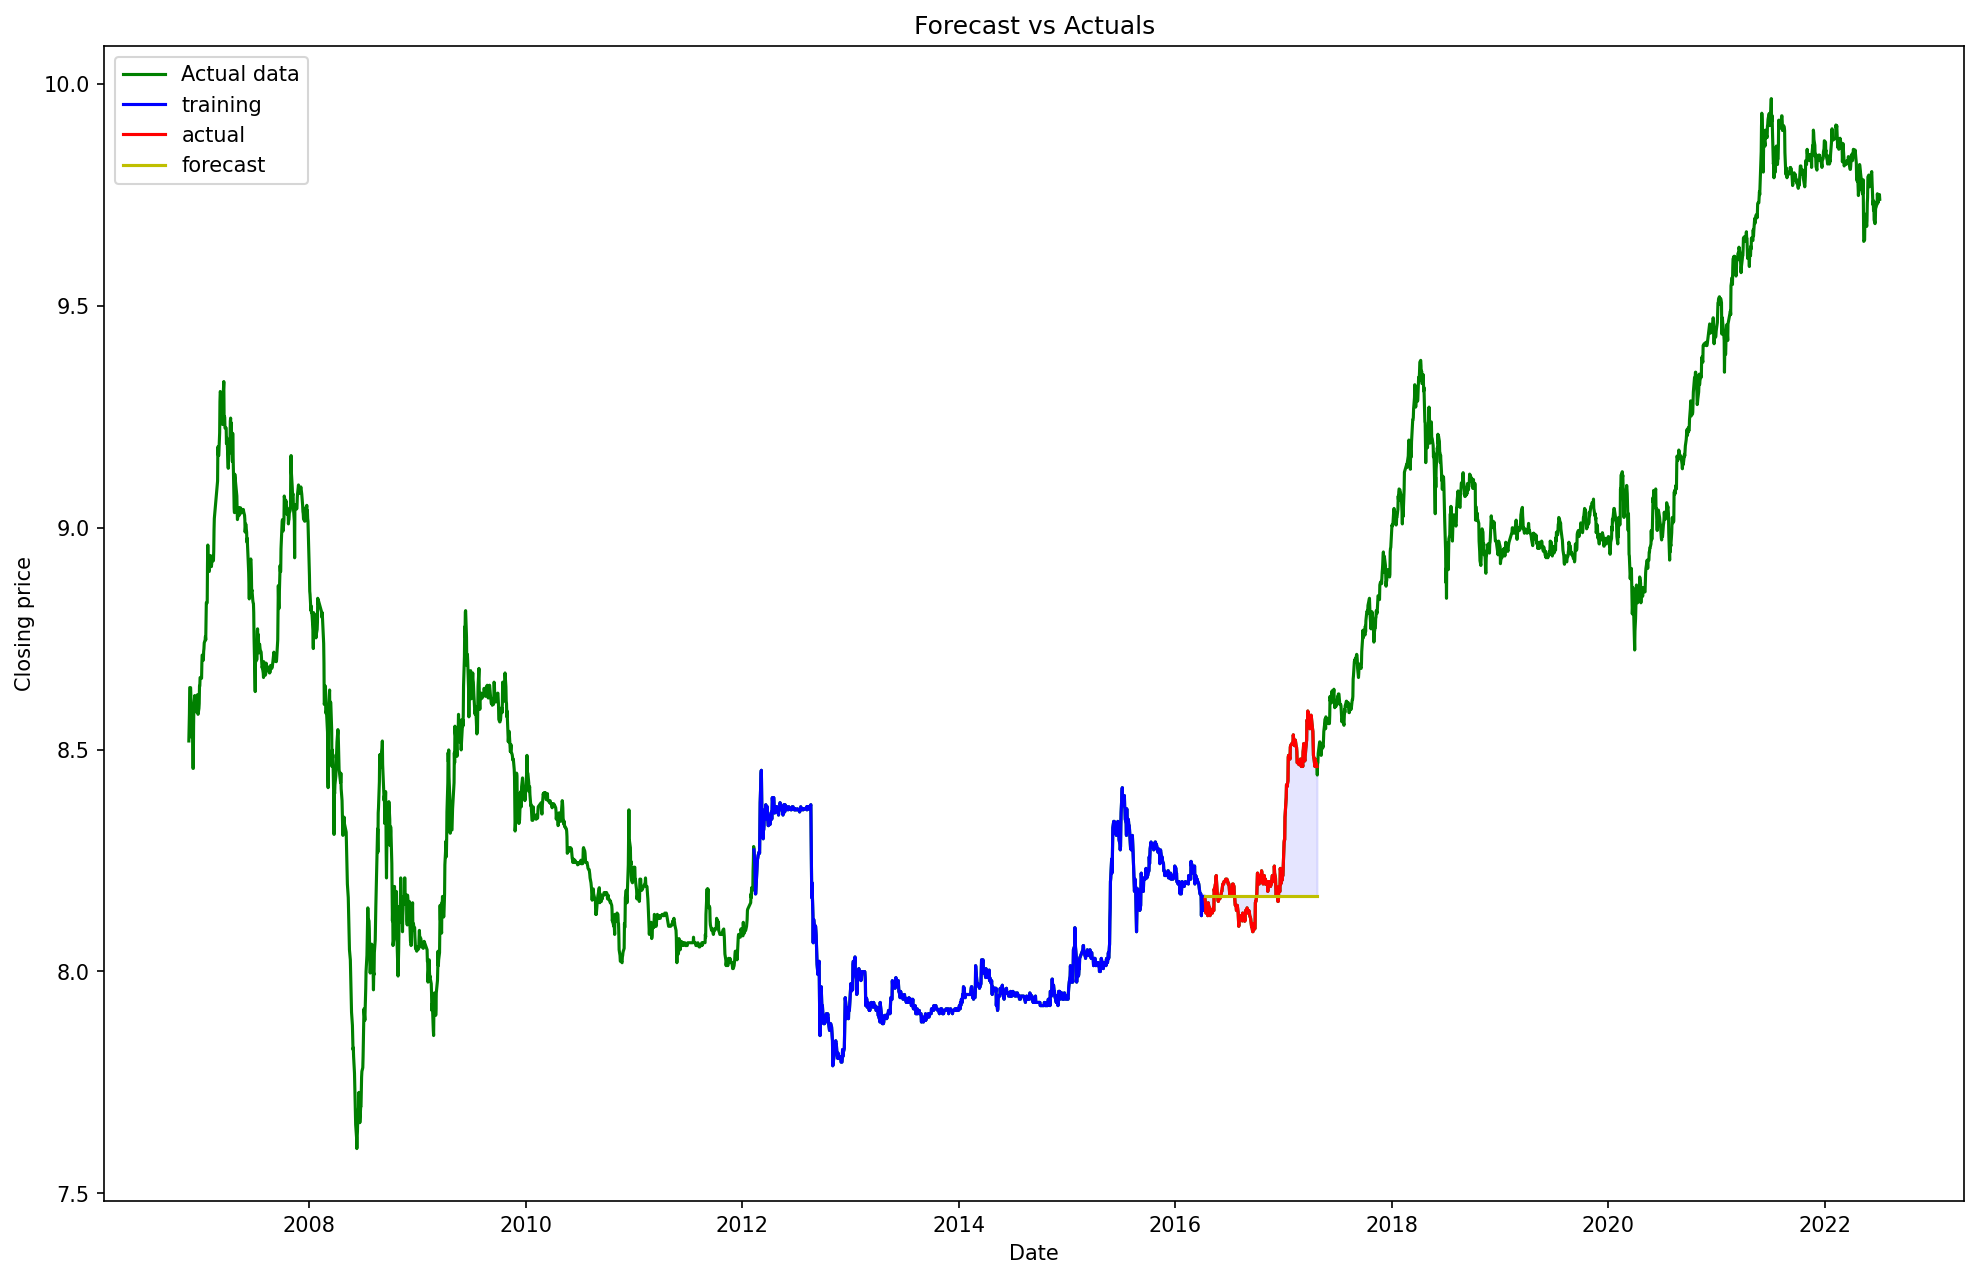

Evaluate:
time
2016-04-11    8.17018
2016-04-12    8.17018
2016-04-13    8.17018
2016-04-14    8.17018
2016-04-15    8.17018
               ...   
2017-04-18    8.17018
2017-04-19    8.17018
2017-04-20    8.17018
2017-04-21    8.17018
2017-04-24    8.17018
Name: predicted_mean, Length: 260, dtype: float64
time
2017-04-25    8.442470
2017-04-26    8.470102
2017-04-27    8.470102
2017-04-28    8.490849
2017-05-03    8.517193
                ...   
2021-06-16    9.877144
2021-06-17    9.882775
2021-06-18    9.885833
2021-06-21    9.878682
2021-06-22    9.903987
Name: close, Length: 1037, dtype: float64
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5128.734, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5116.633, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5121.081, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5119.918, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5113.709, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5130.509, Time=0.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5130.331, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5128.314, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5128.631, Time=1.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5130.618, Time=0.61 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-5128.672, Time=0.98 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-5126.661, Time=1.84 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-5127.637, Time=0.31 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 8.678 seconds
                               SARIMAX Results      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1037
Model:                 ARIMA(0, 1, 3)   Log Likelihood                2567.819
Date:                Wed, 10 Jul 2024   AIC                          -5127.637
Time:                        09:30:27   BIC                          -5107.865
Sample:                             0   HQIC                         -5120.135
                               - 1037                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0636      0.022     -2.846      0.004      -0.107      -0.020
ma.L2          0.1184      0.023      5.117      0.000       0.073       0.164
ma.L3         -0.0445      0.023     -1.944      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


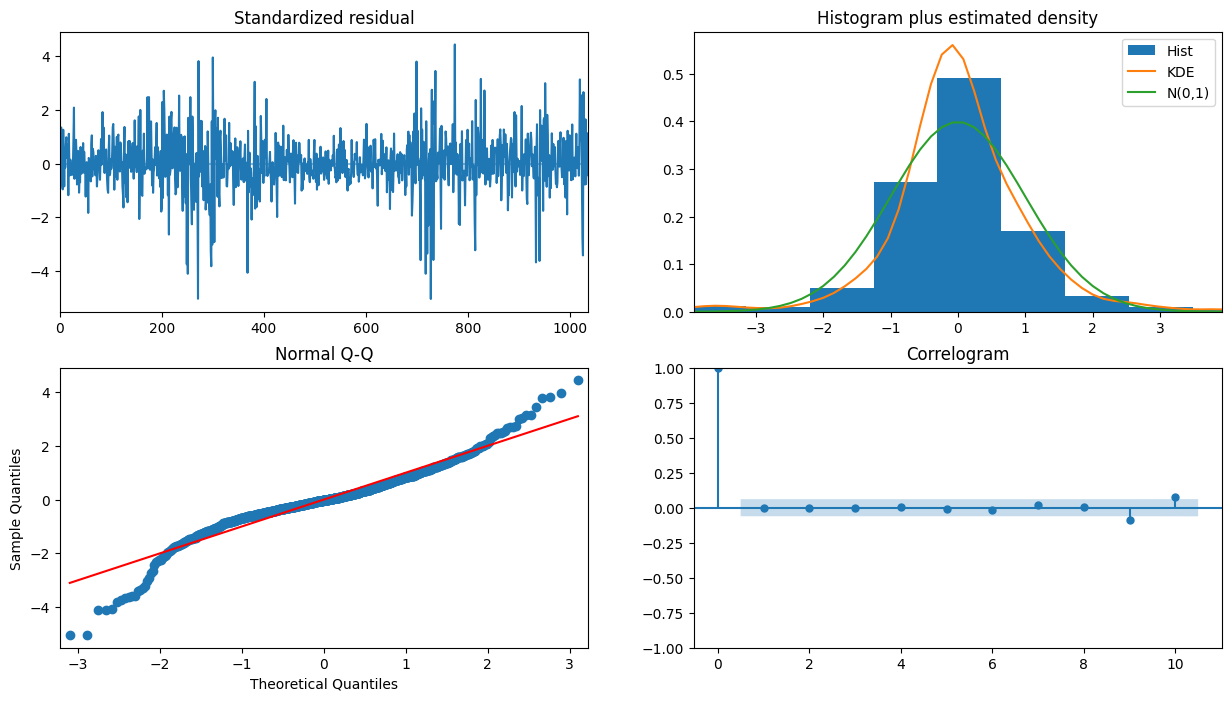

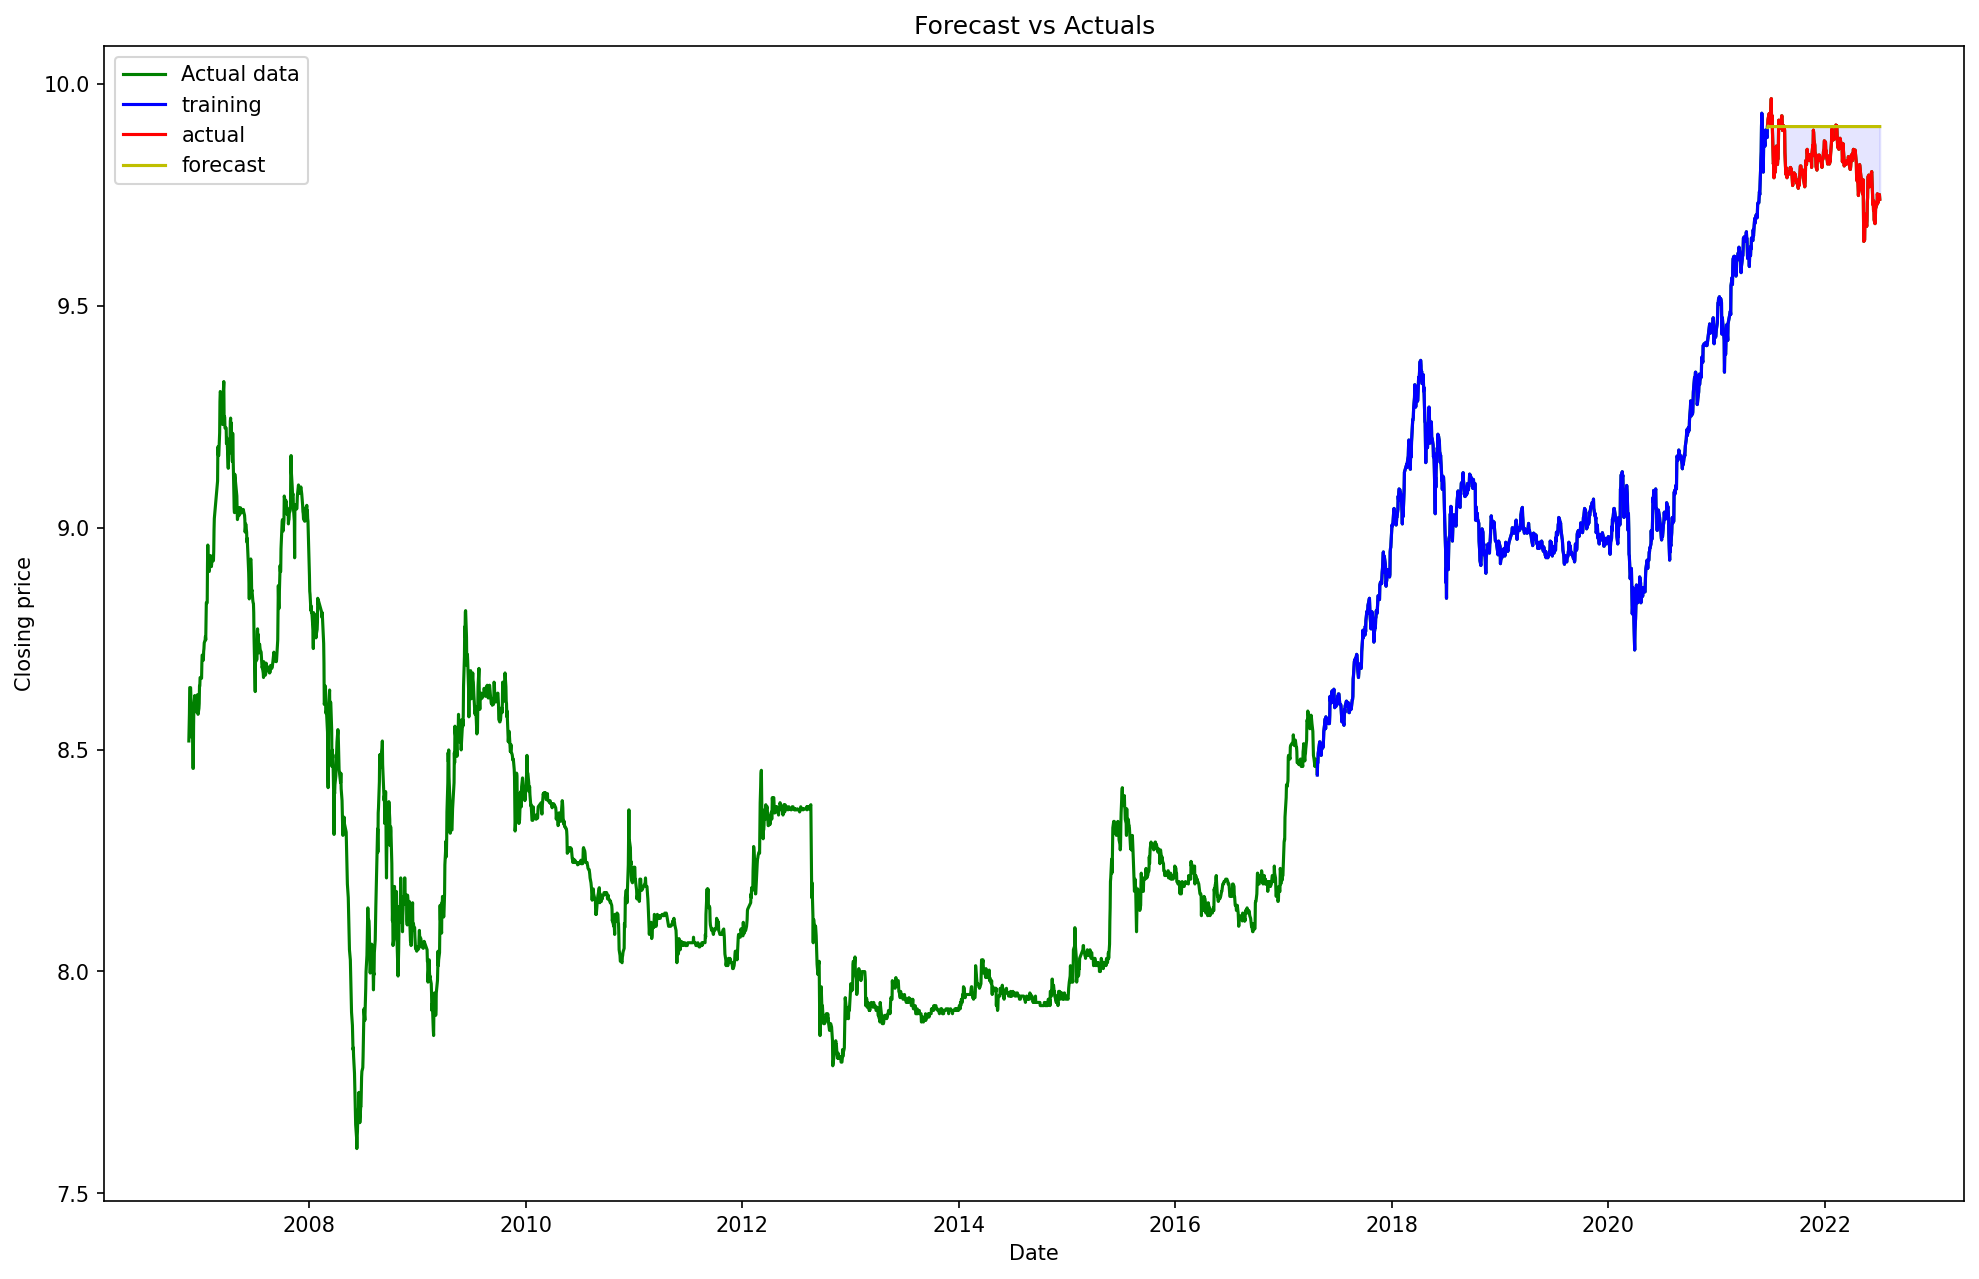

Evaluate:
time
2021-06-23    9.901304
2021-06-24    9.904485
2021-06-25    9.903414
2021-06-28    9.903414
2021-06-29    9.903414
                ...   
2022-06-30    9.903414
2022-07-01    9.903414
2022-07-04    9.903414
2022-07-05    9.903414
2022-07-06    9.903414
Name: predicted_mean, Length: 260, dtype: float64
                            Model      RMSE   MAPE       MAE  RMSE_val  \
0            Auto Regressive (AR)  0.356813  0.033  0.326974  0.400663   
0  ARIMA - (1, 1, 0) (0, 0, 0, 0)  0.316249  0.029  0.289267  0.354676   
0                             NaN  0.336725  0.036  0.286910  1.531255   
0                             NaN  0.479433  0.038  0.335309  1.763741   
0                             NaN  0.756680  0.059  0.571791  0.935535   
0                             NaN  0.168930  0.018  0.146936  1.682785   
0                             NaN  0.626633  0.056  0.491884  1.870242   
0                             NaN  0.453204  0.035  0.335485  0.743379   
0               

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [46]:
#  Create DataFrame to save results
for i in range(len(split_position_df)):
    start = split_position_df.iloc[i]['start']
    split = split_position_df.iloc[i]['split']
    end = split_position_df.iloc[i]['end']

    train_split = df_train_test[start:split]
    test_split = df_train_test[split:end]
    print(train_split)

    # P, D, Q
    stepwise_fit = auto_arima(train_split, trace=True, suppress_warnings=True)
    print(stepwise_fit.summary())
    stepwise_fit.plot_diagnostics(figsize=(15, 8))
    order = stepwise_fit.order
    seasonal_order = stepwise_fit.seasonal_order

    model = ARIMA(train_split, order=order, seasonal_order=seasonal_order)
    fitted = model.fit()
    print(fitted.summary())

    # Forecast
    fc = fitted.forecast(len(test_split))
    fc_values = fc
    fc_values.index = test_split.index

    # Draw chart Actuals data, WindowSlide data, train data, test data, forecast data
    plt.figure(figsize=(16, 10), dpi=150)
    plt.plot(df_train_test, 'g', label='Actual data')
    plt.plot(train_split, 'b', label='training')
    plt.plot(test_split, 'r', label='actual')
    plt.plot(fc_values, 'y', label='forecast')
    plt.fill_between(fc_values.index, fc_values, test_split, color='b', alpha=.10)
    plt.title('Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Closing price')
    plt.legend()
    plt.show()

    # Verify results against test set
    print('Evaluate:')
    rmse = np.sqrt(mean_squared_error(test_split, fc_values))
    abs_error = np.abs(test_split - fc_values)
    mape = np.round(np.mean(abs_error / test_split), 3)
    mae = np.mean(np.abs(fc_values - test_split))

    fc_val = fitted.forecast(len(df_val))
    fc_values_val = fc_val
    print(fc_values)
    fc_values_val.index = df_val.index

    rmse_val = np.sqrt(mean_squared_error(df_val, fc_values_val))
    abs_error_val = np.abs(df_val - fc_values_val)
    mape_val = np.round(np.mean(abs_error_val / df_val), 3)
    mae_val = np.mean(np.abs(fc_values_val - df_val))

    # Save result into DataFrame
    tempResultsDf = pd.DataFrame(
        {'Method': [f'ARIMA - {order} {seasonal_order} {start}-{end}'], 'RMSE': [rmse], 'MAPE': [mape], 'MAE': [mae],
         'RMSE_val': [rmse_val], 'MAPE_val': [mape_val], 'MAE_val': [mae_val]})
    results = pd.concat([results, tempResultsDf])
    # fitted.save(f'./ARIMA - {order} {seasonal_order} {start}-{end}.pkl')

print(results)

In [47]:
results['Model'] = results['Model'].fillna(results['Method'])
results = results.drop(columns=['Method'])

# Sắp xếp kết quả để tìm ra mô hình tốt nhất:
results = results.sort_values(by=['RMSE_val'])
print(results)

                                      Model      RMSE   MAPE       MAE  \
0  ARIMA - (0, 1, 3) (0, 0, 0, 0) 2594-3891  0.100971  0.009  0.086326   
0            Auto Regressive (AR) 2594-3891  0.226528  0.021  0.201056   
0            ARIMA - (1, 1, 0) (0, 0, 0, 0)  0.316249  0.029  0.289267   
0                      Auto Regressive (AR)  0.356813  0.033  0.326974   
0     ARIMA - (0, 1, 1) (0, 0, 0, 0) 0-3891  0.453204  0.035  0.335485   
0               Auto Regressive (AR) 0-3891  0.756680  0.059  0.571791   
0               Auto Regressive (AR) 0-1297  0.178570  0.020  0.164072   
0               Auto Regressive (AR) 0-1947  0.336725  0.036  0.286910   
0  ARIMA - (0, 1, 1) (0, 0, 0, 0) 1297-2594  0.174103  0.013  0.112783   
0     ARIMA - (0, 1, 1) (0, 0, 0, 0) 0-1297  0.084922  0.009  0.076634   
0     ARIMA - (3, 1, 3) (0, 0, 0, 0) 0-1947  0.168930  0.018  0.146936   
0            Auto Regressive (AR) 1297-2594  0.222573  0.018  0.150752   
0               Auto Regressive (AR) 0

# **4. Built LSTM model**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

numerical_columns = data.select_dtypes(include=["number"]).columns

scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Get data
data_updated = data.drop('ticker', axis=1)


print(data_updated)
print(data_updated.columns)
print(data_updated['close'])
# column_name = data_updated.columns[3]
# column_name_stripped = column_name.strip()

# if column_name_stripped == 'close':
#     print("Tên cột chính xác: 'close'")
# else:
#     print("Tên cột không chính xác: '{}'".format(column_name_stripped))

# Preparing data for LSTM model
def prepare_data(data_updated, target_col, window_size):
    X, y = [], []
    for i in range(len(data_updated) - window_size):
        window = data_updated.iloc[i:(i + window_size)]
        X.append(window.values)
        y.append(data_updated.iloc[i + window_size][target_col])

    # Convert list of numpy arrays to numpy arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return X, y

# LSTM model definition
def create_lstm_model(units=50, activation='relu', learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=units, activation=activation, input_shape=(X_train[0].shape[0], X_train[0].shape[1])),
        tf.keras.layers.Dense(units=1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Prepare the data and split it into training and testing sets
window_size = 30
target_col = 'close'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_updated[[target_col]])  # Take only 'close' column to normalize
data_updated[target_col] = scaled_data  # Assign normalized data back to 'close' column
X, y = prepare_data(data_updated, target_col, window_size)

# Split into train test set and validation set
X_train_test, X_val = X[:int(len(X) * 0.9)], X[int(len(X) * 0.9):]
y_train_test, y_val = y[:int(len(y) * 0.9)], y[int(len(y) * 0.9):]

# Continue to divide the train test set into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.1, shuffle=False)


# Define hyperparameters to search
param_grid = {
    'units': [50, 100, 150],
    'activation': ['relu', 'tanh'],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform optimal hyperparameter search
best_score = float('inf')
best_params = {}
for units in param_grid['units']:
    for activation in param_grid['activation']:
        for learning_rate in param_grid['learning_rate']:
            model = create_lstm_model(units=units, activation=activation, learning_rate=learning_rate)
            model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)  # Train model
            y_pred = model.predict(X_train)  # Prediction on training set

            # Check and remove NaN values
            y_pred = np.nan_to_num(y_pred)

            score = mean_squared_error(y_train, y_pred)  # Evaluate model
            if score < best_score:
                best_score = score
                best_params = {'units': units, 'activation': activation, 'learning_rate': learning_rate}

# Print out the optimal results
print("Best: %f using %s" % (best_score, best_params))

# Train the best model on the entire training set
best_model = create_lstm_model(**best_params)
best_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
abs_error_test = np.abs(y_test - y_pred_test)
mape_test = np.round(np.mean(abs_error_test / y_test), 3)
mae_test = np.mean(abs_error_test)

# Evaluation of LSTM model on validation set
y_pred_val = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
abs_error_val = np.abs(y_val - y_pred_val)
mape_val = np.round(np.mean(abs_error_val / y_val), 3)
mae_val = np.mean(abs_error_val)

# Print the results of LSTM model evaluation on test and validation sets
print("Evaluate on Test Data:")
print("RMSE:", rmse_test)
print("MAPE:", mape_test)
print("MAE:", mae_test)

print("Evaluate on Validation Data:")
print("RMSE:", rmse_val)
print("MAPE:", mape_val)
print("MAE:", mae_val)

                open      high       low     close    volume
time                                                        
2006-11-21  0.073563  0.167484  0.120990  0.137112  0.001567
2006-11-22  0.104981  0.155790  0.140317  0.145155  0.001732
2006-11-23  0.106897  0.158808  0.140317  0.151666  0.001949
2006-11-24  0.101533  0.170879  0.158098  0.166220  0.001769
2006-11-27  0.110345  0.187099  0.149208  0.166220  0.001166
...              ...       ...       ...       ...       ...
2024-03-25  0.986590  0.966051  0.972942  0.961700  0.290016
2024-03-26  0.969349  0.962278  0.967143  0.978935  0.178812
2024-03-27  0.982759  0.966051  0.976807  0.980850  0.169578
2024-03-28  0.996169  0.986797  1.000000  0.994255  0.353536
2024-03-29  1.000000  0.988684  0.998067  1.000000  0.383874

[4324 rows x 5 columns]
Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')
time
2006-11-21    0.137112
2006-11-22    0.145155
2006-11-23    0.151666
2006-11-24    0.166220
2006-11-27    0.166

In [ ]:
# Lưu kết quả vào DataFrame
tempResultsDf = pd.DataFrame({
    'Method': ['LSTM'],
    'RMSE': [rmse_test],
    'MAPE': [mape_test],
    'MAE': [mae_test],
    'RMSE_val': [rmse_val],
    'MAPE_val': [mape_val],
    'MAE_val': [mae_val]
})
results = pd.concat([results, tempResultsDf])
print(results)

                                      Model      RMSE   MAPE       MAE  \
0  ARIMA - (2, 1, 0) (0, 0, 0, 0) 2594-3891  0.099791  0.009  0.085136   
0            ARIMA - (1, 1, 0) (0, 0, 0, 0)  0.317857  0.029  0.290783   
0            Auto Regressive (AR) 2594-3891  0.274430  0.024  0.242411   
0                      Auto Regressive (AR)  0.371264  0.034  0.340250   
0     ARIMA - (0, 1, 1) (0, 0, 0, 0) 0-3891  0.453330  0.034  0.335600   
0               Auto Regressive (AR) 0-3891  0.757132  0.058  0.572443   
0               Auto Regressive (AR) 0-1297  0.178809  0.020  0.164272   
0               Auto Regressive (AR) 0-1947  0.337043  0.035  0.287166   
0  ARIMA - (0, 1, 1) (0, 0, 0, 0) 1297-2594  0.174428  0.013  0.112865   
0     ARIMA - (0, 1, 1) (0, 0, 0, 0) 0-1297  0.085142  0.009  0.076776   
0     ARIMA - (0, 1, 1) (0, 0, 0, 0) 0-1947  0.170691  0.018  0.149011   
0            Auto Regressive (AR) 1297-2594  0.222884  0.018  0.150913   
0               Auto Regressive (AR) 0

In [ ]:
# Create a list to store all the predicted values
predicted_prices_test = []

# Predicting closing price from test set using trained model
y_pred_test = best_model.predict(X_test)

# Convert the predicted and actual values ​​of the test set back to the original space
y_pred_original = scaler.inverse_transform(y_pred_test)* (28500.000000 - 4341.000000) + 4341.000000
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)) * (28500.000000 - 4341.000000) + 4341.000000

# Loop through all predictions and actual values ​​to print out
for i in range(len(y_pred_original)):
    predicted_price = y_pred_original[i][0]
    actual_price = y_test_original[i][0]
    # print("Predicted close price:", predicted_price, "Actual close price:", actual_price)
    predicted_prices_test.append(predicted_price)  # Add predicted price to list

13/13 [==============================] - 0s 8ms/step


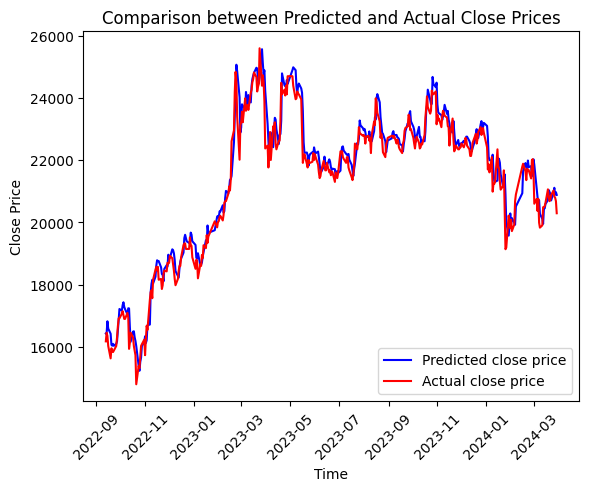

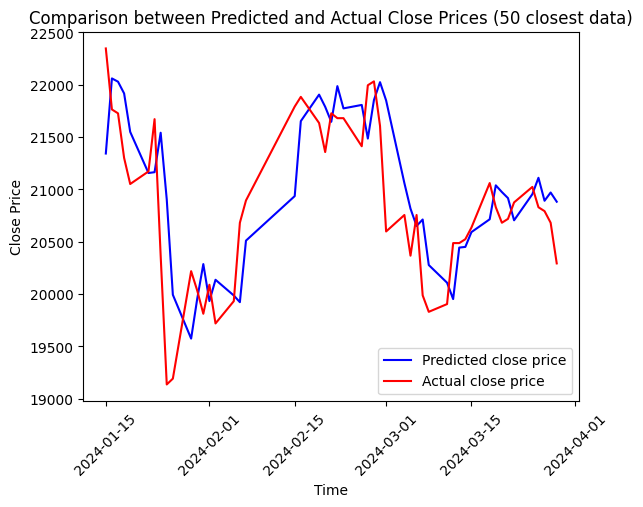

In [ ]:
# Number of data points to use
num_data_points = len(y_pred_original)

# Use only the part of data.index corresponding to the number of data points
indices = data.index[-num_data_points:]

# Visualize comparison between predicted and actual values
plt.plot(indices, y_pred_original, label='Predicted close price', color='blue')
plt.plot(indices, y_test_original, label='Actual close price', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Comparison between Predicted and Actual Close Prices')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Number of values ​​to display
num_values = 50

# Get final data
last_data = data.iloc[-num_values:]

# Create an array containing the indices of the data points
indices = range(num_values)

# Get the time corresponding to the data points
timestamps = last_data.index

# Visualize comparison between predicted and actual values
plt.plot(timestamps, y_pred_original[-num_values:], label='Predicted close price', color='blue')
plt.plot(timestamps, y_test_original[-num_values:], label='Actual close price', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Comparison between Predicted and Actual Close Prices (50 closest data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
print(y_pred_original)

[[16427.879]
 [16443.707]
 [16820.846]
 [16586.508]
 [16420.527]
 [16064.415]
 [16038.136]
 [16095.099]
 [16032.298]
 [16095.463]
 [16178.324]
 [16495.045]
 [16842.418]
 [17215.34 ]
 [17162.602]
 [17339.117]
 [17432.066]
 [17283.27 ]
 [17211.082]
 [17040.537]
 [17239.4  ]
 [17234.932]
 [16648.234]
 [16163.189]
 [16489.   ]
 [16500.057]
 [16305.813]
 [16188.175]
 [16023.247]
 [15388.317]
 [15229.855]
 [15515.509]
 [15653.066]
 [16025.977]
 [16148.084]
 [16337.938]
 [16121.836]
 [16212.039]
 [16691.248]
 [16716.824]
 [17757.459]
 [18020.902]
 [18154.785]
 [18036.322]
 [18252.746]
 [18601.691]
 [18781.07 ]
 [18757.836]
 [18757.18 ]
 [18553.582]
 [18340.04 ]
 [18308.455]
 [18104.898]
 [18502.742]
 [18622.879]
 [18580.371]
 [18959.98 ]
 [18851.11 ]
 [18859.266]
 [19133.469]
 [19103.355]
 [19006.984]
 [18790.121]
 [18435.594]
 [18276.473]
 [18223.203]
 [18538.383]
 [18740.793]
 [18835.71 ]
 [19026.55 ]
 [19492.652]
 [19600.27 ]
 [19499.555]
 [19391.588]
 [19337.203]
 [19326.621]
 [19671.6  ]

# **5. Built model SARIMA - LSTM**

In [ ]:
df_train_sar, df_test_sar = df_close[:int(len(df_close) * 0.9)], df_close[int(len(df_close) * 0.9):]

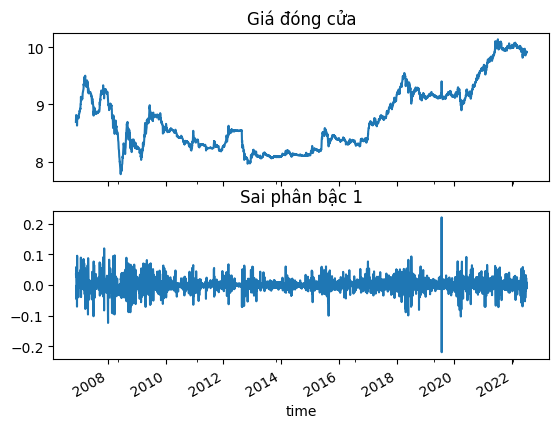

In [ ]:
train_sar_diff = convert_stationary(df_train_sar)
fix, ax =plt.subplots(2, sharex="all")
df_train_sar.plot(ax=ax[0], title ="Closing price")
train_sar_diff.plot(ax=ax[1], title = "1st derivative")
plt.show()


In [ ]:
print(adf_test(train_sar_diff))
print('----------------------------------------')
print(kpss_test(train_sar_diff))

Augmented Dickey-Fuller Test:
Test Statistic                -1.200033e+01
p-value                        3.358196e-22
No. Lags Used                  1.900000e+01
Number of Observations Used    3.870000e+03
Critical Value (1%)           -3.432041e+00
Critical Value (5%)           -2.862287e+00
Critical Value (10%)          -2.567168e+00
dtype: float64
----------------------------------------
KPSS Test:
Test Statistic            0.238947
p-value                   0.100000
No. Lags Used            11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-18-8595738f9caf>:54: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test = kpss(data)


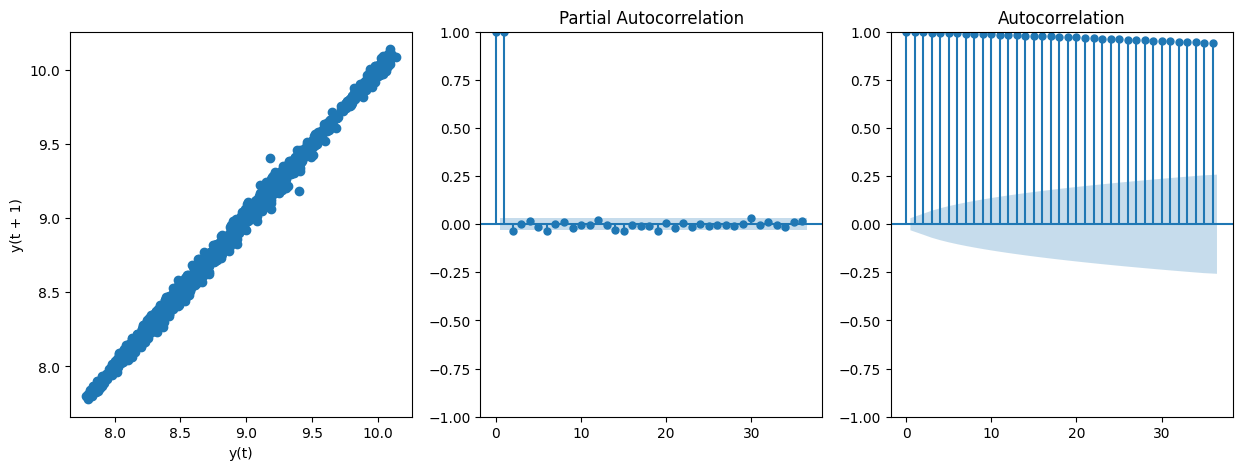

In [ ]:
plot_correlation(df_train_sar)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=26.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-15956.366, Time=1.38 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-17085.840, Time=5.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=17.41 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-15961.473, Time=0.35 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-17541.393, Time=7.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=43.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=18.65 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-17529.566, Time=2.21 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-17539.629, Time=20.36 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-17539.532, Time=13.60 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-17541.523, Time=12.46 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-17085.990, Time=5.63 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=40.78 sec
 ARIMA(0,1,1)(1,1,

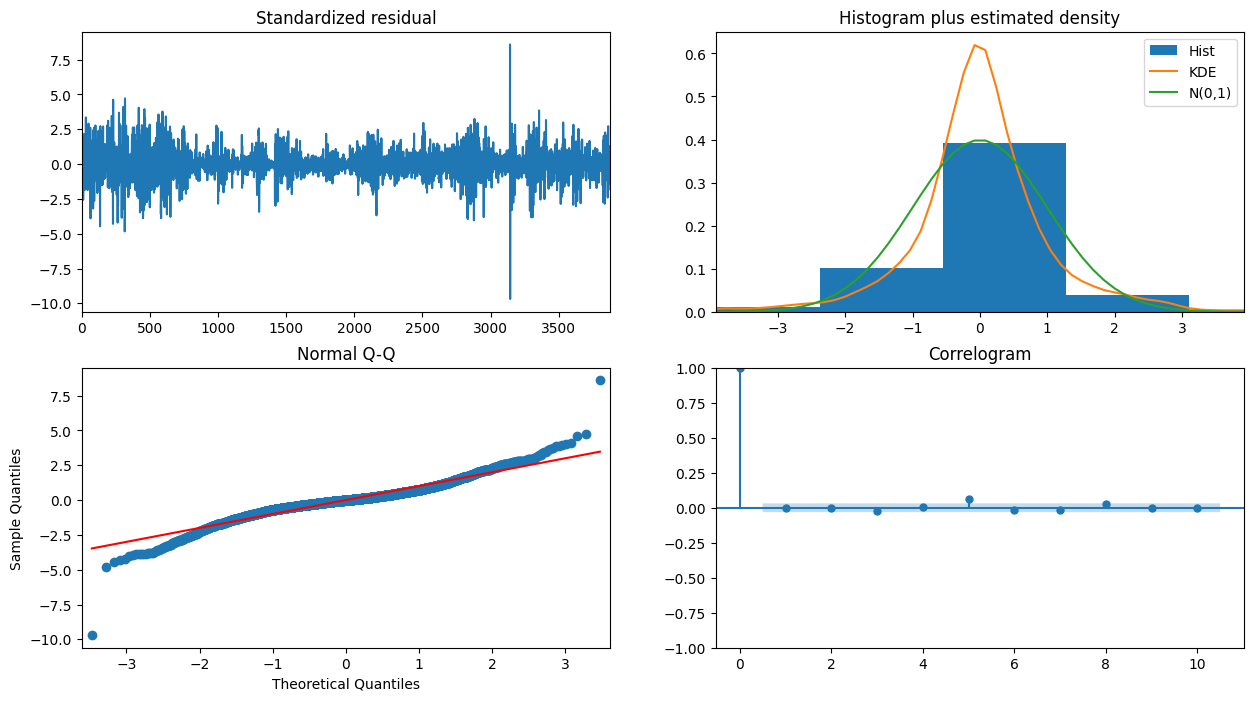

In [ ]:
stepwise_fit = auto_arima(df_train_sar, trace=True, suppress_warnings=True, seasonal=True, stepwise=True, test='adf',
                         m=12, d=1, D=1, start_q = 1, start_p = 1,
                         max_p=3,  max_q=3)
print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15, 8))
plt.show()

In [ ]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(df_train_sar, order=(0,1,0), seasonal_order=(2,1,0,12), enforce_stationarity = False, enforce_invertibility=False)
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                 3891
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                8726.757
Date:                            Fri, 10 May 2024   AIC                         -17447.515
Time:                                    15:04:37   BIC                         -17428.744
Sample:                                         0   HQIC                        -17440.848
                                           - 3891                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6702      0.010    -65.399      0.000      -0.690      -0.650
ar.S.L24      -0.3321      0.011   

time
2022-07-07    20152.732823
2022-07-08    20284.097299
2022-07-11    20294.233042
2022-07-12    20371.907618
2022-07-13    20506.964046
                  ...     
2024-03-25    25718.145334
2024-03-26    25954.684577
2024-03-27    25631.179845
2024-03-28    25504.311583
2024-03-29    25493.798397
Name: predicted_mean, Length: 433, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


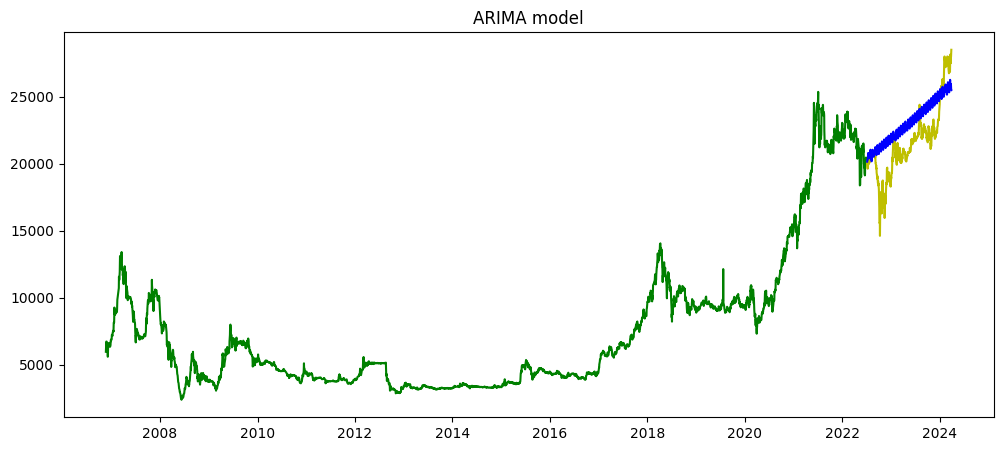

In [ ]:
predict = fitted.predict(start= len(df_train_sar), end = len(df_train_sar)+len(df_test_sar)-1)
fc_values_arima_test = fitted.predict(start = len(df_test_sar))
predict.index = df_test_sar.index

# Print the predictions with their dates
df_test_sar = np.exp(df_test_sar)
df_train_sar = np.exp(df_train_sar)
predict = np.exp(predict)
print(predict)

plt.figure(figsize=(12,5))
plt.plot(df_train_sar, color='g', label='Train')
plt.plot(df_test_sar, color = 'y', label='Test')
plt.plot(predict, color='b', label='Test')
plt.title('ARIMA model')
plt.show()

In [ ]:
indices = data.index[-num_data_points:]
print(indices)

DatetimeIndex(['2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16',
               '2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22',
               '2022-09-23', '2022-09-26',
               ...
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
               '2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27',
               '2024-03-28', '2024-03-29'],
              dtype='datetime64[ns]', name='time', length=387, freq=None)


In [ ]:
# Indices are a list of times to use
indices = data.index[-num_data_points:]

lstm_predictions = y_pred_original
arima_predictions = predict
arima_predictions = arima_predictions.values.reshape(-1, 1)

# Create DataFrame from LSTM prediction data and indices
start_date = '2022-09-13'
start_index = indices.get_loc(start_date)
predictions_df = pd.DataFrame(data=lstm_predictions[start_index:], columns=['LSTM_Predictions'],
                              index=pd.date_range(start=start_date, periods=len(lstm_predictions) - start_index))

# Create DataFrame from ARIMA prediction data and indices
arima_predictions_df = pd.DataFrame(data=arima_predictions[start_index:start_index+len(lstm_predictions)],
                                    columns=['ARIMA_Predictions'],
                                    index=pd.date_range(start=start_date, periods=len(lstm_predictions)))

# Combine data from two DataFrames
combined_df = pd.concat([predictions_df, arima_predictions_df], axis=1)

# Average of two prediction columns
combined_df['Average_Predictions'] = (combined_df['LSTM_Predictions'] + combined_df['ARIMA_Predictions']) / 2



print(combined_df)

            LSTM_Predictions  ARIMA_Predictions  Average_Predictions
2022-09-13      16427.878906       20152.732823         18290.305864
2022-09-14      16443.707031       20284.097299         18363.902165
2022-09-15      16820.845703       20294.233042         18557.539372
2022-09-16      16586.507812       20371.907618         18479.207715
2022-09-17      16420.527344       20506.964046         18463.745695
...                      ...                ...                  ...
2023-09-30      20954.205078       24959.885562         22957.045320
2023-10-01      21110.857422       24836.340050         22973.598736
2023-10-02      20891.511719       24826.102208         22858.806963
2023-10-03      20970.226562       25177.275752         23073.751157
2023-10-04      20882.357422       25125.905117         23004.131269

[387 rows x 3 columns]


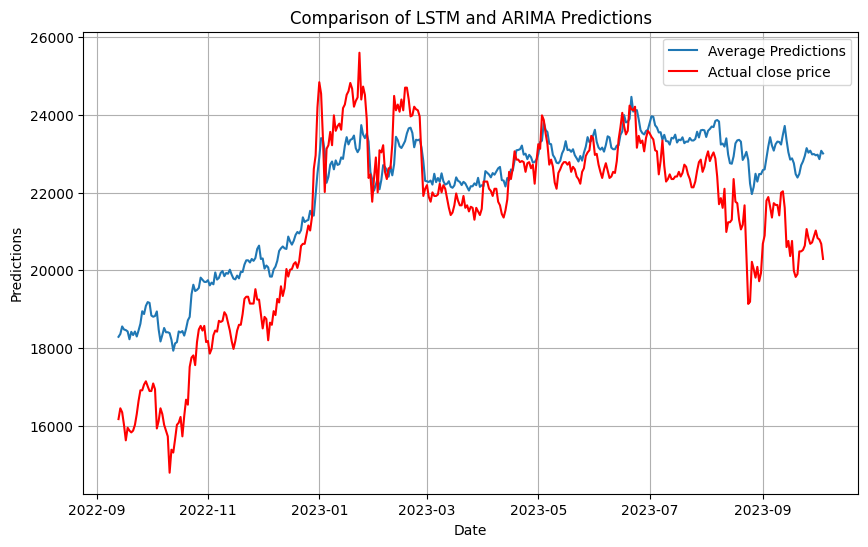

In [ ]:
# Draw chart
plt.figure(figsize=(10, 6))
# plt.plot(combined_df.index, combined_df['LSTM_Predictions'], label='LSTM Predictions')
# plt.plot(combined_df.index, combined_df['ARIMA_Predictions'], label='ARIMA Predictions')
plt.plot(combined_df.index, combined_df['Average_Predictions'], label='Average Predictions')
plt.plot(combined_df.index, y_test_original, label='Actual close price', color='red')
plt.xlabel('Date')
plt.ylabel('Predictions')
plt.title('Comparison of LSTM and ARIMA Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Convert predict to a numpy array
predict_array = predict.to_numpy()

# Normalize predict and combined_df['Average_Predictions']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_predict = scaler.fit_transform(predict_array.reshape(-1, 1))
scaled_average_predictions = scaler.transform(combined_df['Average_Predictions'].values.reshape(-1, 1))

# Make sure the number of samples in predict is the same as combined_df
predict_updated = scaled_predict[:len(combined_df)]

rmse = np.sqrt(mean_squared_error(scaled_average_predictions, predict_updated))
mae = mean_absolute_error(scaled_average_predictions, predict_updated)
mse = mean_squared_error(scaled_average_predictions, predict_updated)

# Calculate MAPE manually
mape = np.mean(np.abs((scaled_average_predictions - predict_updated) / scaled_average_predictions))


print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")


RMSE: 0.1971055349054926
MAE: 0.1583917945410341
MSE: 0.038850591890380363
MAPE: 1.7969013167957397
